In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/ToyVortex.jl/")

  Activating environment at `/media/mat/HDD/ToyVortex.jl/Project.toml`


In [2]:
using Revise
using ToyVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions

┌ Info: Precompiling ToyVortex [ecedb753-2c01-4a22-98ba-d1067d7a6b00]
└ @ Base loading.jl:1342


In [3]:
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        legendfont = font("Computer Modern", 10),
        grid = false)
pyplot()
using LaTeXStrings
using StatsPlots

### Routines for the plots

In [4]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = state_to_lagrange(state, config.zs, config)
    plt = streamlines(X, Y, source, colorbar = false, 
                      xlim = (-2.2, 4), 
                      ylim = (-1.2*maximum(imag.(config.zs)), 1.2maximum(imag.(config.zs))))
    if withvortices == true
        plot!(plt, source, markersize = 12, markerstrokealpha = 0, 
              color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-1.0, 1.0), label = ["Vortices" "Sources"], legend = :outerleft)
    end
    hline!(plt, [0.0], label = "", color = :black)
    scatter!(plt, real.(sensors), imag.(sensors), label = "Sensors", color = :orangered2)
    plt
end

function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

function routine_plotCx(state, Cx::Matrix{Float64}, rx::Int64, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    
    U, S, _ = svd(Symmetric(Cx))
    source = state_to_lagrange(state, config.zs, config)
    
    # Default julia colors
    cur_colors = theme_palette(:auto)
    
    nlines = rx ÷ 3 + 1
    if mod(rx, 3) == 0
        nlines -= 1
    end
    
    plt = plot(layout = grid(nlines, 3))
    
    for i = 1:rx
        idxlines = (i÷3) + 1
        idxcols  = i - 3*(i÷3) 
        if mod(i, 3) == 0
            idxlines -= 1
            idxcols = 3
        end
        
        if withvortices == true
            for j=1:config.Nv
                # Put circles to show strength change
                scatter!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1]],
                      [state[(j-1)*3+2]],
                      markersize = 50*abs.(U[3*j,i]), markerstrokecolor = cur_colors[i],
                      markeralpha = 1.0, 
                      markerstrokewidth = 3,
                      markercolor = :white, legend = false)
            end
#             plot!(plt[idxlines, idxcols], source, markersize = 12, markeralpha = 0.5, 
#                   color = cgrad(reverse(colormap("RdBu")[10:end-10])),
#                   clim = (-1.0, 1.0), label = ["Vortices" "Sources"], legend = false, colorbar = false)
            plot!(plt[idxlines, idxcols],  xlim = (-2.0, 2.0), xticks = -2.0:1.0:2.0, 
                  ylim = (0, 1.2*maximum(imag.(config.zs))))

            for j=1:config.Nv
                # Put arrows to indicate directions of change
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] - U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] - U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] + U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] + U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
            end
        end
    end
    plt
end

routine_plotCx (generic function with 1 method)

### Configuration setup

In [5]:
#
Δtgif = 0.05

# Pressure sensors
Δs = 0.6
sensors = complex.(-1.5:Δs:1.5)
Ny = length(sensors)

Nclusters = 4
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.05
zclusters = [-2.0 + 0.5*im; -1.8 + 1.1*im; -1.9 + 1.7*im; -1.4+ 0.7*im];# -1.5 + 1.4*im]
Nset = 2

config_data = let Nv = Nclusters*Nset, Ns = 1, zs = [2.0*im], Qs = [1.0], U = complex(1.0), 
             ss = sensors, Δt = 1e-2, δ = 1e-2,
             ϵX = 1e-2, ϵΓ = 1e-2, ϵQ = 1e-2,
             β = 1.0,
             ϵY = 1e-1
    VortexConfig(Nv, Ns, zs, Qs, U, ss, Δt, δ, ϵX, ϵΓ, ϵQ, β, ϵY)
end

Nv = config_data.Nv
Ns = config_data.Ns

xgrid = range(-3, 3, length=100)
ygrid = range(-1.2*maximum(imag.(config_data.zs)), 1.2*maximum(imag.(config_data.zs)), length=100)

t0 = 0.0
tf = 4.0
tspan = (t0, tf)

(0.0, 4.0)

### Generate the truth used in the twin experiment

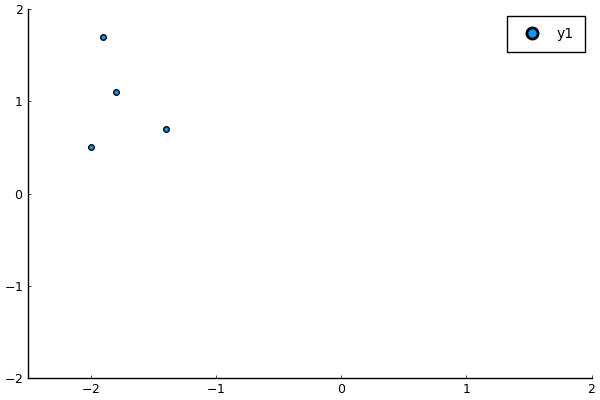

findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


In [6]:
scatter(real.(zclusters), imag.(zclusters), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0))

In [22]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
        @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; -1; 1; -1];# 1]


for i=1:Nclusters
    for j=1:Nset-1
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.1 + 0.05*randn()))
    end
        Γv[i*Nset] = signclusters[i]*abs.(1.0 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

source₊ = Ns >0 ? map(Source.Blob, config_data.zs, config_data.Qs, config_data.δ*ones(Ns)) : Source.Blob{Float64, Float64}[]
source₋ = Ns >0 ? map(Source.Blob, conj.(config_data.zs), config_data.Qs, config_data.δ*ones(Ns)) : Source.Blob{Float64, Float64}[]

sys = (vcat(blobs₊, blobs₋),  vcat(source₊, source₋...))

data = lineargenerate_vortex(I, deepcopy(sys), t0, tf, config_data, "/media/mat/HDD/ToyVortex.jl/src/data/");
tt, x0, xt, yt = load("/media/mat/HDD/ToyVortex.jl/src/data/lineardata_vortex_source.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, x0, xt, yt)

σr / 2 + ((σr / 2) * clamp(randn(), -3.0, 3.0)) / 3.0 = 0.024273293290408577
σr / 2 + ((σr / 2) * clamp(randn(), -3.0, 3.0)) / 3.0 = 0.02136973550153891
σr / 2 + ((σr / 2) * clamp(randn(), -3.0, 3.0)) / 3.0 = 0.03096301133337982
σr / 2 + ((σr / 2) * clamp(randn(), -3.0, 3.0)) / 3.0 = 0.016357089946227588
σr / 2 + ((σr / 2) * clamp(randn(), -3.0, 3.0)) / 3.0 = 0.023312189860741822
σr / 2 + ((σr / 2) * clamp(randn(), -3.0, 3.0)) / 3.0 = 0.016816281488602994
σr / 2 + ((σr / 2) * clamp(randn(), -3.0, 3.0)) / 3.0 = 0.0386431544805999
σr / 2 + ((σr / 2) * clamp(randn(), -3.0, 3.0)) / 3.0 = 0.010867225813428222


SyntheticData([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4.0], [-1.9999397654397382, 0.48370127443365213, 0.09037253932537334, -1.9896916829744913, 0.4849473561515559, 1.2930740701900787, -1.783743172879058, 1.08872564650136, -0.16049355009128688, -1.8048289118785468  …  -1.9190102486115126, 1.673378142162305, 0.8026579421176173, -1.4265449407181277, 0.7043809995336003, -0.15391883787163424, -1.3753021342930933, 0.6934686242364171, -0.9203626652605321, 1.0], [-1.9926227790046291 -1.9794596433734908 … 1.364679751346451 1.3787569716934265; 0.5061837070673241 0.37478669239056145 … 1.6251834648381942 1.6109217874841784; … ; -0.9151648553990226 -0.9103423015125827 … -0.9261107492151067 -0.9037244851433021; 0.9957641336824523 0.9909893688584817 … 0.9890753899141167 0.9906991237789634], [-1.9962388413342613 -2.0386925221846135 … 1.5349297189499764 1.3177099897448388; 0.5216135688677653 0.3291928707556556 … 1.64061432403

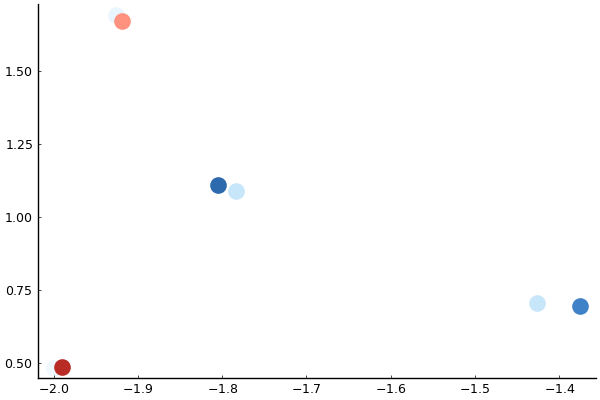

In [23]:
plot(blobs₊, markersize = 12, markerstrokealpha = 0, 
    color = cgrad(reverse(colormap("RdBu")[10:end-10])), legend = false)

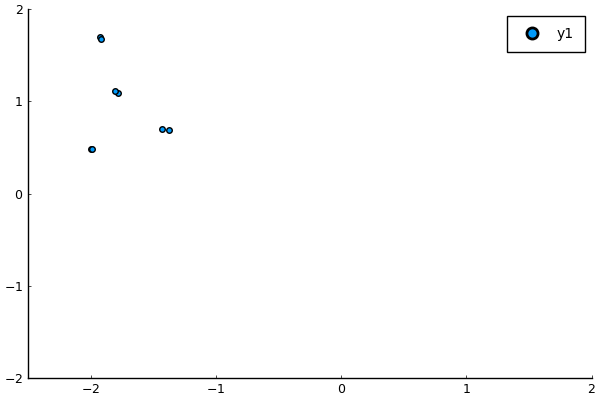

In [24]:
scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0))

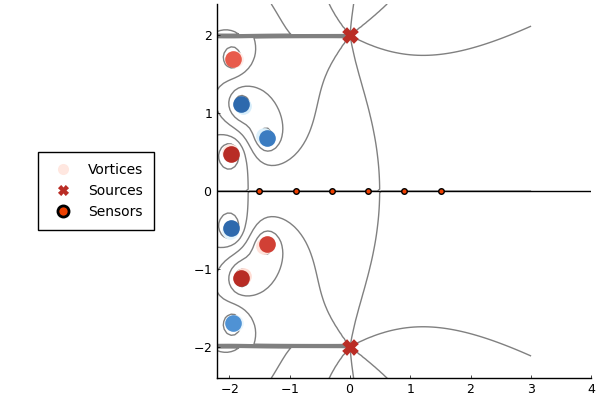

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [25]:
routine_plot(data.xt[:,1], config_data, xgrid, ygrid; withvortices = true)

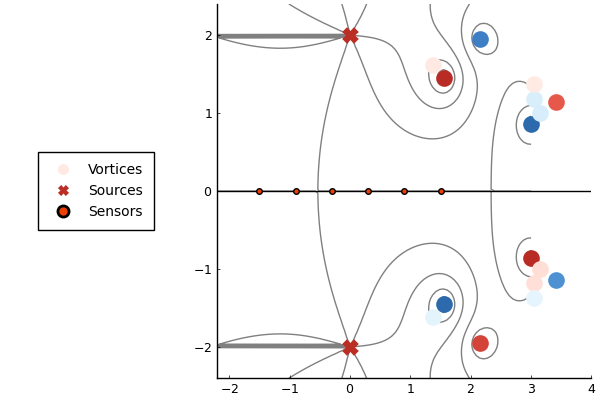

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [26]:
routine_plot(data.xt[:,end], config_data, xgrid, ygrid; withvortices = true)

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   2%|█                                        |  ETA: 0:00:28sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   4%|█▌                                       |  ETA: 0:00:31sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   5%|██                                       |  ETA: 0:00:31sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   6%|██▌                                      |  ETA: 0:00:31sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   7%|███                                      |  ETA: 0:00:32sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   9%|███▌                                     |  ETA: 0:00:31sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  10%|████                              

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:12sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  68%|███████████████████████████▉             |  ETA: 0:00:11sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  69%|████████████████████████████▍            |  ETA: 0:00:11sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  70%|████████████████████████████▉            |  ETA: 0:00:11sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:10sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:10sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:09sys:1: UserWarning: The following kwargs were not use

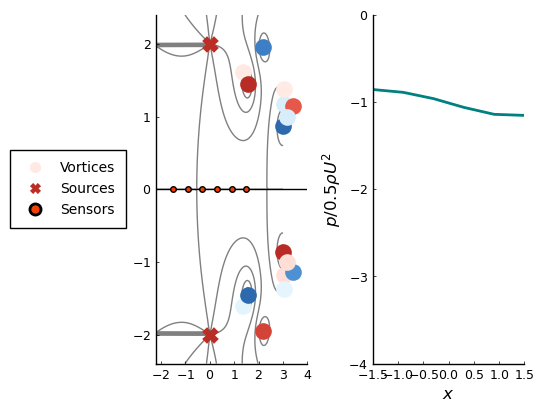

┌ Info: Saved animation to 
│   fn = /media/mat/HDD/ToyVortex.jl/notebooks/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/media/mat/HDD/ToyVortex.jl/notebooks/tmp.gif")
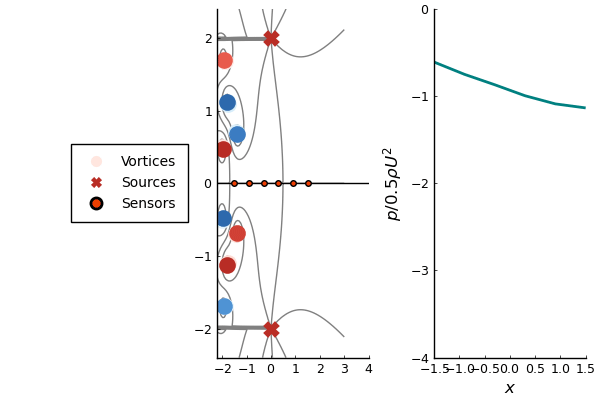

In [27]:
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt1 = routine_plot(data.xt[:,nsnap], config_data, xgrid, ygrid; withvortices = true)
    plt2 = plot(real(config_data.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config_data), xlim = (-Inf, Inf), 
                linewidth = 2, ylim = (-4.0, 0.0), color = :teal, legend = false, xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
    plot(plt1, plt2)
    next!(prog)
end

### Setup the sequential filter

In [28]:
config = let Nv = Nclusters*Nset, Ns = 1, zs = [2.0*im], Qs = [1.0], U = complex(1.0), 
             ss = sensors, Δt = 1e-2, δ = 1e-2,
             ϵX = 1e-2, ϵΓ = 1e-2, ϵQ = 1e-2,
             β = 1.00,
             ϵY = 1e-2
    VortexConfig(Nv, Ns, zs, Qs, U, ss, Δt, δ, ϵX, ϵΓ, ϵQ, β, ϵY)
end

VortexConfig(8, 1, ComplexF64[0.0 + 2.0im], [1.0], 1.0 + 0.0im, ComplexF64[-1.5 + 0.0im, -0.9 + 0.0im, -0.3 + 0.0im, 0.3 + 0.0im, 0.9 + 0.0im, 1.5 + 0.0im], 0.01, 0.01, 0.01, 0.01, 0.01, 1.0, 0.01)

In [29]:
ϵX0 = 0.01
ϵΓ0 = 0.01
ϵQ0 = 0.01

ϵ0 = RecipeInflation([ϵX0; ϵΓ0; ϵQ0])

ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

AdditiveInflation(6, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

In [56]:
Ne = 50
Nx = 3*config.Nv + config.Ns
Ny = copy(Nx)#length(config.ss)

X0 = zeros(Ny+Nx, Ne)

X0[Ny+1:Ny+Nx,:] .= data.x0
ϵ0(X0, Ny, Nx)

In [59]:
Ny

25

In [57]:
enkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)

Stochastic EnKF  with filtered = true


In [40]:
rmse_tab = zeros(Nx)
@showprogress for i=1:Nx
    Xflowrank, Xalowrank = linearlowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; rxdefault = i, rydefault = Ny)
    rmse_i = norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1))
    rmse_tab[i] = deepcopy(rmse_i)
    @show i, rmse_i
end   

LoadError: MethodError: no method matching CubicSplineInterpolation(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, ::Matrix{Float64}; extrapolation_bc=Line())
[0mClosest candidates are:
[0m  CubicSplineInterpolation(::AbstractRange, [91m::AbstractVector{T} where T[39m; bc, extrapolation_bc) at /home/mat/.julia/packages/Interpolations/3gTQB/src/convenience-constructors.jl:12
[0m  CubicSplineInterpolation([91m::Tuple{Vararg{AbstractRange, N}}[39m, ::AbstractArray{T, N}; bc, extrapolation_bc) where {N, T} at /home/mat/.julia/packages/Interpolations/3gTQB/src/convenience-constructors.jl:29

In [33]:
# Plot with rescaling and Cx and Cy
plt = plot(layout = grid(1, 2))
plot!(plt[1,1], 1:Nx, rmse_tab, xlabel = "rank "*latexstring("r_X"), ylabel = "RMSE", 
      label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf), legend = :outertop)
hline!(plt[1,1], [rmse_tab[end]], label = "full rank")
plot!(plt[1,2], 1:Nx, rmse_tab, yscale = :log10, xlabel = "rank "*latexstring("r_x"), 
      ylabel = "RMSE", label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf))
hline!(plt[1,2], [rmse_tab[end]], label = "full rank", legend = :outertop)
# savefig("plot_rmse_rank3.pdf")

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/mat/.julia/packages/Plots/HcxwM/src/utils.jl:95


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/mat/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Axis limits cannot be NaN or Inf')
  File "/home/mat/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 3849, in set_ylim
    top = self._validate_converted_limits(top, self.convert_yunits)
  File "/home/mat/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 3439, in _validate_converted_limits
    raise ValueError("Axis limits cannot be NaN or Inf")


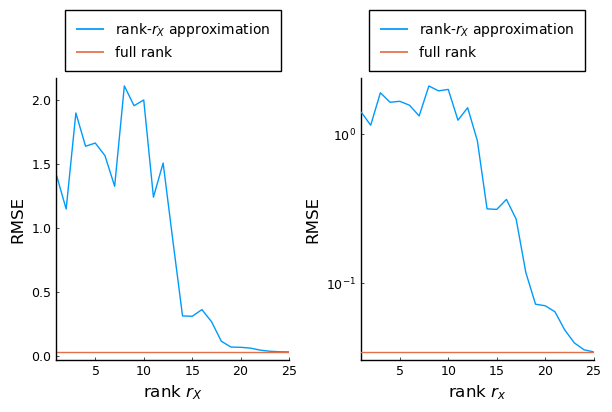

In [347]:
# Plot without rescaling and without Cy

plt = plot(layout = grid(1, 2))
plot!(plt[1,1], 1:Nx, rmse_tab, xlabel = "rank "*latexstring("r_X"), ylabel = "RMSE", 
      label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf), legend = :outertop)
hline!(plt[1,1], [rmse_tab[end]], label = "full rank")
plot!(plt[1,2], 1:Nx, rmse_tab, yscale = :log10, xlabel = "rank "*latexstring("r_x"), 
      ylabel = "RMSE", label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf))
hline!(plt[1,2], [rmse_tab[end]], label = "full rank", legend = :outertop)
# savefig("plot_rmse_rank2.pdf")

In [58]:
Xflowrank, Xalowrank = linearlowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; rxdefault = Ny, rydefault = Ny);

LoadError: DimensionMismatch("array could not be broadcast to match destination")

In [319]:
rmse_lowrankenkf = norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1))

0.3065892586862155

In [320]:
Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; rxdefault = 100, rydefault = Ny);

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.5675262499234402e-11, 2.2421322688760965e-13)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5726485255019795, 0.7134226136390167, 0.8361227446155309, 0.8942109180030958, 0.9373818473950574, 0.9711779419980272, 0.9879763199366189, 0.9973081466369416, 0.9997350487528966, 0.9999870571608803, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.2173801437292246e-13, 2.237769532742131e-13)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   0%|▎                                        |  ETA: 0:00:45

(5.0300865643734054e-12, 7.638634328632146e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.328482268479821, 0.6050240522498815, 0.796419591497066, 0.8904832271355104, 0.9381554430913318, 0.9677244334580659, 0.9885538105874567, 0.998550873589059, 0.9998564058224569, 0.9999912910193105, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.800364826075866e-14, 5.465311731811547e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.098193672255798e-12, 6.88571346308929e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.32169353973251996, 0.598223683930427, 0.7804140149125203, 0.8659366040597437, 0.9376289613989627, 0.9676594641389957, 0.9897119335539588, 0.9986911152411766, 0.9998756166401657, 0.9999928877698223, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.139873125370739e-14, 4.565071348322188e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   1%|▍                                        |  ETA: 0:00:41

(3.632756899487702e-12, 4.057352248201785e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3599302298749214, 0.6530573949270724, 0.8062943194215262, 0.8956617381441714, 0.9466311667929276, 0.9736796916911247, 0.9895025432293003, 0.9984880904423082, 0.9999109021367134, 0.9999942011462185, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (2.973184724561535e-14, 4.237705215977635e-14)


Progress:   1%|▌                                        |  ETA: 0:00:41

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.7821493742509924e-12, 4.068935055422824e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4240814079630566, 0.600926206558492, 0.7556726624423462, 0.8761527403746338, 0.9455922480197393, 0.9799201436498934, 0.9913576882160802, 0.9983636567824005, 0.9999325230835993, 0.9999964146736076, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (2.6266863932651595e-14, 3.4641376675274076e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.7934706710388778e-12, 1.9428962368541842e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4551340267151119, 0.6351881709343684, 0.7951448679097597, 0.880310089001722, 0.936350828535984, 0.9762574919263288, 0.9879200750037953, 0.9983678175921119, 0.9999277213729907, 0.9999958043234524, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.9968021467138612e-14, 2.421893128007597e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   2%|▊                                        |  ETA: 0:00:42

(1.4759008079977245e-12, 1.663377559474772e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.466194393329993, 0.6185746526413681, 0.7623880439433057, 0.8726494813175695, 0.9394085072714535, 0.9727102598008893, 0.9882180764307924, 0.9988902564321452, 0.9999223513405604, 0.9999959953604683, 0.9999999999999994]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.598779671209803e-14, 2.0216879985008627e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.293751071096247e-12, 2.3572521777550206e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41770184851731273, 0.6568230237546213, 0.7932120477374637, 0.8843719882846609, 0.9450936945359721, 0.979684512096272, 0.9899565128035821, 0.9992955748399204, 0.9999291882268202, 0.9999967361797895, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (2.1241657537353887e-14, 2.5385314009866164e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   2%|▉                                        |  ETA: 0:00:41

(3.148209493077352e-12, 3.453120207818601e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4217129991050611, 0.6582139114410558, 0.7825873222159598, 0.8674633906520935, 0.9325181180326604, 0.978213809179844, 0.989319373616799, 0.9992251164911297, 0.9999068580538462, 0.9999964171153117, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (2.302917142758737e-14, 2.8756504327996595e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4146408936631202e-12, 1.8402022800372034e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.35390231383531506, 0.5846915428008241, 0.740260897457804, 0.8490045520850094, 0.9197519537165966, 0.9769132806135821, 0.9893344260134707, 0.9991762374501171, 0.9998899091433172, 0.9999946049999627, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.360960585363824e-14, 1.8120219138475505e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   3%|█▏                                       |  ETA: 0:00:40

(3.953581202847545e-12, 5.26151598515023e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41795807477955554, 0.6237670422903038, 0.7780427030573894, 0.859696125914241, 0.9296941563807003, 0.9754187117139652, 0.9888213701621997, 0.9989131486024574, 0.999878545529762, 0.9999922892121984, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.3353499692174037e-14, 6.681530853750162e-14)


Progress:   3%|█▎                                       |  ETA: 0:00:41

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1920232061055863e-12, 1.7469300996491838e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3884538882370988, 0.6041802463868079, 0.7616057337886658, 0.8518793277280966, 0.9211003081550962, 0.9735211402488761, 0.9889095490171778, 0.9988341324783588, 0.9998870919854171, 0.9999951071852387, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.806477510861676e-15, 1.2172553777512032e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.237567243501304e-13, 1.2376095829284717e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.40315839252136726, 0.62814556624417, 0.7520515718623892, 0.8438004729199293, 0.9134044919475324, 0.9766711879996504, 0.9920823734320848, 0.9985363916430801, 0.999883356903559, 0.9999927086093431, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.294492735512025e-15, 1.3357646570234663e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   4%|█▍                                       |  ETA: 0:00:40

(1.4782182868649397e-12, 2.6346879014378078e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.37009571639589406, 0.5722713509656062, 0.711608006335992, 0.823600056700134, 0.9150376143533041, 0.975418587306502, 0.9891119932383807, 0.9985023147690735, 0.9998412857655288, 0.9999931681774223, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.4767711015821547e-14, 1.9656672865753366e-14)


Progress:   4%|█▌                                       |  ETA: 0:00:40

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.196378828346644e-13, 8.77478677617884e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.38578681491029737, 0.5964519785271463, 0.7512796786030724, 0.8401960589893795, 0.9256816172069174, 0.9796993138458894, 0.9930816181912598, 0.9985061105063748, 0.9998034372969749, 0.9999935152424614, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.335624348307631e-15, 1.1596844237788185e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.924707148668381e-13, 7.356105706672629e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3351115358687962, 0.6039963474549919, 0.7618552158531632, 0.8505728983500719, 0.9215450320230846, 0.9629470415159782, 0.9923467721595017, 0.9990403354478817, 0.9998859521521066, 0.999995432842945, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.305645055667175e-15, 6.585047724183495e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   4%|█▊                                       |  ETA: 0:00:40

(1.2656409476240453e-12, 1.5567757633077127e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41363400912351767, 0.6729858525613999, 0.8146979835399241, 0.8900155525253564, 0.9517187485796484, 0.9816595365589557, 0.9931942237964216, 0.9992952020168684, 0.9998958616068115, 0.9999964445471369, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.6168579597919003e-14, 1.910899509100864e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.657950702188425e-13, 1.2015144129231368e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.42072600258747544, 0.6438317845518837, 0.8248542482555745, 0.8898307210691901, 0.9409678307865442, 0.9742969850300655, 0.9926686917359093, 0.999183744975261, 0.9998801171246213, 0.9999969040373801, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0186391876870855e-14, 1.1898809540471013e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   5%|██                                       |  ETA: 0:00:40

(8.33039278652955e-13, 1.2580420198479965e-14)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4172260519899083, 0.658441260031647, 0.8054386744811859, 0.875976449423561, 0.9270522602904678, 0.9687370953967069, 0.9906574201500968, 0.9988581880326454, 0.9998466361800377, 0.9999959197672004, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.2889752809134261e-14, 1.63208347250328e-14)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.440247592410262e-13, 4.605764795564656e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3798125863924606, 0.6181171439584614, 0.7309871633795928, 0.8292700914498714, 0.8984260352019076, 0.9525145632145123, 0.9890069696080258, 0.9988831128016821, 0.99979097640228, 0.9999965240720586, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.3099280744210014e-15, 4.6960842189530605e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   5%|██▏                                      |  ETA: 0:00:40

(1.4816405585407408e-13, 2.7426670566797714e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.31292532264324946, 0.5723952532706539, 0.7328506333657628, 0.8557905985405992, 0.9152587060590094, 0.9615070425581596, 0.9920575489827641, 0.9989078587585312, 0.999795785405287, 0.9999968101756034, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.4328995561413212e-15, 1.919787121466149e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.872339838291589e-13, 4.447042585884843e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3102410400953583, 0.5478182756361787, 0.6907143365950245, 0.8011444471395346, 0.8688947007820147, 0.9315175878992712, 0.9911449574899399, 0.9987817133601989, 0.9998356475110964, 0.9999957962695786, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.4025245609879184e-15, 4.933198851314961e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   6%|██▍                                      |  ETA: 0:00:39

(1.6769215395154955e-13, 3.0264477342954763e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4286421410114629, 0.6189731343480765, 0.7575687878709229, 0.8373238297875083, 0.9051977228765236, 0.9605319093866758, 0.9930981286244323, 0.9986959208373647, 0.9997734408804583, 0.9999968158833932, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.6268773926425026e-15, 2.0541296871568666e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.522027790474712e-13, 2.5148139617244243e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.43113466334977935, 0.6240519244815099, 0.76427993594663, 0.8406188086154444, 0.9031049011227225, 0.9509079998893596, 0.9913506982070383, 0.9989272535178132, 0.9998554302692133, 0.9999959563078554, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.5812718198064033e-15, 1.9533650352320783e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:   6%|██▌                                      |  ETA: 0:00:39

(1.2002841904030573e-13, 2.154252414825097e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4059397516631792, 0.5896344630596733, 0.7511874429632371, 0.8290912045971734, 0.8984658615042737, 0.9543053621930567, 0.9919971257258755, 0.9989329408118375, 0.9998092363016547, 0.999995145599415, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.3346463523664525e-15, 1.6553628874369081e-15)


Progress:   6%|██▋                                      |  ETA: 0:00:40

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0273316110865992e-13, 1.8046455478650764e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3904056952106847, 0.5994028297866224, 0.7618502116266, 0.8408668104400423, 0.8989802174104963, 0.9497314586582508, 0.9921540247934868, 0.9991235714505333, 0.9998357557540608, 0.9999965430086958, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1451630759181865e-15, 1.4849834405638108e-15)


Progress:   7%|██▊                                      |  ETA: 0:00:40

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.973028741917815e-14, 1.6786561297922888e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4234530137939718, 0.6006659884645776, 0.736122734546073, 0.8278321842928738, 0.8926892921279465, 0.9484887924928145, 0.9918094862357719, 0.9990128011002026, 0.9997395530402522, 0.999995659676298, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1688902636366696e-15, 1.4955427492934693e-15)


Progress:   7%|██▉                                      |  ETA: 0:00:41

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2193221700229766e-13, 2.2413287553717924e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3939374399870636, 0.5796573943169688, 0.743568971596443, 0.8196093992149635, 0.88604644004605, 0.9493300998306369, 0.993117301881197, 0.998872418621657, 0.9997423992101225, 0.9999953824726936, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.376152305816307e-15, 1.7869440493562996e-15)


Progress:   7%|███                                      |  ETA: 0:00:41

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.3824610799660374e-13, 2.7747389188168593e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3818935894238738, 0.5506003432477822, 0.7016133302768861, 0.8113598305828231, 0.8905560455912712, 0.9433435985737423, 0.991472714945258, 0.9989743862736493, 0.9997232910283401, 0.999996323591491, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.6252145405472857e-15, 2.2116397564554395e-15)


Progress:   8%|███▏                                     |  ETA: 0:00:41

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.5231436747333418e-13, 3.043487836474851e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3690559047078657, 0.5360265134218868, 0.6881706571156961, 0.7949530902314116, 0.8802342018323137, 0.9482775664077159, 0.9938836250176962, 0.9990470483896579, 0.9997379578426808, 0.9999955147647913, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.5626153116321646e-15, 2.158899519688066e-15)


Progress:   8%|███▏                                     |  ETA: 0:00:42

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.496435807253913e-14, 1.64103407854368e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.39282121846875134, 0.5750282185793639, 0.719073172487301, 0.8346287735329909, 0.9041559771314779, 0.9580909616373854, 0.9930833384210976, 0.9989315198653029, 0.9996462725050432, 0.9999957204150368, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1265826800640496e-15, 1.5232293719268957e-15)


Progress:   8%|███▎                                     |  ETA: 0:00:42

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.5717630413824304e-13, 2.923132612410735e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3986390543198606, 0.6208526800808332, 0.7715939728003849, 0.8674717884851534, 0.9264219564240554, 0.963893501706871, 0.9934805784869966, 0.9989251907897451, 0.9997871976026679, 0.9999966141213801, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.2140807045438957e-15, 1.5666450611859936e-15)


Progress:   8%|███▍                                     |  ETA: 0:00:42

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4466541249815655e-13, 3.0240465528267656e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.26338563124565284, 0.4718003110992681, 0.672774381881738, 0.8395490873161005, 0.9066474267294116, 0.9554651162044846, 0.9932038940658058, 0.998845555186104, 0.9998493878175309, 0.9999963382339988, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.883296847422459e-15, 2.4784170585966747e-15)


Progress:   8%|███▌                                     |  ETA: 0:00:42

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0061624024785712e-13, 2.1801405964918052e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.33116985005028854, 0.564621728578281, 0.7240040430652734, 0.826094632875809, 0.8992874794709761, 0.9471472003724986, 0.9932924699484501, 0.9986797639743022, 0.9998832702796087, 0.999997979779934, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.3192093226262096e-15, 1.7871347315331857e-15)


Progress:   9%|███▋                                     |  ETA: 0:00:42

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.588395361771999e-14, 1.7115036839468214e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.30036291164358936, 0.49715894523831555, 0.6685693343294434, 0.7964746216084863, 0.8930713752077963, 0.9485201044493303, 0.9938237731003132, 0.9989932515956079, 0.9998649090234201, 0.99999706014144, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1902476762306954e-15, 1.4905305698752971e-15)


Progress:   9%|███▊                                     |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2436802063846616e-13, 2.2644465851573318e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3894880615791331, 0.5864995097240975, 0.7202734045268853, 0.8310610662594335, 0.894287929825402, 0.9466518978920573, 0.9939114060331035, 0.9987097788987864, 0.999861863552627, 0.9999958693172457, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.3015107820421293e-15, 1.6074834657196346e-15)


Progress:   9%|███▊                                     |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.319397208048612e-14, 2.035769530407469e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3194253587542152, 0.5710436360143037, 0.7078218489300371, 0.829190640998435, 0.8948022323300736, 0.9539911451117055, 0.9938692399046795, 0.9987336541582875, 0.9998054971185313, 0.9999949050266067, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.3875716813201416e-15, 1.6834353997989811e-15)


Progress:  10%|███▉                                     |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0498394426603831e-13, 2.445046221205561e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.33895074758253346, 0.5763829134241689, 0.7323440302714417, 0.8359877741387193, 0.9038139283580847, 0.9538024883534112, 0.9919078475251821, 0.9986215513880304, 0.9997863731148572, 0.9999948546072377, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.4354335627653733e-15, 1.872357673096834e-15)


Progress:  10%|████                                     |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.257569124992571e-14, 2.2743710871289113e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3163594564736367, 0.5781503464466518, 0.7564147781880064, 0.8356686034977802, 0.9090497497010614, 0.9624889756445884, 0.9902233460584061, 0.9981067969941708, 0.9997956192660556, 0.9999935672213817, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.7387126495673095e-15, 2.202691018166224e-15)


Progress:  10%|████▏                                    |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0403128132985527e-13, 2.5413888207067128e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.29509263820080084, 0.5466609888024991, 0.6940471796013999, 0.823234230184284, 0.89790436867337, 0.9475715446951056, 0.9930916309584441, 0.9983634142566306, 0.9997974781312399, 0.99999587727963, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.972066339718253e-15, 2.3429677323473427e-15)


Progress:  10%|████▎                                    |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (6.854670328205695e-14, 1.5366279667095413e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3260954470953314, 0.5514719620031346, 0.7211643205846988, 0.8234503500254056, 0.9001118214423114, 0.9510225843797376, 0.9923694985231433, 0.9984934669027702, 0.9998545543455262, 0.9999970205265317, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.09838769537607e-15, 1.3598791340303557e-15)


Progress:  10%|████▎                                    |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1175661386624305e-13, 2.3588862496643573e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.34042291206006353, 0.5878722421125016, 0.7333352712799318, 0.8281607264851799, 0.8977310719867733, 0.94697807261027, 0.9934436569626884, 0.9986037231436921, 0.9998968908111759, 0.9999970511517796, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.213640664856445e-16, 1.1180980561488676e-15)


Progress:  11%|████▍                                    |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.156972561412571e-13, 2.327882652011687e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4126934073999584, 0.6194799235386934, 0.7608211929709896, 0.8403947300004402, 0.9053806246976401, 0.9541267930442436, 0.9929607173665157, 0.9986058071081778, 0.9998827531157878, 0.9999964443085548, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.2443297243845204e-15, 1.6184266504361901e-15)


Progress:  11%|████▌                                    |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.893040668334248e-14, 2.221871179903871e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.43012904127258467, 0.6414479247015326, 0.7410344298323545, 0.8243049282685262, 0.8899826867505061, 0.9444776503270897, 0.9907241359001039, 0.9983469729978163, 0.9998634334127703, 0.9999962355645381, 0.9999999999999996]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.133854898348189e-15, 1.538372139447232e-15)


Progress:  11%|████▋                                    |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.506271985686164e-14, 1.3887342725017174e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41743462004960413, 0.6152752185799473, 0.7444297942037584, 0.8401861396246229, 0.8988300316387592, 0.9476172179564283, 0.9906285826095673, 0.9986800107836223, 0.9998464164586197, 0.9999958112308388, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.755353530335488e-16, 1.3747627902509788e-15)


Progress:  12%|████▊                                    |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.074501733814328e-14, 1.2508346743099013e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.330165220710074, 0.55943392785663, 0.7256379976696471, 0.8217676350013028, 0.902685709552089, 0.9502476361312752, 0.9915433541037045, 0.9990225292958703, 0.9998615008585082, 0.9999970176932015, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.838502801776602e-16, 1.0631373074942705e-15)


Progress:  12%|████▉                                    |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (6.63435952661479e-14, 1.4685331115061686e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.36110258844204995, 0.5898407640461956, 0.7379140593840955, 0.8278054115779587, 0.903832973606269, 0.9531078536552421, 0.9923339088748941, 0.9991103600963125, 0.9998915757989592, 0.9999969285657795, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.074586366442528e-15, 1.2489630116920034e-15)


Progress:  12%|████▉                                    |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (7.350007172985696e-14, 1.6175355541227512e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4170246562977198, 0.5976762749611964, 0.7456107924981507, 0.8388408714183397, 0.911789014559928, 0.9590160530319561, 0.9925068693581482, 0.9987465223576188, 0.9998875813683424, 0.9999967217059984, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.470547992840543e-16, 9.78367090938096e-16)


Progress:  12%|█████                                    |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (6.049056515113585e-14, 1.3601766056677336e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.40791046574461126, 0.5872236948148288, 0.7267828519771793, 0.8260712368757054, 0.9069647550444291, 0.9571713358417191, 0.9922135915212207, 0.998534695899695, 0.99988288319407, 0.9999958199699807, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.080383725768274e-15, 1.184982023087652e-15)


Progress:  12%|█████▏                                   |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.013374504472288e-14, 1.0974064422359955e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.39606464167741157, 0.5697300373438655, 0.7045116238884839, 0.8228649142985871, 0.8921950199889844, 0.951003873632686, 0.9895780121410985, 0.9982035217998239, 0.999863818764416, 0.9999936330768685, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.5640247781449145e-16, 1.0323324980626206e-15)


Progress:  13%|█████▎                                   |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.029688937267785e-14, 1.0843876610456145e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4155592740870109, 0.5933400132127468, 0.722384180645945, 0.832537407701618, 0.90036604050224, 0.9614982194571133, 0.9900437340652136, 0.9980038632418025, 0.9998809691675372, 0.9999962373666549, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.530688069451241e-16, 9.913026963116172e-16)


Progress:  13%|█████▍                                   |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.0357184871449745e-14, 1.0701598737759624e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4019572017538398, 0.6134357504471214, 0.7303662795854796, 0.8300549270163913, 0.902777056148307, 0.959321662934435, 0.9875864550767186, 0.9983786903486996, 0.9998881146693465, 0.999995508925965, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.665217010592052e-16, 9.38166865819199e-16)


Progress:  13%|█████▍                                   |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.0796141855233094e-14, 1.2111295187989306e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3759363066531923, 0.5944078764174956, 0.7162849279625632, 0.821763759589152, 0.8966138549039654, 0.9455690556314011, 0.9869494514071817, 0.9980726454870922, 0.9998705963627655, 0.9999940293968382, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.745032370222622e-16, 8.601942139350571e-16)


Progress:  14%|█████▌                                   |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.09103811326071e-14, 1.0421674066268314e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4088108137963504, 0.6151320165941819, 0.7306975523626063, 0.8332612474805424, 0.9000344159881932, 0.9519472118522758, 0.9886392306400172, 0.9984687464537556, 0.999917787358597, 0.999995699859207, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.903970241152474e-16, 9.895958619724661e-16)


Progress:  14%|█████▋                                   |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.2309499216903964e-14, 1.1394389658695961e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4263393925668926, 0.6042226032209795, 0.7249680468546449, 0.8331148234918938, 0.9125657482431417, 0.9501739649137514, 0.9862795133143983, 0.9984347014992117, 0.9999315886167113, 0.9999947893245789, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.45609644736344e-16, 9.709664636038997e-16)


Progress:  14%|█████▊                                   |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (6.468124247061467e-14, 1.7891646328147228e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4350638794553826, 0.6121585668379522, 0.721378883860176, 0.8272774380761898, 0.9098359106881317, 0.951138896336536, 0.9867165498112228, 0.9980477695894312, 0.9999281180138575, 0.999994124857802, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.227212907651407e-16, 9.242365330426762e-16)


Progress:  14%|█████▉                                   |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.737400838051421e-14, 1.1434710648470251e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.40342872181500833, 0.6044881596458258, 0.7188661970735342, 0.8111355831064659, 0.8834182233671909, 0.944016076211972, 0.9845236958582309, 0.9982912734828823, 0.9999352534657315, 0.9999927370856727, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.323664089570845e-16, 1.0143535993691382e-15)


Progress:  14%|██████                                   |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.507787416295582e-14, 1.111647523233073e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.35735296067224726, 0.5851741375393433, 0.7103041297490739, 0.8232196898304576, 0.8896742064939741, 0.9440527809074069, 0.9801469315760354, 0.9981135103998088, 0.999943318287059, 0.9999892709971343, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0847458028863272e-15, 1.1523203973293488e-15)


Progress:  15%|██████                                   |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.0406564246173684e-14, 1.3671527268387187e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.347710305640818, 0.577171318504866, 0.7145570990790115, 0.8231949464466635, 0.8959027351813457, 0.9468361040619869, 0.9775914873813462, 0.9988246697041964, 0.9999244335059174, 0.9999874105364106, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0052800315262475e-15, 1.110260219837337e-15)


Progress:  15%|██████▏                                  |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.033230457011166e-14, 1.4431179971572053e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.40174816041043815, 0.6124368147527867, 0.7307594177491639, 0.8252717164479884, 0.8991671560765427, 0.9601575999113119, 0.9842958072219132, 0.99856317933147, 0.9999354668635061, 0.9999866122663068, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.608542496962395e-16, 9.09671193913687e-16)


Progress:  15%|██████▎                                  |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.1533412322412966e-14, 1.5468492786961401e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3464625023862943, 0.5591919379661074, 0.6867604468255579, 0.7962277397989451, 0.8775853889116337, 0.9432527535043036, 0.9737744196112331, 0.9982128406933676, 0.9999249823290997, 0.9999912738849817, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.170246518925741e-16, 9.32313005215934e-16)


Progress:  16%|██████▍                                  |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.876190184910289e-14, 1.009700662436454e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.39794541927220706, 0.5627997538250429, 0.6939610346899723, 0.8058970450499686, 0.8806315758936816, 0.9404725275443304, 0.9771903851616612, 0.9983312852640845, 0.9999344528722865, 0.9999886674953743, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.461796996840397e-16, 9.670361390144332e-16)


Progress:  16%|██████▌                                  |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (6.178549099152814e-14, 2.3568708057015855e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4024849794224547, 0.5711928132907891, 0.6809011788035533, 0.7781487424625464, 0.8634913533268905, 0.9240351463834613, 0.9745294286881729, 0.997867158971279, 0.9999126253896293, 0.9999888539114916, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.8863176756472e-16, 1.2314354430423142e-15)


Progress:  16%|██████▌                                  |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.8862634767867616e-14, 1.3042572512413552e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4473117560259453, 0.6026329603633879, 0.7140079674641258, 0.8005671266994256, 0.8660333363263583, 0.9273911526000506, 0.9709302887109788, 0.9977649425562457, 0.9999148644493837, 0.999985240169434, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.9833879183912e-16, 9.608231099364018e-16)


Progress:  16%|██████▋                                  |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.3981130290310877e-14, 1.4247264492408849e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.46437295634326675, 0.6318262206924189, 0.7477847520236623, 0.8229485788754387, 0.8841018577854979, 0.9325487493993703, 0.9726879125593831, 0.9975367104523288, 0.999915425387156, 0.9999833281290594, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.668195571477079e-16, 8.899387023581424e-16)


Progress:  16%|██████▊                                  |  ETA: 0:00:44

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.666115660804846e-14, 1.1208497754281973e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4861951457035711, 0.6658612488592276, 0.7546898362206462, 0.8341485682186249, 0.8949457464000082, 0.9433992207670058, 0.9779328034928877, 0.9979346209756669, 0.9998914441749843, 0.9999868399913194, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.906302101364488e-16, 9.25298450394234e-16)


Progress:  17%|██████▉                                  |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.604412548573199e-14, 9.298669821928795e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.43018705398288043, 0.6288888019585362, 0.7487188650309963, 0.8409776593371578, 0.8935843317512859, 0.9401312799516411, 0.9750926078555998, 0.997635601560621, 0.9999077573216371, 0.9999857877179607, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.596761920353374e-16, 8.821200380720752e-16)


Progress:  17%|███████                                  |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.42614049329621e-14, 1.1242396570086587e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.47066154162230606, 0.6341212945649242, 0.740489460674492, 0.8257620013932434, 0.8960111998300827, 0.9446234391016781, 0.9790082011754669, 0.9976149784842597, 0.9999054426514676, 0.9999864746414323, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.907478072083262e-16, 8.061029489309978e-16)


Progress:  17%|███████▏                                 |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.398444023914959e-14, 9.772767705922878e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5081907313688356, 0.6607340264468455, 0.7722563980727635, 0.864107061643601, 0.9247132916775348, 0.9608364692460686, 0.984560093535549, 0.9980827577386695, 0.9999103125665124, 0.9999893738759935, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.948960551232478e-16, 7.860163919367016e-16)


Progress:  18%|███████▏                                 |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.1447062879964084e-14, 9.610787394893793e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4828941558461954, 0.6436136288072134, 0.7626604874878712, 0.8709148469846589, 0.927608802126417, 0.9609122303567557, 0.9885595023730852, 0.997945168023983, 0.9998888532360184, 0.9999861539243791, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.056945284190113e-16, 8.787352907330105e-16)


Progress:  18%|███████▎                                 |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.536335054239134e-14, 1.2917409220757962e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.45073460672336857, 0.6291822830368358, 0.7721250673438376, 0.8591077857815899, 0.9207162402563144, 0.9619679611095387, 0.9879239151173039, 0.9974916609373955, 0.9998581881119606, 0.9999855351859693, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.015703963985753e-16, 9.384109477303433e-16)


Progress:  18%|███████▍                                 |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.0065443481598054e-14, 1.15050933033127e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41453528122614536, 0.5928761948119382, 0.7510835299561502, 0.8341047393002031, 0.9003797390200899, 0.9551724437451549, 0.9864748416589706, 0.9978237511224701, 0.9998638180073569, 0.9999886274353212, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.1394642733420855e-16, 9.497207375915878e-16)


Progress:  18%|███████▌                                 |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.2553716809360705e-14, 1.4141377335066316e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.429298295949336, 0.6006411437617647, 0.7427994189158208, 0.8306839825171054, 0.9051375156138102, 0.958589799335765, 0.9898461816964417, 0.997773277703798, 0.9998424102981084, 0.999992291223861, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1312831361820613e-15, 1.2300431638279992e-15)


Progress:  18%|███████▋                                 |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.244278986850799e-14, 1.2514039669695333e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3883490422269912, 0.5787075227834365, 0.7341378633804119, 0.8267857988952174, 0.9069177293624011, 0.954845451025134, 0.987984986418616, 0.9977343235168038, 0.9998051504457511, 0.9999915900269143, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.665007387247899e-16, 1.0050819845204041e-15)


Progress:  19%|███████▊                                 |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.555780788631446e-14, 1.7289665463724206e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.38926068038058914, 0.5879859585872972, 0.7406762788096833, 0.835861720569956, 0.9214917185182986, 0.9588161376125892, 0.9876337764796571, 0.997930321861388, 0.999789437816702, 0.999989702342248, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0127871906414478e-15, 1.1196484814883617e-15)


Progress:  19%|███████▊                                 |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.74070273222465e-14, 1.932395972834859e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3850512617004806, 0.5906276068972436, 0.7304684351604647, 0.8244327661250287, 0.9072236090650866, 0.9494983725655654, 0.9885232640521283, 0.9979392093616586, 0.9997995315065312, 0.9999872711602696, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.826509432526432e-16, 8.791047618882898e-16)


Progress:  19%|███████▉                                 |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.3011930961348323e-14, 1.3285424062521014e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4035272525391953, 0.5759000151850808, 0.7316710497049879, 0.822837084502114, 0.8978858698293605, 0.956858974947115, 0.9910749271676904, 0.9980117489727672, 0.9997805133944456, 0.999985804326339, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.385595173137372e-16, 9.398990179914133e-16)


Progress:  20%|████████                                 |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.754965077244822e-14, 1.6127439358153386e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.37967409179352385, 0.5499664843649936, 0.7047298016116778, 0.8025157281260746, 0.892070380848214, 0.9520714114774032, 0.9894411550657545, 0.9979212094844759, 0.9996664875005697, 0.9999848078125151, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.181093136361496e-16, 1.0588629968323725e-15)


Progress:  20%|████████▏                                |  ETA: 0:00:42

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.508666645663805e-14, 1.5735541293252622e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3819489022518413, 0.5739169532622331, 0.7081274720905902, 0.8307684447860337, 0.8938000243332974, 0.9498860191907529, 0.9864417435800399, 0.9975237695089959, 0.9996019680773967, 0.9999797969973916, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.033491258379328e-16, 9.767782601110184e-16)


Progress:  20%|████████▎                                |  ETA: 0:00:43

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.7473381367304652e-14, 1.2820452585743744e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.35059552769765556, 0.5364338100592236, 0.7189259459992089, 0.8385604858820556, 0.9047266437949145, 0.9535970879514089, 0.9883806500288103, 0.9974268792486832, 0.9996297623532959, 0.999979361486106, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.683336069650553e-16, 9.49709717869319e-16)


Progress:  20%|████████▎                                |  ETA: 0:00:42

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4203876540583075e-14, 1.073204887046077e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.34685845992890335, 0.5935398897232378, 0.7343953584924546, 0.8389726608513469, 0.9031393208520807, 0.9507018197686087, 0.9877237985389837, 0.9975180814645899, 0.9996669239113521, 0.999981935621155, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.572334163326293e-16, 1.0497865768036154e-15)


Progress:  20%|████████▍                                |  ETA: 0:00:42

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.410182781752421e-14, 1.3690447247249266e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3749639844023955, 0.6296526910764139, 0.7466423032240229, 0.8422732423546968, 0.9066972575922928, 0.9535199450892334, 0.988193723850406, 0.9976717961764942, 0.9996633860902077, 0.9999831608943573, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.103447960294058e-16, 9.788772440078176e-16)


Progress:  21%|████████▌                                |  ETA: 0:00:42

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4807132867023237e-14, 1.0965195692508231e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3393325822077592, 0.6399998535799992, 0.7692060960168825, 0.8407838965601093, 0.9034656445500748, 0.9523173638275231, 0.9864121225981671, 0.9970429660741139, 0.9996844237085803, 0.9999832094619683, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.539262838196134e-16, 9.33806563902362e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.5850644155044053e-14, 1.1853760988334164e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.33051621823760857, 0.5964686735269478, 0.7271668046658839, 0.8209232906912093, 0.8979343122002605, 0.9420784796530366, 0.9840677559454032, 0.9971181604558702, 0.9996039384908315, 0.999984571472975, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.271535968597388e-16, 9.821021995064398e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf)

Progress:  21%|████████▊                                |  ETA: 0:00:42

(2.863455497540254e-14, 1.3852516142723167e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.35557108806168125, 0.5717433799721707, 0.6987953110448976, 0.8147261967716442, 0.8859542286382767, 0.9377677354232877, 0.9836713898151271, 0.9961177774048116, 0.9996220651686248, 0.9999841881147056, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.601615990950409e-16, 9.20533647969305e-16)


Progress:  22%|████████▉                                |  ETA: 0:00:42

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.994171469632289e-14, 9.116010443395596e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4318279718989826, 0.5882860323558676, 0.7174287697636692, 0.8251465410762051, 0.8980452369874357, 0.9460653803671774, 0.9815900781880852, 0.9965940486453334, 0.9996316078279912, 0.999984752676271, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.798955031336313e-16, 8.872919742450156e-16)


Progress:  22%|████████▉                                |  ETA: 0:00:41

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.990495675788806e-14, 2.5633999512592774e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3752736320949442, 0.5600843466457279, 0.698273529954489, 0.8110532791339853, 0.8894715588578594, 0.942742463005808, 0.9794720344019148, 0.9956146394454755, 0.9996394031071429, 0.9999844488950084, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.033241897816933e-16, 1.0280895420046642e-15)


Progress:  22%|█████████                                |  ETA: 0:00:41

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.917214622001498e-14, 2.111522254307693e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.42835439369622547, 0.6071227788023658, 0.7300358180537174, 0.8349962704887186, 0.9101590698222362, 0.963339775701334, 0.981568108755696, 0.9968879398064688, 0.9996889618024029, 0.9999878640006185, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.435159464818935e-16, 8.648668148585665e-16)


Progress:  22%|█████████▏                               |  ETA: 0:00:41

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.1543643069660204e-14, 1.6641175292585159e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4451923946320156, 0.6344708072599475, 0.7514886635183763, 0.8525613688468536, 0.9170920921513996, 0.9600358536007141, 0.9845425246164026, 0.9978673567801003, 0.9997305617944057, 0.9999872633910347, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.979204425422677e-16, 1.0415774789738725e-15)


Progress:  22%|█████████▎                               |  ETA: 0:00:41

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.077643608315823e-14, 1.2753677241882494e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.44918429057409115, 0.6312120357686919, 0.7657891396128895, 0.8507898817471384, 0.9212469693729312, 0.9635092825029384, 0.9862285306770162, 0.9974465872168892, 0.9996989767444393, 0.9999873245778677, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.199190088204659e-16, 9.72726204195768e-16)


Progress:  23%|█████████▍                               |  ETA: 0:00:41

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.8607187661600576e-14, 1.1293185463506417e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.46339395020373436, 0.629457046090731, 0.7570478211144088, 0.865347536348645, 0.9262130363493324, 0.9647076776198198, 0.9864951619757836, 0.9977281206565611, 0.999707868543875, 0.9999888535446346, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.803501994907247e-16, 9.65376029287517e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.7618155951201985e-14, 1.3159204809421344e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4890153288985966, 0.6514992125357918, 0.7660666417075113, 0.8766520709619896, 0.921105809423695, 0.9639261718148052, 0.9863994252588894, 0.9980349343886794, 0.9997185328063402, 0.9999856037661985, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.814122831255582e-16, 9.10866133399153e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / n

Progress:  23%|█████████▌                               |  ETA: 0:00:41

(2.7651813551436084e-14, 1.010675669574016e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4807946424245096, 0.6605659959485901, 0.7705946683294841, 0.8724611680630338, 0.9275140559706069, 0.9628881748369627, 0.9862637783413868, 0.9980009222496342, 0.9997144775116491, 0.9999862561300045, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.638004350166182e-16, 9.308525338978955e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.4533200290426416e-14, 1.2620925879468644e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.49577329794039116, 0.669182366049847, 0.776066613810911, 0.870777110367271, 0.92443395176826, 0.9592537633486814, 0.9857446745789422, 0.997927923060916, 0.9997130374914879, 0.9999832041371733, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.522658881264088e-16, 8.192514254717498e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  24%|█████████▊                               |  ETA: 0:00:40

(3.1556635101531214e-14, 1.1250199164293531e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.48671502385121274, 0.6740717883281683, 0.7849526701109731, 0.8563437059129525, 0.9213543682714533, 0.9606220269047895, 0.9868140585563213, 0.9982106203382801, 0.9996794385100134, 0.9999834751954523, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.974597418301927e-16, 8.675176581050677e-16)


Progress:  24%|█████████▉                               |  ETA: 0:00:40

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.393763615993545e-14, 1.121567176803085e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5404116122870678, 0.6819315359386144, 0.7743489255026063, 0.853914535826076, 0.9195779849707622, 0.9607458454546804, 0.9868202220033733, 0.9982749776136477, 0.9996095412247149, 0.9999838264876437, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.458285369280042e-16, 1.1712210205308688e-15)


Progress:  24%|██████████                               |  ETA: 0:00:40

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.3772872732435645e-14, 1.2536221973015384e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5096492572887067, 0.6641275651187808, 0.7676317253526428, 0.8447522999968384, 0.9125100093127395, 0.956880435935809, 0.9851124667803532, 0.9979935095164567, 0.9995873129573325, 0.9999793243095223, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.433082446277457e-16, 9.881817343901236e-16)


Progress:  24%|██████████                               |  ETA: 0:00:40

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.3201836223514975e-14, 1.077240684248165e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5333216407528905, 0.6760168187251185, 0.7742920581825877, 0.8595336219673975, 0.9226383282247431, 0.9610725262206041, 0.9857114199799184, 0.9981857270677776, 0.9996009823467458, 0.9999782643682538, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.485030594599292e-16, 9.239070639518634e-16)


Progress:  25%|██████████▏                              |  ETA: 0:00:40

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.962426870170475e-14, 9.966911534776422e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5140638023474029, 0.6744879570268468, 0.7842962634662797, 0.8552637663065683, 0.9182079656511511, 0.9570483034502336, 0.9827482991855604, 0.9983994607438536, 0.9995449528875942, 0.9999808491322488, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.367233831744297e-16, 1.1595603439816841e-15)


Progress:  25%|██████████▎                              |  ETA: 0:00:40

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.456398019914669e-14, 1.4097324075778889e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5276845099275411, 0.6879663787466689, 0.7931775042085897, 0.8661687363655204, 0.9229979114901281, 0.9625347720728271, 0.9846485910239751, 0.997955851386317, 0.9995817954178275, 0.9999771117682357, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.836716019871094e-16, 9.678117328010521e-16)


Progress:  25%|██████████▍                              |  ETA: 0:00:40

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.1058490915797363e-14, 1.4547738629664719e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4649360743846429, 0.6461892149656197, 0.776974399364668, 0.8574486029540753, 0.9197531149801811, 0.9621346409039065, 0.9839963169340803, 0.9978408364764886, 0.9995594286431585, 0.9999774748498561, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.918982676328367e-16, 1.0299520775372848e-15)


Progress:  26%|██████████▌                              |  ETA: 0:00:40

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.2248804204575275e-14, 1.1070498051450472e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4726305188481861, 0.6449827157280914, 0.7807648058905553, 0.85694957914785, 0.9169054348748397, 0.9644143359157311, 0.985354112588169, 0.9975979549746796, 0.9996183593335233, 0.9999756428104265, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.84041751228407e-16, 1.0083883402382678e-15)


Progress:  26%|██████████▌                              |  ETA: 0:00:39

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.2413136114849206e-14, 1.1427940499823479e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.476882940317509, 0.6500240604854882, 0.7844597899821533, 0.8628304863910311, 0.9254717338116342, 0.9675182457710153, 0.9858516680212421, 0.9977190895836905, 0.9996143384290388, 0.9999736522885883, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.828629280570874e-16, 1.07000721570591e-15)


Progress:  26%|██████████▋                              |  ETA: 0:00:39

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.694749355193358e-14, 9.787734106941525e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4941134244498235, 0.6813954426698013, 0.7827576669762134, 0.8601051298667212, 0.9122065968297169, 0.9616615101860206, 0.9803496526717257, 0.9958653691768429, 0.9996403661859904, 0.9999759555066255, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.804948151161192e-16, 1.0409221783923916e-15)


Progress:  26%|██████████▊                              |  ETA: 0:00:39

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.9094127134585655e-14, 1.470404339064349e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.49616504540211165, 0.6653913683332241, 0.778428418952134, 0.8596805478733485, 0.9155292469711854, 0.9581125933108625, 0.9791571255690571, 0.9966170509384821, 0.9996926463208218, 0.9999720038123355, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.726256212680329e-16, 1.077387709050268e-15)


Progress:  26%|██████████▉                              |  ETA: 0:00:39

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.8333284551775225e-14, 9.675727677816328e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4728797722560401, 0.6414305284978026, 0.8004257655794037, 0.8725428018006974, 0.9297156651632182, 0.9648388798353525, 0.9819904300748429, 0.9973514889715802, 0.9997221980679721, 0.9999687922212662, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.367114021091924e-16, 1.0507106089786473e-15)


Progress:  27%|███████████                              |  ETA: 0:00:39

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.504911588947477e-14, 1.3465357477669406e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4396744262247432, 0.6390619778722756, 0.7999087436387424, 0.8730140435830355, 0.9277712222561273, 0.9608373542435771, 0.9835208906400482, 0.9967284240267887, 0.9996530877135268, 0.9999641579096551, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.019457729171692e-16, 1.1940452028283821e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.6302663733330997e-14, 8.810925952389312e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.48738306076418164, 0.6712080938425663, 0.8157125628225101, 0.8912726420368615, 0.9399235549610117, 0.9637449877713148, 0.9835914963433213, 0.9965830156065053, 0.9996570752834049, 0.9999690533843087, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.932066426454632e-16, 1.2207166780917451e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenk

Progress:  27%|███████████▏                             |  ETA: 0:00:39

(3.31427464276107e-14, 1.0737341460055938e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4422699013209497, 0.6560503395610996, 0.8133917677112932, 0.8945605638087365, 0.9411907650976283, 0.9687725245820363, 0.9840318620470883, 0.9977541652998685, 0.999689862731045, 0.9999726111015136, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.661489031199756e-16, 1.1043923039018391e-15)


Progress:  28%|███████████▎                             |  ETA: 0:00:39

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.328497553100952e-14, 1.2888934249009523e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5009676889432791, 0.6925087215695342, 0.8330324740722489, 0.9106769392463201, 0.9453748669610609, 0.9682012132757848, 0.984991924573893, 0.9980127976047919, 0.9996835008630155, 0.9999707976756627, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.376429623677792e-16, 1.1127649325315882e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.447026242759264e-14, 9.838266464838729e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5119869694698238, 0.6964720583714515, 0.8261672289266806, 0.8928254932830643, 0.9449244661318579, 0.9742492176545648, 0.9885580603084614, 0.997633622365385, 0.9996382857234765, 0.9999736929199233, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.860248250936098e-16, 1.0291066066519115e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) =

Progress:  28%|███████████▌                             |  ETA: 0:00:38

(6.130412368735861e-14, 1.8477916357561832e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4752196242908198, 0.6700258919141967, 0.8173238092890349, 0.8923564981005605, 0.9365662828466018, 0.9700499498576948, 0.9858767547829758, 0.9983741817319032, 0.9996464987569834, 0.999961698111049, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.565560736095521e-16, 9.268521236260306e-16)


Progress:  28%|███████████▋                             |  ETA: 0:00:38

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.4760217308018844e-14, 1.041709231931787e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4439693002566424, 0.6770172396744591, 0.8128485377698055, 0.9066724422664612, 0.9451768939837378, 0.9703860742750314, 0.9848879139653538, 0.998005752879852, 0.9996833676213387, 0.9999690651094354, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0275071153033402e-15, 1.2484164624929104e-15)


Progress:  28%|███████████▋                             |  ETA: 0:00:38

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.4850409013424775e-14, 1.6092978761501861e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4882886473746387, 0.6922987897993659, 0.8383065716250551, 0.9052356551356511, 0.9437829692251131, 0.9741553154275214, 0.9876989977093008, 0.9978656017353725, 0.9995596748466987, 0.9999650768028393, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.898351293430453e-16, 1.165261819944431e-15)


Progress:  29%|███████████▊                             |  ETA: 0:00:38

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.224199190432067e-14, 2.135881663076062e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4440887093836641, 0.7074653912241038, 0.8397867145768094, 0.9190544006078022, 0.9543713716160024, 0.9767646808506375, 0.9899695216894533, 0.9985615313394441, 0.9996508715236807, 0.9999729644881832, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.388006406290941e-16, 9.85005432741023e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (6.5818357539531e-14, 1.5603660248162645e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5301026561986508, 0.7371963259938669, 0.8496798148506347, 0.9194314079897062, 0.9532908724729153, 0.9771296676351956, 0.9901062870831272, 0.9984102248125766, 0.9996217600132521, 0.9999771503031039, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.389095667038853e-16, 1.1040631876295476e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / n

Progress:  29%|████████████                             |  ETA: 0:00:37

(4.541157921787259e-14, 1.276564886902954e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4212006863296954, 0.7015964934548556, 0.8184155906974752, 0.8968937327204368, 0.9487430508096797, 0.9792280807027309, 0.9915561700663744, 0.9985027400581925, 0.9996204755043302, 0.9999701639696363, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.100086485661812e-16, 1.1097583662970281e-15)


Progress:  30%|████████████▏                            |  ETA: 0:00:37

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.706240896710018e-14, 1.0698672128132502e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5313095161345414, 0.7206884409814529, 0.8370653042209028, 0.9039382451600116, 0.9522236754314196, 0.9822731621065318, 0.9923717476165607, 0.998360058629527, 0.9996156384312147, 0.9999761364866259, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.967323742246452e-16, 9.989120165285077e-16)


Progress:  30%|████████████▎                            |  ETA: 0:00:37

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.947923660717007e-14, 2.6779399134250793e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5076718661422922, 0.6915580926508499, 0.8188590795860382, 0.8911671621720677, 0.9473737559067954, 0.9763076571746753, 0.9903738494473451, 0.9979896897206345, 0.999581390016262, 0.9999742368230928, 0.9999999999999996]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.414158774775516e-16, 9.543448254127807e-16)


Progress:  30%|████████████▎                            |  ETA: 0:00:37

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.6864719590449726e-14, 1.5616913121678833e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4636724010923445, 0.6542418204265829, 0.7778427541042029, 0.8712713158416124, 0.9313774381808093, 0.968586489089859, 0.9853154867344012, 0.9978352004298648, 0.999622751176097, 0.9999699660297217, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.525075167110163e-16, 1.0032051861823539e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (6.252123359678333e-14, 2.115097605782665e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.45517788662117226, 0.6462866872648526, 0.770785838484921, 0.8483477331376399, 0.9151622952304636, 0.966525460343403, 0.9834947033425374, 0.9976025989152729, 0.9995274947908626, 0.9999653729422814, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.61624100218728e-16, 9.08775913339956e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  30%|████████████▌                            |  ETA: 0:00:36

(4.8579103265154266e-14, 2.279650662907772e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3605390830565811, 0.5760010620274183, 0.7365323589770428, 0.8419452481473706, 0.917881853277693, 0.9601866510558438, 0.9806532523704231, 0.9965376087407224, 0.9995131812863958, 0.9999509039201174, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.875920624963113e-16, 1.1159741083299287e-15)


Progress:  31%|████████████▋                            |  ETA: 0:00:36

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.0830095188773835e-14, 1.4948241783437827e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3573400528071164, 0.5908722808322657, 0.7415673645199925, 0.8447325199258005, 0.9287434929664314, 0.9616457153407804, 0.9817734729041016, 0.9959590905505823, 0.9993632567368402, 0.9999540925623103, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.571154094471827e-16, 1.0791415510313411e-15)


Progress:  31%|████████████▊                            |  ETA: 0:00:36

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.604529622376551e-14, 2.454099177094747e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3451778029748906, 0.5733534468592901, 0.7441858758897556, 0.843126920919223, 0.9215386640760423, 0.9532623127017492, 0.9762362487021604, 0.9954621640850283, 0.9993679425804449, 0.9999534354022326, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.306277594597582e-16, 1.2578833265972582e-15)


Progress:  31%|████████████▊                            |  ETA: 0:00:36

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.727807874562494e-14, 2.3567842767456352e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3702392637842419, 0.5761483585442309, 0.7414369470402438, 0.8728166215628591, 0.9291867640587326, 0.9562154813617652, 0.9787561888567277, 0.994587182900685, 0.9993586836007601, 0.9999549185542995, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.873888504503771e-16, 1.1425959491532675e-15)


Progress:  32%|████████████▉                            |  ETA: 0:00:36

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.81352652038578e-14, 2.5889962269128433e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.33785390188558073, 0.5727081844736356, 0.7249437297897815, 0.8452798030116752, 0.9195691239959245, 0.9542161155424178, 0.9789618380162147, 0.9953323726275386, 0.9994679710243607, 0.9999533412684465, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.371130736000898e-16, 1.269644332323298e-15)


Progress:  32%|█████████████                            |  ETA: 0:00:36

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.876567323967443e-14, 2.122275131007513e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.35192685384711186, 0.5565001985144159, 0.7327780354820391, 0.875936965789108, 0.9154796860964318, 0.9517065261836958, 0.9756329314515252, 0.9933478247127464, 0.9992684269696115, 0.9999483072154159, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.092362620593686e-16, 1.3009981111240684e-15)


Progress:  32%|█████████████▏                           |  ETA: 0:00:36

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.293147118485619e-14, 2.79819013669449e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.36962885551711927, 0.5627948252841675, 0.7343528508104884, 0.8678423227063018, 0.914849062600939, 0.9538864853468295, 0.9787271630544253, 0.9935530929868026, 0.9994005895863718, 0.9999469620300024, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.79656770366297e-16, 1.3324424558746956e-15)


Progress:  32%|█████████████▎                           |  ETA: 0:00:36

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.206557931162896e-14, 2.7347277216611117e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3917591778775769, 0.5722820840238924, 0.7414934160055625, 0.8699651384351742, 0.9261234331422762, 0.959503144336459, 0.9795515670292853, 0.9921192102701027, 0.9993863451571662, 0.9999322742214788, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.733835262598065e-16, 1.412125745949706e-15)


Progress:  32%|█████████████▍                           |  ETA: 0:00:36

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.350514582959489e-14, 3.9657906513900786e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.460242620976444, 0.648893638597215, 0.7853661935603565, 0.8718886060804163, 0.9249657133994091, 0.9627045830806359, 0.981180159058021, 0.9943798947055629, 0.9994619835496128, 0.9999548349357854, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.303931374846272e-15, 1.7745254409114137e-15)


Progress:  33%|█████████████▍                           |  ETA: 0:00:36

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (7.192646216405786e-14, 3.00091009761794e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4712995438699793, 0.6667102970183978, 0.7912608787567856, 0.8695598873845378, 0.9331936999270026, 0.9675282125444222, 0.9824228042070877, 0.9954512094066347, 0.9994059713404122, 0.9999363234899348, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1407619000384811e-15, 1.5284813863506426e-15)


Progress:  33%|█████████████▌                           |  ETA: 0:00:35

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.464002707112136e-14, 2.995825226211654e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5034734297321004, 0.6919720284071267, 0.8313282720012178, 0.8877139207379341, 0.9420704210232403, 0.9733518421277647, 0.9861462791730422, 0.9958156803736503, 0.9995136511022189, 0.9999425757003395, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1143875162104359e-15, 1.4703864965035638e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.662190275713265e-14, 1.988148206267338e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4873155582698613, 0.6910842986622643, 0.7975734930650955, 0.8773952855000519, 0.9276464051604755, 0.9704338602239461, 0.9881911704970426, 0.9973179550710068, 0.9995263469911745, 0.9999254947423856, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.926898672192379e-16, 1.061695453009489e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) 

Progress:  34%|█████████████▊                           |  ETA: 0:00:35

(7.215745074119081e-14, 1.9478916012110962e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5757809380548052, 0.7265240088245614, 0.8394084036451469, 0.8991015196671208, 0.9370706162804925, 0.9685191730849348, 0.9900552818463683, 0.9973189599361597, 0.999489291522519, 0.9999383097945853, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0936394758351927e-15, 1.3497468854602e-15)


Progress:  34%|█████████████▉                           |  ETA: 0:00:35

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.2814616764369164e-14, 1.260600405135329e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5201223278264383, 0.712087022095899, 0.8342637394385864, 0.8938579171910627, 0.940809595435071, 0.9711323535047839, 0.9902441558101379, 0.9978206522149234, 0.9993630191127904, 0.9999414827363798, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.013528077060805e-16, 1.1251811647977091e-15)


Progress:  34%|██████████████                           |  ETA: 0:00:35

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.579803408415331e-14, 1.223207750136397e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.570581979407927, 0.749993030337295, 0.8382417959793833, 0.9061783429571857, 0.9439181645504594, 0.969733164041845, 0.9907353592722127, 0.9977317639005653, 0.9995018394569157, 0.9999368440833094, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.684157511689684e-16, 9.046737568259701e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.500288051340701e-14, 9.608582656354836e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5866775335738729, 0.7643510189320598, 0.8484523108429195, 0.9007853626307627, 0.9406242458647679, 0.9689008255861276, 0.9900469138385545, 0.9973182107046942, 0.9992290619384486, 0.9999296222036879, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.000705160519344e-16, 8.68458120469194e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  34%|██████████████▏                          |  ETA: 0:00:34

(4.5874134107920424e-14, 1.0769915222208177e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6390523928181631, 0.7711156091863316, 0.8666334912272035, 0.9116013448178889, 0.9484655563183384, 0.9716333648412993, 0.9916151934112871, 0.9979406873361203, 0.999471410074381, 0.999932874890975, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.868295103840777e-16, 8.226642867409363e-16)


Progress:  35%|██████████████▎                          |  ETA: 0:00:34

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.645515929780325e-14, 1.0619644368841093e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5457925155579401, 0.7094993455582652, 0.8170369118531068, 0.8945923343745685, 0.9468032725165945, 0.9698898810447739, 0.9890196807866807, 0.9973944736091919, 0.9994271533518104, 0.9999254489866051, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.014469041980286e-16, 8.910840087968332e-16)


Progress:  35%|██████████████▍                          |  ETA: 0:00:34

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0895598085978268e-13, 2.093068791001622e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6862168834442808, 0.8019091290109757, 0.8872462057834631, 0.9291724936099293, 0.9569030013393048, 0.9767233132892337, 0.9914656040250784, 0.9985757355097361, 0.9995849221588534, 0.999940227194252, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.80429612715044e-16, 1.0184566403817677e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (7.268770616595627e-14, 1.7547271569047168e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5802035658957967, 0.7277397291981146, 0.8454961857115607, 0.917554857641309, 0.9484194121214418, 0.9753946672425197, 0.9906370144450247, 0.9977526830166928, 0.9994840361930577, 0.9999271812940956, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.101271930611394e-16, 9.931844044070301e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  36%|██████████████▌                          |  ETA: 0:00:34

(9.15920730368194e-14, 1.4745933296248717e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.7246319112559776, 0.8615853105500908, 0.9171629197801423, 0.9485275129969634, 0.9690649639734987, 0.9859796321625351, 0.9933169075148874, 0.9987427732964259, 0.9995606280023234, 0.9999329590123963, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0900605202523484e-15, 1.1978074411380037e-15)


Progress:  36%|██████████████▋                          |  ETA: 0:00:34

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.0248740746111496e-14, 9.693930132477364e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6075731884571552, 0.7613253349771214, 0.8574098808863453, 0.9131643614817041, 0.950237530508622, 0.9794102083164464, 0.9909724682514912, 0.9980065396268749, 0.9995313581526444, 0.9999332987903724, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.17576528495316e-16, 1.098409182975137e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (6.322483651975386e-14, 1.7032988827402802e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5927880272317939, 0.8013528968273256, 0.8728816355401859, 0.9126628098145667, 0.9493687743211412, 0.9762315222651602, 0.9886882421250627, 0.9977119361116675, 0.9994092651493415, 0.9999461666664914, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.593469275342499e-16, 1.0168786727413917e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) =

Progress:  36%|██████████████▉                          |  ETA: 0:00:33

(3.8116743449282576e-14, 9.56874700421112e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6331181095226117, 0.8361666414158722, 0.8879359578916478, 0.9280296727988002, 0.9605317680653559, 0.9792353752741422, 0.9904489420773231, 0.9979303860183226, 0.9992967260614827, 0.9999442590861592, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.401133591613123e-16, 1.032288558412929e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.4559576966600624e-14, 1.3063947269695242e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6394695974078567, 0.8492574043858165, 0.890226410080052, 0.9264321551698184, 0.9589172307534035, 0.9789372540870972, 0.9894529409247163, 0.9977621135495489, 0.9994196275474552, 0.9999307734749315, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.687166291622592e-16, 1.0016424993120922e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  37%|███████████████▏                         |  ETA: 0:00:33

(1.1584470542028532e-13, 2.2344310133073164e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6848816018022104, 0.8514285765994205, 0.8926090332840092, 0.9300935389526965, 0.9612240440681141, 0.9833823997158547, 0.9920774181243281, 0.9981734538776385, 0.9995888798157244, 0.9999392691948926, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.2221268836838528e-15, 1.34510177785026e-15)


Progress:  37%|███████████████▏                         |  ETA: 0:00:33

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (7.387891901667073e-14, 1.7785868092434265e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6361569786882293, 0.8256458606756935, 0.8773914650559674, 0.915274642160986, 0.9504136706654078, 0.9831723201468162, 0.9928886043502965, 0.9984295602002494, 0.9995449058087974, 0.9999168510036235, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1694558251165355e-15, 1.3345567359477274e-15)


Progress:  37%|███████████████▎                         |  ETA: 0:00:33

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.5343163979931277e-14, 1.6534750447232202e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.610636803391691, 0.8101074485320445, 0.8601492373099076, 0.9033233614093643, 0.9427785081721198, 0.9756654886021462, 0.9900955742249675, 0.9979146116039527, 0.999332445411119, 0.9999012926798801, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.047839692917234e-15, 1.2545749243156214e-15)


Progress:  38%|███████████████▍                         |  ETA: 0:00:33

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.965526663077261e-14, 1.6709798926490486e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5765231631129865, 0.7840363269249785, 0.8463578540699808, 0.9012356412925435, 0.9445960795169227, 0.9741703368754195, 0.989067560452751, 0.9976846424736825, 0.9993815831527446, 0.9998816430726095, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.482732986199601e-16, 1.1040081070673598e-15)


Progress:  38%|███████████████▌                         |  ETA: 0:00:32

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.9096949435008556e-14, 1.8627791823939665e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5412602968793712, 0.7621539881588999, 0.843357602526737, 0.8945868697476526, 0.9414664587321225, 0.9743539348707057, 0.989045111420786, 0.9977475384360112, 0.9993393642557524, 0.9998837599697312, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.682663321885622e-16, 1.1052939707264448e-15)


Progress:  38%|███████████████▋                         |  ETA: 0:00:32

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.06187901910516e-14, 1.4339256767847718e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4766222743512974, 0.7275145201252853, 0.809326301059999, 0.8708185807410775, 0.9264863344756412, 0.9717720691000222, 0.9883600672702089, 0.9972675933445159, 0.999210267734745, 0.9998752356162028, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0476526416626455e-15, 1.2128031891617196e-15)


Progress:  38%|███████████████▋                         |  ETA: 0:00:32

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.03791077318288e-14, 1.4636548299767994e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4943516779397471, 0.7477553445524737, 0.8311392060955964, 0.8941800723270462, 0.9338763639463864, 0.9687958567440098, 0.9884776469779496, 0.9971553204817942, 0.9992387036195846, 0.9998545128039242, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.218471169504674e-16, 1.0740895434959112e-15)


Progress:  38%|███████████████▊                         |  ETA: 0:00:32

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.496830123285416e-14, 1.582213161668797e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5252406377956966, 0.7613676694535636, 0.8392956575786146, 0.8948046117247177, 0.9347829486324165, 0.9702798177869768, 0.9890888826498342, 0.9967839523877836, 0.9991573195822124, 0.9998725320417887, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.940208853466172e-16, 1.1820834957195303e-15)


Progress:  39%|███████████████▉                         |  ETA: 0:00:32

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.933931388019869e-14, 1.988069007629698e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.48767941036914064, 0.7153771013198558, 0.8068779899606299, 0.881149238464431, 0.9338358738385093, 0.9720742805623555, 0.9876203842471561, 0.9973298750596801, 0.9991058821327036, 0.9998310689314289, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1142466216356993e-15, 1.2927167856580526e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.9556459316257116e-14, 1.7370252937414058e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.44542735282783535, 0.6759417903409382, 0.7868167416174948, 0.8684328541392361, 0.9272298433872715, 0.967943495974622, 0.9887686318554018, 0.9974867331024615, 0.9989467883849943, 0.9997946220639117, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.958641167739516e-16, 1.2291963364305772e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenk

Progress:  39%|████████████████▏                        |  ETA: 0:00:32

(3.358601732320709e-14, 2.210839830555168e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.43923496019693015, 0.6785393105427107, 0.7934619082676221, 0.8644280089986639, 0.9276985373705637, 0.966580920629703, 0.988294656178984, 0.9966911130641749, 0.9988815258539795, 0.9997925485633273, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.732348279355933e-16, 1.075260814905139e-15)


Progress:  40%|████████████████▎                        |  ETA: 0:00:31

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.889474261201581e-14, 2.037840300633767e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3668533589074685, 0.6237735818457801, 0.7892579755247235, 0.8607106553326135, 0.9277426003321042, 0.9694357905423706, 0.9894604417394142, 0.9973790404836888, 0.9990068882413662, 0.9997161320725216, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.164978329439414e-16, 1.0478456287483594e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.645410234448584e-14, 1.965007011491295e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3892607336287066, 0.6206870744613232, 0.7717329995767672, 0.8687391373261838, 0.9271629815125816, 0.9624500185875944, 0.9877527654528363, 0.9967128025886759, 0.9990137150233553, 0.9997926454533597, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.239950287149122e-16, 1.0748027781286406e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  40%|████████████████▍                        |  ETA: 0:00:31

(1.7517107536611976e-14, 1.263438428734668e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41444046660819023, 0.6269450120228468, 0.7828971195271068, 0.8695157652217508, 0.9263386510260613, 0.9650432222834295, 0.9874871671421497, 0.9970972160991869, 0.9990712078630033, 0.9997509282234011, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.443073742641323e-16, 1.0709776511418998e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.041278825753624e-14, 1.4040558509592134e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4476250443074011, 0.6557259853164543, 0.7778421710110639, 0.8728928898263423, 0.9304169744732861, 0.9673523057726974, 0.9881236263377843, 0.9965233456343918, 0.9991330994257883, 0.999849977047241, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.699945050501389e-16, 9.621374074870226e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  40%|████████████████▋                        |  ETA: 0:00:31

(1.5027349772160225e-14, 1.0091655964743593e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.46682144129112624, 0.6560134210570187, 0.781348121976437, 0.8663445263379842, 0.9291815196360866, 0.9694134692817666, 0.9888291780370475, 0.9961599000342763, 0.9991967825369937, 0.9998712116243523, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.678969601151446e-16, 9.652911531420144e-16)


Progress:  41%|████████████████▊                        |  ETA: 0:00:31

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.591683954635288e-14, 1.6059853091475507e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.50878305113679, 0.678495603863365, 0.7945276325321228, 0.8688941078931637, 0.9246188696782368, 0.9646304312388776, 0.9892280204617414, 0.9966659014998162, 0.9993325119243632, 0.9998810386359341, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.019689643804403e-16, 1.0428695936867959e-15)


Progress:  41%|████████████████▊                        |  ETA: 0:00:30

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.8730706112485354e-14, 1.3006612408976544e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4671990427383687, 0.6348848038094191, 0.7746416064173521, 0.8567130904333867, 0.9224518760550596, 0.9664401807805624, 0.9891312107401433, 0.9964229450325788, 0.999382447325129, 0.9998926642258351, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.207014550212824e-16, 1.2602698263678597e-15)


Progress:  41%|████████████████▉                        |  ETA: 0:00:30

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.2068737540758016e-14, 3.597905371934071e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4467341437332021, 0.62552827519428, 0.7834728152833286, 0.8531474646968248, 0.9176988707943915, 0.9661595467883446, 0.9895952661502038, 0.9962466434635353, 0.9993566652385062, 0.9998922469540941, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.841633836294599e-16, 1.1893121313828444e-15)


Progress:  42%|█████████████████                        |  ETA: 0:00:30

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4418961100590274e-14, 1.1899954102699208e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.38878911484699796, 0.6372000394304306, 0.7717767114858931, 0.8469918392579535, 0.9068852818725691, 0.9614252139231698, 0.9868362126274615, 0.9957568374199667, 0.9991627634572624, 0.9998790715053494, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.672129811679035e-16, 1.1273852912118412e-15)


Progress:  42%|█████████████████▏                       |  ETA: 0:00:30

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.1598340536753834e-14, 1.9047784160534425e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.34816118876439, 0.590186839052638, 0.7477860115398873, 0.8439785790441698, 0.9033311053944197, 0.9591783940548325, 0.9859909674532725, 0.9956603289597892, 0.9992413112352658, 0.9998797912040335, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0323133038303739e-15, 1.4803519710159735e-15)


Progress:  42%|█████████████████▎                       |  ETA: 0:00:30

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.568431365824996e-14, 1.5390968965862195e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3396883734803243, 0.5476346014532463, 0.7403062421611611, 0.8377625891351745, 0.8992797992948702, 0.955311188651074, 0.9841054560797832, 0.9944400733056342, 0.999108477770658, 0.9998731914639741, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.941371132049811e-16, 1.1591031500132746e-15)


Progress:  42%|█████████████████▍                       |  ETA: 0:00:30

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.6680029207148855e-14, 1.4876495544944375e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4091891601175001, 0.6271090514197667, 0.7564752373110092, 0.8481435423256544, 0.9083136139028084, 0.9578346275733768, 0.9872766950792607, 0.9957988168893696, 0.9992036485028435, 0.9998833103980544, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.00231234835858e-15, 1.4110953976612947e-15)


Progress:  42%|█████████████████▍                       |  ETA: 0:00:30

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.8830745424117657e-14, 1.3981334201273479e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4957594347099957, 0.7037367447187906, 0.8074690741453113, 0.875005845863486, 0.9274537079130334, 0.9660398939576997, 0.9883886284094328, 0.99611114360825, 0.9991228786841577, 0.9998765681660161, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.191579545038691e-15, 1.6681587876632637e-15)


Progress:  43%|█████████████████▌                       |  ETA: 0:00:30

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4088465585939056e-14, 1.0114494886636223e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5016992521763984, 0.6745255255595536, 0.7939372993773832, 0.8716389413037493, 0.9190755504767683, 0.9633142144976706, 0.9881901129152733, 0.9962705698283538, 0.9990552697061869, 0.9998632584925139, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0072750710046619e-15, 1.4584394074617894e-15)


Progress:  43%|█████████████████▋                       |  ETA: 0:00:30

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4670966897096373e-14, 1.4460827069371218e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5305625619548671, 0.7048173590953154, 0.8094800405249063, 0.879111399631917, 0.933435853738314, 0.9718252793618984, 0.991179850877673, 0.9971728607208786, 0.9993790631700489, 0.9998993978331878, 0.9999999999999996]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0658423786042003e-15, 1.461014681037087e-15)


Progress:  43%|█████████████████▊                       |  ETA: 0:00:29

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.944351583568337e-14, 1.7108824519371618e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5327438759101885, 0.7060266173230675, 0.8363129355923986, 0.8988816960443389, 0.9386795252185697, 0.973853974482072, 0.9912229003890831, 0.9973130855397712, 0.9993554544346048, 0.9998847160441439, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.105655951799226e-15, 1.4683931049910285e-15)


Progress:  44%|█████████████████▉                       |  ETA: 0:00:29

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.716592235016098e-14, 1.110001757380175e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5124735015894519, 0.6658742804183416, 0.798960430987235, 0.8731342020359074, 0.9279494980446167, 0.9675736497999907, 0.989574686480738, 0.9967017207150496, 0.9993784617992978, 0.9998861169400642, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0212031716501226e-15, 1.4690597390649743e-15)


Progress:  44%|██████████████████                       |  ETA: 0:00:29

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.1133577520141156e-14, 1.3709026316952262e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5472293096257306, 0.6938772546970297, 0.7806429278111663, 0.8577798300541011, 0.9217529579361702, 0.967842464421848, 0.9902449852979067, 0.9970416603411483, 0.9992486774449035, 0.9998693066177596, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.0186480373536492e-15, 1.5044518474770456e-15)


Progress:  44%|██████████████████                       |  ETA: 0:00:29

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.295685772608972e-14, 1.2689248417994602e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5908029871431641, 0.7226700555672968, 0.8033670834738639, 0.8699678155726136, 0.9320054787934712, 0.9711851709143067, 0.9913161567862073, 0.9974083713850177, 0.999346885937062, 0.9998772779521821, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1217904955874177e-15, 1.5785935326746424e-15)


Progress:  44%|██████████████████▏                      |  ETA: 0:00:29

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.3486416947244567e-14, 1.657767578600355e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6263424812180594, 0.7462200690686037, 0.8217622491181991, 0.8854858885158853, 0.9305049601640915, 0.9730098673732234, 0.9925961484980976, 0.9978464314668998, 0.999222556300634, 0.9998798530215272, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.2238032671355274e-15, 1.5837561884178846e-15)


Progress:  44%|██████████████████▎                      |  ETA: 0:00:29

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.613595102821463e-14, 1.768103646707539e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.529614957151691, 0.6762238625025405, 0.7795802690703831, 0.8758933478636697, 0.9242673411770034, 0.9668513648142205, 0.9907106843994383, 0.9977036235717536, 0.9991282086302994, 0.9998363935730481, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.984695836123038e-16, 1.439332000800661e-15)


Progress:  45%|██████████████████▍                      |  ETA: 0:00:29

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.343960180581168e-14, 1.2512688670269512e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6308657755646717, 0.7476326352713935, 0.8280858285957581, 0.8850650801829557, 0.9326296197684196, 0.9728218631207599, 0.9921480045333337, 0.997880492832309, 0.9992203586551243, 0.9998806830741699, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.19969068272934e-16, 1.169430722630724e-15)


Progress:  45%|██████████████████▌                      |  ETA: 0:00:29

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.0894604939577155e-14, 2.2039949430321037e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6092012560689933, 0.745389500308574, 0.8266798837661418, 0.8880820994556227, 0.938077370237733, 0.9694353748133838, 0.9924039649382684, 0.9980309065867374, 0.9993616931144707, 0.9998561260052089, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.055338417541739e-15, 1.4914998995045359e-15)


Progress:  45%|██████████████████▌                      |  ETA: 0:00:29

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.559647980251247e-14, 1.7938000364725797e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5371140207794595, 0.6900765254495763, 0.7933919910911675, 0.8694575454443642, 0.9280659026546013, 0.9615670254352012, 0.9901653375529809, 0.9972017920074958, 0.9990502074784473, 0.9998214358086396, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1343406260600986e-15, 1.7674705485457071e-15)


Progress:  46%|██████████████████▋                      |  ETA: 0:00:28

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.7744474376196595e-14, 1.7630334228573587e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5723859941742383, 0.7264713207437377, 0.8068146754997374, 0.8798031860210033, 0.9299424979682799, 0.9746609560768968, 0.9914791055361168, 0.9974396169417602, 0.9991598449078439, 0.9998634706856293, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.356079961499423e-16, 1.3895192353466402e-15)


Progress:  46%|██████████████████▊                      |  ETA: 0:00:28

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4904124411760577e-14, 1.4712154574133723e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5815261213183758, 0.7442115508370474, 0.8236016415922878, 0.8821366960578264, 0.935587026691855, 0.9753127997120057, 0.9927068458432532, 0.9979870720069995, 0.9992883013811165, 0.9998311623955037, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1483822097937266e-15, 1.658481128627206e-15)


Progress:  46%|██████████████████▉                      |  ETA: 0:00:28

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.106538300435555e-14, 1.2302967911975822e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5621072779876202, 0.7434167701729921, 0.8154053996938818, 0.8825479364380442, 0.9398958631667024, 0.9767292140205346, 0.9925498725216557, 0.9979307326764186, 0.9992819885260423, 0.9998673182334883, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.5968239394126e-16, 1.2040318809282653e-15)


Progress:  46%|███████████████████                      |  ETA: 0:00:28

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.9923002208704646e-14, 1.1668058741819564e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5648073567706461, 0.7503420246338697, 0.8367981090103309, 0.9005546434944052, 0.942024679002474, 0.9785858124967562, 0.9923438141205664, 0.9979855686393173, 0.9993514252198447, 0.9998830566495326, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.672622131988154e-16, 1.342918284742607e-15)


Progress:  46%|███████████████████▏                     |  ETA: 0:00:28

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.3090139159038405e-14, 1.8901439294488553e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5622810056613209, 0.7446529020591651, 0.830201419428721, 0.8962110914695759, 0.9442425282801146, 0.9829295556082496, 0.9920406620462386, 0.9980308787152701, 0.9993589760034052, 0.9999081057971299, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.688213283812586e-16, 1.2743475364714683e-15)


Progress:  47%|███████████████████▏                     |  ETA: 0:00:28

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.010396625297783e-14, 1.0765034007892595e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5668617398025297, 0.7770441429274587, 0.8577087627160586, 0.910717223457252, 0.946517483034572, 0.9810888223899523, 0.993586137142666, 0.9981014940032493, 0.9993768764337526, 0.9999221640462013, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.258485036111041e-15, 1.569437548398025e-15)


Progress:  47%|███████████████████▎                     |  ETA: 0:00:28

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.6463210989841852e-14, 1.5247944687867622e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5337115533483588, 0.7323199683116456, 0.8287749052617256, 0.8906349433510246, 0.9424855500176079, 0.9815912850160108, 0.9927928454908419, 0.9981537212111377, 0.9994463447514994, 0.999925561163962, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (1.1021804977848034e-15, 1.3597146775092639e-15)


Progress:  47%|███████████████████▍                     |  ETA: 0:00:28

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.9827808741921018e-14, 1.2133945701534807e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5529758191246781, 0.7389011318666878, 0.8434120571111532, 0.8990947054591397, 0.9503479724170475, 0.982370387738642, 0.9925434843203127, 0.9981220304372564, 0.999458674244359, 0.9999111437613813, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.076753972034142e-16, 1.172459784432442e-15)


Progress:  48%|███████████████████▌                     |  ETA: 0:00:27

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.6624886371046183e-14, 1.077534054630949e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5755665952623287, 0.7477925291471489, 0.8360919218904505, 0.8942945905902961, 0.9381107675344191, 0.9777768825595201, 0.9903592796203794, 0.9976092387659775, 0.9993814427129151, 0.9999168917835846, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.467639256834443e-16, 1.1430878360442197e-15)


Progress:  48%|███████████████████▋                     |  ETA: 0:00:27

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.8229882832425595e-14, 1.3519831933234232e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.48982242151296757, 0.6990792647619649, 0.7886196438581612, 0.8705378228297013, 0.9332713354592526, 0.9769639847782603, 0.9905650565565287, 0.9977755283338456, 0.9995138222412999, 0.9999267042766241, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (9.13075115630945e-16, 1.2721357865548044e-15)


Progress:  48%|███████████████████▋                     |  ETA: 0:00:27

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (7.805356574807614e-14, 6.728338809540096e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.48382612897622007, 0.6518976119571678, 0.7829027006524586, 0.8674194747491922, 0.9293611755983371, 0.9757868199777409, 0.9900239494440254, 0.9975879438861558, 0.999385017322642, 0.9999158278450782, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.003678014728059e-16, 1.136875925713071e-15)


Progress:  48%|███████████████████▊                     |  ETA: 0:00:27

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1599553445816431e-14, 1.0646933427808999e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4712269047653075, 0.6477035912601955, 0.7720353184932496, 0.8656992673552232, 0.9247620009978985, 0.9745499605536696, 0.9902328692678274, 0.9969651101734012, 0.9993861322390508, 0.9999234145878326, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.697691383631818e-16, 1.1200740101149123e-15)


Progress:  48%|███████████████████▉                     |  ETA: 0:00:27

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.3531630405101747e-14, 1.2769317250929388e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.46107292127697047, 0.6416103196070121, 0.7526641998416588, 0.8398274743434065, 0.9178328635209584, 0.9745220770534738, 0.9899392603800017, 0.9967097607758728, 0.9992783192383139, 0.9999060132687525, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.647373513922391e-16, 1.2754335674752265e-15)


Progress:  49%|████████████████████                     |  ETA: 0:00:27

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2226561986071773e-14, 1.254645465443124e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.39964450652388184, 0.6213458824471239, 0.7544964551657026, 0.8484736770288014, 0.9171769116511888, 0.9806267997131151, 0.9919591920812587, 0.9968561571340742, 0.9993496628745187, 0.9999051363701281, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.399130181392688e-16, 1.1058101959189759e-15)


Progress:  49%|████████████████████▏                    |  ETA: 0:00:27

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.219785303797157e-14, 1.1776636263024368e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.39714628738256447, 0.6427852704552306, 0.744646430221954, 0.8373239243067542, 0.9130850885622854, 0.9776288219756539, 0.9911844725263795, 0.9968420075812031, 0.9993338905988689, 0.9998852044413871, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.780311935667553e-16, 9.269887192127347e-16)


Progress:  49%|████████████████████▎                    |  ETA: 0:00:26

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4714467264043053e-14, 1.4988227947824283e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.40663491853492695, 0.6462674692657395, 0.7552079862612722, 0.840078049164365, 0.9196762684347906, 0.978254370492855, 0.9909810130920859, 0.9970933619021279, 0.9992927980134284, 0.9998729182325008, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (8.093544451071903e-16, 1.1770942960225805e-15)


Progress:  50%|████████████████████▎                    |  ETA: 0:00:26

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0487801364983601e-14, 1.0229454282303933e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4015148448644086, 0.6442546789239512, 0.7633877977793939, 0.8554032616859127, 0.9213945030773241, 0.9776847455173229, 0.9914450298896322, 0.9974588966300413, 0.9993697702830402, 0.9998817036320685, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.085919049067468e-16, 8.80931220675109e-16)


Progress:  50%|████████████████████▍                    |  ETA: 0:00:26

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0926540630904565e-14, 1.1144237893406324e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3992023149359799, 0.6345474467345431, 0.768890566912484, 0.8534732208907034, 0.9273120166142965, 0.979704988914401, 0.991388281602638, 0.9970606908509805, 0.9993661957902051, 0.9998976281697857, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.247081245461506e-16, 1.0417903362735107e-15)


Progress:  50%|████████████████████▌                    |  ETA: 0:00:26

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.143507085380145e-14, 1.233919851930769e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.382292820178896, 0.6235713109485279, 0.7587978269724928, 0.8558652279531761, 0.9331761062605525, 0.98013992104028, 0.9911453259195412, 0.9966526219356229, 0.9993190385799279, 0.9998728509392869, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.141921470481682e-16, 9.202885314746969e-16)


Progress:  50%|████████████████████▋                    |  ETA: 0:00:26

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.3527344502849648e-14, 1.6777347923691697e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3370862349529251, 0.5939809458320091, 0.7155997100996505, 0.8241423072351238, 0.9187104130128768, 0.9764394689639998, 0.989458569855277, 0.9967850916311303, 0.9993550797025964, 0.9998717402251919, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.248656830731257e-16, 1.0198872823393291e-15)


Progress:  50%|████████████████████▊                    |  ETA: 0:00:26

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2107716643955351e-14, 1.3387207144430611e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3816906317655976, 0.5827782231588474, 0.7211940093853814, 0.8302017357166739, 0.9322538419544685, 0.9796117299683672, 0.9903677902247714, 0.9972465720325953, 0.9994030649710648, 0.9998882634744224, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.719384735659845e-16, 1.0111574325841252e-15)


Progress:  51%|████████████████████▊                    |  ETA: 0:00:26

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.260764968611457e-14, 1.4770045622273011e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41734693337750367, 0.6053426956929518, 0.7313324901817373, 0.8373775805861109, 0.9131693360172066, 0.9749822286515629, 0.9896504137894789, 0.9962730066842378, 0.9994038483756397, 0.999925163266033, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.364527873450499e-16, 1.1823962638196897e-15)


Progress:  51%|████████████████████▉                    |  ETA: 0:00:26

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.799929919159272e-15, 1.0053717138495358e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.448868679640193, 0.6019921331692423, 0.7300877286511355, 0.8460458399951036, 0.9307270103057981, 0.9750936592018138, 0.9873496695893481, 0.9958793314165557, 0.9993091414174343, 0.999890717141685, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.889329834075018e-16, 9.204649855341332e-16)


Progress:  51%|█████████████████████                    |  ETA: 0:00:26

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1640216319098905e-14, 1.4397434447686241e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4119936480616626, 0.5860949127838588, 0.7262738026995513, 0.8374642380457542, 0.9268743297409274, 0.9751007426154502, 0.9883626933898424, 0.9969353851542029, 0.9992571030229453, 0.9998772864694093, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.866992601236266e-16, 1.0932788004025014e-15)


Progress:  52%|█████████████████████▏                   |  ETA: 0:00:25

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.6077222057947e-15, 1.0492552005462462e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.44210338177568315, 0.6166265539263659, 0.7351638013294118, 0.8436334233865416, 0.9351785269905128, 0.9761810334597606, 0.9888354194989541, 0.9970521246789592, 0.9994521505786256, 0.999937899338712, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.13356159618245e-16, 8.956107552725318e-16)


Progress:  52%|█████████████████████▎                   |  ETA: 0:00:25

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.723447783294708e-15, 1.1006834980236854e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4024725001328468, 0.6028686484239836, 0.7387575474777824, 0.8399191016976686, 0.9292938988191024, 0.9737875711133053, 0.9856228780085697, 0.9962874612621154, 0.9993911802026025, 0.9999539623685014, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.92401666697488e-16, 1.1040218948522201e-15)


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:25

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1697158484121756e-14, 1.3612896575662002e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41878615119254536, 0.628410390198323, 0.7537000165545111, 0.8539829193218, 0.9389499054616186, 0.9774087964588958, 0.9877833684743184, 0.9967885614825983, 0.9994687557963267, 0.9999515995753661, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.521546502873413e-16, 9.777420262489818e-16)


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:25

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0509399981179049e-14, 1.3550849664498074e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41890841134166285, 0.6119556396546477, 0.7591516290171246, 0.8479730185760386, 0.9298198035216646, 0.970728608153454, 0.9849684598481175, 0.9958181019603872, 0.9992774645720142, 0.9999491004963904, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.071367409672547e-16, 8.356227683415106e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (7.876810849667418e-15, 1.1559449807237831e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.38384999404976444, 0.612698891477376, 0.7413432834187502, 0.8405847774225631, 0.9255282009067649, 0.9686915523355866, 0.9836106563569654, 0.9957212108668768, 0.9991851422960802, 0.9999383919176752, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.591419488500244e-16, 9.808643213502068e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  53%|█████████████████████▋                   |  ETA: 0:00:25

(9.504254439201756e-15, 1.1721429700645842e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.40847770833168306, 0.6153083142461653, 0.7553200185844791, 0.8559594962536409, 0.9412025464228266, 0.9759331352994025, 0.9897329861491833, 0.997447150888894, 0.99936820875863, 0.9999433950724603, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.103613478131762e-16, 7.77060925465544e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.977891621601202e-15, 1.1245744619043471e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4081603241876832, 0.6150172780244421, 0.7604992712807678, 0.858745897412287, 0.936487402688236, 0.9759274070807004, 0.9886096982605346, 0.9978508080196286, 0.9993788285371245, 0.9999605663833222, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.305446392054422e-16, 1.043523315673847e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  53%|█████████████████████▉                   |  ETA: 0:00:24

(9.000270050005036e-15, 1.3071359486072516e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.35347319020369733, 0.5921467917358585, 0.7440666553745381, 0.8398101810353906, 0.9303739453313313, 0.9711784381925863, 0.9867128077150832, 0.9971105119147491, 0.9992603489304631, 0.9999490467281584, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.4135510724419847e-16, 8.066742589278646e-16)


Progress:  54%|█████████████████████▉                   |  ETA: 0:00:24

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.772501011319188e-15, 1.202915910722716e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.34397586379967643, 0.5489557757775269, 0.7375055525827068, 0.8602073055664332, 0.937055843481156, 0.97164943128549, 0.9890878028592511, 0.997300412611529, 0.9992975646264638, 0.9999544806506545, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.085934525085203e-16, 1.0920878742882368e-15)


Progress:  54%|██████████████████████                   |  ETA: 0:00:24

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1127374938473829e-14, 1.4754101760127927e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3748392094841321, 0.5785943673777663, 0.7494338679880007, 0.8565410860140973, 0.9378361825586331, 0.975496680254165, 0.9895605720866258, 0.9976174758247287, 0.9993814128823509, 0.9999537486659204, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.762839993019332e-16, 8.897623356512392e-16)


Progress:  54%|██████████████████████▏                  |  ETA: 0:00:24

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1044966291560056e-14, 1.362141287126765e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41444435925307654, 0.6247991703184184, 0.7920621428182846, 0.8791737243912984, 0.9350367674292022, 0.9739880921396576, 0.9883870783738629, 0.9973016799037236, 0.999473544676133, 0.9999639946269752, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.872700168290828e-16, 1.0687467257069837e-15)


Progress:  54%|██████████████████████▎                  |  ETA: 0:00:24

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.479846455986457e-15, 1.3025335367684493e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.37560809997712247, 0.6144918124733336, 0.7445698579376259, 0.8462470425514594, 0.9386797299930466, 0.9741830063442216, 0.9895258629856695, 0.997290099515518, 0.9993405509951538, 0.9999519761993929, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.935898117525342e-16, 9.48756605346109e-16)


Progress:  54%|██████████████████████▍                  |  ETA: 0:00:24

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (7.246634446655295e-15, 9.84799006171946e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3845686097560397, 0.5988723444529298, 0.741598564719436, 0.8382050574739888, 0.9299731007289211, 0.9697810647706193, 0.9887836917020876, 0.9973762868476647, 0.9993599102801596, 0.9999484124109684, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.811809639709873e-16, 7.145372929052047e-16)


Progress:  55%|██████████████████████▌                  |  ETA: 0:00:24

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (7.420910304702083e-15, 9.240438775347044e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41747032481444357, 0.633547808907412, 0.7421839764261906, 0.8481391484439265, 0.9303395918685252, 0.9721382313250045, 0.9904058629048383, 0.9977892155409639, 0.9994716265787688, 0.9999552967307516, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.334809341432577e-16, 7.945204502528979e-16)


Progress:  55%|██████████████████████▌                  |  ETA: 0:00:24

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1330050671288112e-14, 1.5472796189376338e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.40558359681261386, 0.6117404588667718, 0.7426813498122526, 0.8454547746991877, 0.932920595114699, 0.9729324916205495, 0.9908380841069876, 0.9975795510835425, 0.999433837619531, 0.9999561237191372, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.630803696263466e-16, 9.07158024072931e-16)


Progress:  55%|██████████████████████▋                  |  ETA: 0:00:24

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (7.987901893674998e-15, 1.0330975350948201e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3826754462483666, 0.6130309294549272, 0.7574599394367901, 0.8649779840021768, 0.9356354475547113, 0.9725899667245729, 0.9899116949425287, 0.9979150443987084, 0.9994691427312284, 0.9999613525645855, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.679075368793819e-16, 8.648173721737526e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.7906683618430135e-14, 4.981064609677068e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3479684641849708, 0.612288775140019, 0.7567896400854797, 0.8565658083250769, 0.9287049461136205, 0.9707909032631525, 0.9910318995828198, 0.9980243941879682, 0.9994942504239716, 0.9999652121262642, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.625831810049106e-16, 8.21287497701876e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  56%|██████████████████████▉                  |  ETA: 0:00:23

(1.1218391213847053e-14, 1.3489942505520556e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4097925715490637, 0.6230259174753605, 0.7665165915365612, 0.8696543173343749, 0.9354219584018221, 0.9783841990092341, 0.9918014867198262, 0.9981626644962789, 0.9995142785401739, 0.9999644211987966, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.225662665860204e-16, 9.031005254751194e-16)


Progress:  56%|███████████████████████                  |  ETA: 0:00:23

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.506756992826138e-15, 1.098518726808074e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3355662722507015, 0.5723983898795212, 0.7389753569288721, 0.8560463165733749, 0.9311271462922857, 0.9775642051365897, 0.9912209664398122, 0.9984386986992777, 0.9995945989966155, 0.9999632236587741, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.481393523833109e-16, 9.583764655858448e-16)


Progress:  56%|███████████████████████                  |  ETA: 0:00:23

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (7.20645051952384e-15, 9.929703273949452e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3370357981566768, 0.5993989036132442, 0.7619030339695532, 0.860210646533978, 0.9283024322710473, 0.9757926708191706, 0.9927644851290094, 0.9980936061905478, 0.9995643836312184, 0.9999603215617505, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.100226865319035e-16, 7.45828135866225e-16)


Progress:  56%|███████████████████████▏                 |  ETA: 0:00:23

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.963921795540072e-15, 1.2512677212171498e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.32436280678854573, 0.577078935919868, 0.7405714579956535, 0.8631109869615223, 0.937938993250075, 0.9817834079677357, 0.9935748722256911, 0.9985243650311502, 0.9996410280128927, 0.999955396796604, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.405654312817802e-16, 1.1069058456850204e-15)


Progress:  57%|███████████████████████▎                 |  ETA: 0:00:23

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.400891556876781e-15, 1.1237927837954322e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.30613199504914346, 0.5608573421443748, 0.7605020728260246, 0.8678064318541125, 0.9413670409331232, 0.9827398596628754, 0.9945190005016443, 0.9986453805985842, 0.999635348202786, 0.9999642379581466, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.115557764863393e-16, 9.281535221481983e-16)


Progress:  57%|███████████████████████▍                 |  ETA: 0:00:23

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1981473006431226e-14, 1.4315719354943911e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3440588515320329, 0.5819587544449514, 0.7636468068516922, 0.865225056654603, 0.9369102370994282, 0.9821803183966831, 0.994710329056875, 0.998683113602279, 0.999639448229862, 0.9999649503656524, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.962874055882602e-16, 1.2262044073622624e-15)


Progress:  57%|███████████████████████▌                 |  ETA: 0:00:22

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.9706725572322507e-14, 2.3750631903242386e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.38347387391119603, 0.5930000832686207, 0.762600439360226, 0.8755767466049319, 0.936260549867456, 0.9817397890434999, 0.9943565482231225, 0.9986156487176536, 0.9996955790416118, 0.9999654111777998, 0.9999999999999996]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.9594438023022775e-16, 1.1075659618095719e-15)


Progress:  58%|███████████████████████▋                 |  ETA: 0:00:22

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.256336436661826e-14, 1.5772326218237996e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3345256084937724, 0.5515645721190438, 0.753782573505031, 0.8623432068602918, 0.9277834529438425, 0.983950667077606, 0.994595447735399, 0.9985879620242782, 0.9996918070307624, 0.9999612375936893, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.123958110908444e-16, 9.66276319091141e-16)


Progress:  58%|███████████████████████▋                 |  ETA: 0:00:22

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0927156388887463e-14, 1.507958508516803e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.33253876397930016, 0.5557323378613882, 0.7388062110796767, 0.8418840858987067, 0.9331422674937501, 0.9797558395202549, 0.9933106891178205, 0.9983252868352868, 0.9996873754304835, 0.9999661316028584, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.965019172624878e-16, 1.0279282385213775e-15)


Progress:  58%|███████████████████████▊                 |  ETA: 0:00:22

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1519827625139095e-14, 1.538492811386335e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.35376951900263437, 0.5561059444809007, 0.7342585554989361, 0.838870336982141, 0.9292306330940902, 0.9814298091720349, 0.9941457197475803, 0.9984234645131919, 0.9997440211288993, 0.9999674267891838, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.675288917724995e-16, 1.0920722926653273e-15)


Progress:  58%|███████████████████████▉                 |  ETA: 0:00:22

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.95619196586574e-15, 1.11920651057761e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4343417374889059, 0.6064563136438083, 0.7673949440258462, 0.8612601300360155, 0.9472017745694647, 0.9835764903612607, 0.9954590413858581, 0.9986509818969592, 0.9997606669000493, 0.999971887466364, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.282355861809011e-16, 9.793271189514946e-16)


Progress:  58%|████████████████████████                 |  ETA: 0:00:22

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0327819593352957e-14, 1.0356017923163557e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.45990593499685656, 0.6337324003420199, 0.7699581985928647, 0.8839572209777197, 0.9469684605685139, 0.9832114798213768, 0.9953338179345248, 0.9986174077654154, 0.9997738299959461, 0.9999834093027684, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.536508356495387e-16, 1.2485154710951463e-15)


Progress:  59%|████████████████████████▏                |  ETA: 0:00:22

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.3129764745277773e-14, 1.4976851211103503e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4454156133095988, 0.6192012938256598, 0.7515871135162372, 0.8728735367452545, 0.9381327759714351, 0.9823070549214113, 0.995508721624971, 0.9985700708959167, 0.9997574804340844, 0.9999788690652464, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.914868936700734e-16, 9.395555958682134e-16)


Progress:  59%|████████████████████████▎                |  ETA: 0:00:22

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.0978670561112924e-14, 2.1250154227233044e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4616931035625628, 0.6195686437641394, 0.7583614010132776, 0.8651893381000568, 0.9375607481579847, 0.9834642371834744, 0.9961730716685775, 0.998611920249207, 0.9997478319046881, 0.999980736168392, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.342518333975766e-16, 9.25855292072115e-16)


Progress:  59%|████████████████████████▎                |  ETA: 0:00:22

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4798300990440426e-14, 1.4493387918686462e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4848350190546801, 0.6532855927401358, 0.7719631810725899, 0.8706011810483959, 0.9301461627920892, 0.9804691318881116, 0.9954278905850017, 0.9986495619062001, 0.9997612556736682, 0.9999842915633317, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.067488994582034e-16, 1.2310037586400608e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2331538537883829e-14, 1.1249283226502638e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5140176968207891, 0.6771927574268924, 0.8007643346723358, 0.8838079279253062, 0.9476348231578343, 0.9847986288955201, 0.9961053745171633, 0.998598350811365, 0.9997640027101703, 0.9999861262322297, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.46956546725557e-16, 9.266145613583266e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf)

Progress:  60%|████████████████████████▌                |  ETA: 0:00:21

(1.2477937500922849e-14, 1.0937228635744294e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4410603292305609, 0.6723582269011544, 0.812891955686505, 0.8957331721613804, 0.9556049192775097, 0.9872910609586284, 0.9971053259847739, 0.998937566714304, 0.9997986394316777, 0.9999877336912197, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.603017129250577e-16, 9.165689893439683e-16)


Progress:  60%|████████████████████████▋                |  ETA: 0:00:21

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4836148018916953e-14, 1.2035340963656408e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4121956743093176, 0.729731605889588, 0.8214180224917261, 0.9028951391308264, 0.9608692887698375, 0.9867789286297464, 0.9970057315813553, 0.9989893218592554, 0.9998267096932313, 0.9999903843290255, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.48259206141638e-16, 1.0304479055317804e-15)


Progress:  60%|████████████████████████▊                |  ETA: 0:00:21

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.485962076548188e-14, 1.2492070276637367e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.42910407225473113, 0.7333167940781306, 0.824797179873239, 0.9048660290899182, 0.9592414765809962, 0.9864225126345382, 0.9972555811043675, 0.9990239959984498, 0.9998337165666846, 0.9999890081452277, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.356120918864144e-16, 7.330488814031391e-16)


Progress:  60%|████████████████████████▊                |  ETA: 0:00:21

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.9038282959044595e-14, 1.45068329163517e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.44454835823096217, 0.7488523070450572, 0.8354932654935473, 0.9038257091353908, 0.9623610200617243, 0.9879683442193864, 0.9974369638056311, 0.9992732076347881, 0.9998448960351966, 0.9999926516694163, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.114558919262193e-16, 1.1112985260965671e-15)


Progress:  61%|████████████████████████▉                |  ETA: 0:00:21

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4412480381981262e-14, 1.1453736258717762e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.482068765906734, 0.7339353985072025, 0.8280186858255311, 0.9046486441802748, 0.9606296864782511, 0.9872446972977251, 0.997144852523862, 0.999168551519125, 0.9998815834611854, 0.9999905507732832, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.870536230284958e-16, 1.0720934488228231e-15)


Progress:  61%|█████████████████████████                |  ETA: 0:00:21

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.0202420501147286e-14, 1.576082519217707e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4673331199076449, 0.7489161063599292, 0.837419393979756, 0.9070688749181722, 0.9596375889861797, 0.988200025022442, 0.9976059878791921, 0.9992715482256458, 0.9998691634936694, 0.9999902876611603, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.902576301000563e-16, 1.0975948521491007e-15)


Progress:  61%|█████████████████████████▏               |  ETA: 0:00:20

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4742640930231308e-14, 1.1165970619803067e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4599016992775193, 0.7618459434204788, 0.8397106121322826, 0.9065346628733398, 0.958254222999895, 0.9879409643003665, 0.9976213228590374, 0.9992789718110441, 0.9998655442051902, 0.999991276944827, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.720482737690713e-16, 8.734431218833441e-16)


Progress:  62%|█████████████████████████▎               |  ETA: 0:00:20

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.5208773146252268e-14, 1.1707059655715313e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.46723856048716217, 0.7459643267222175, 0.8292265598909981, 0.9090399554582853, 0.9624564518173652, 0.9891324066158951, 0.9974546522218953, 0.9993105401106473, 0.9998851866029277, 0.9999910883963118, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.750304132443047e-16, 1.0681997627021422e-15)


Progress:  62%|█████████████████████████▍               |  ETA: 0:00:20

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4742597454634204e-14, 1.1402928533547053e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.47207602413563066, 0.7417123642519851, 0.8251178811226308, 0.8950789720211467, 0.9581588525843445, 0.9878838928418334, 0.9978407886926421, 0.9994038007489051, 0.9998960994039072, 0.9999915319303857, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.197441479596232e-16, 8.068763080551956e-16)


Progress:  62%|█████████████████████████▍               |  ETA: 0:00:20

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.5138136846315564e-14, 1.3229790697644653e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.47140848607555424, 0.68448348631878, 0.798425348341969, 0.8778688638685523, 0.9483547847928688, 0.9855387368064683, 0.9973523270012753, 0.9993707222541256, 0.9998828459539305, 0.9999924809270028, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.525428798981297e-16, 8.984351645474665e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1610990072544789e-14, 1.047809109958916e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.497719463415376, 0.6707876095816909, 0.7873654937108954, 0.8833504303851422, 0.9476810730419879, 0.9852042278215701, 0.9970260059914681, 0.9992829036941829, 0.9998838602123485, 0.999992008725548, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.433386405717518e-16, 1.1028721244421473e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  62%|█████████████████████████▋               |  ETA: 0:00:20

(2.0458328512869896e-14, 1.9378743492912646e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.49777885920049625, 0.651358777041817, 0.7871947337732635, 0.87278015655844, 0.9490600314585668, 0.9847080079471958, 0.9963628009712903, 0.9993623693004364, 0.9999038677203673, 0.9999921742735688, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.941161618680357e-16, 1.0455521050140013e-15)


Progress:  63%|█████████████████████████▊               |  ETA: 0:00:20

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4757901597829384e-14, 1.2130392398899587e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.49654735101580927, 0.6918092581929283, 0.8050336604713073, 0.9060112992099355, 0.9574803249609015, 0.9866433269548438, 0.9972295620371783, 0.9994986940501432, 0.9999353959386608, 0.9999925169219328, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.483757750209701e-16, 8.840065260993179e-16)


Progress:  63%|█████████████████████████▉               |  ETA: 0:00:19

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4032497774911105e-14, 1.2208777308315166e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.468847934663201, 0.6868131815255886, 0.8050748192852921, 0.8922473002678085, 0.9588900241042196, 0.9865090930450543, 0.9971305654567453, 0.9994691235954041, 0.9999407576993119, 0.9999927950666984, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.542753595792831e-16, 7.754974416169777e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.505501533716878e-14, 1.2461819845097396e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.46254121266242987, 0.7083706573496007, 0.8097035830116278, 0.894486238586199, 0.9607789017755376, 0.9868581510522032, 0.9976476082112556, 0.9995311644138404, 0.9999430033396118, 0.9999926880528147, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.58798731902876e-16, 9.001695934000006e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) =

Progress:  64%|██████████████████████████               |  ETA: 0:00:19

(1.6646994236053e-14, 1.3362096237262665e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4824278914793106, 0.7097520704566866, 0.8388058931382576, 0.9054682337973555, 0.9582532322333331, 0.9873454542050462, 0.9974427933833923, 0.9995780904006834, 0.999951591069761, 0.9999935456010681, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.436922882141606e-16, 1.1684985638104905e-15)


Progress:  64%|██████████████████████████▏              |  ETA: 0:00:19

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4886194472134672e-14, 1.2631704916788294e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.430522031090737, 0.7015765708096836, 0.8249384097488955, 0.8927588001041996, 0.954258156454866, 0.9880505683667724, 0.9977474142285303, 0.9995128631693251, 0.999957374975331, 0.999994727431833, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.259841465736191e-16, 6.904196082068098e-16)


Progress:  64%|██████████████████████████▎              |  ETA: 0:00:19

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.486038347926605e-14, 1.24289981758431e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.46092636570704415, 0.7064205362102646, 0.8201428376357078, 0.8975986227799677, 0.9559491943014289, 0.9879394072155283, 0.9978437286816738, 0.9996486402535446, 0.9999591422901002, 0.9999920290990593, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.172674749383893e-16, 8.254263400540524e-16)


Progress:  64%|██████████████████████████▍              |  ETA: 0:00:19

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.372914874798907e-14, 1.3073750093023092e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4489991375531784, 0.6859803278281775, 0.7891352224839593, 0.879241803359957, 0.9488822373894574, 0.9856396959330334, 0.997977485027192, 0.9995380926215509, 0.9999557216507416, 0.9999934445934341, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.258892358483383e-16, 8.92759959582254e-16)


Progress:  64%|██████████████████████████▌              |  ETA: 0:00:19

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2180995147243757e-14, 1.1884522206817194e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4133758923758266, 0.6742892494880983, 0.7994040852529051, 0.8832428122901084, 0.9468813773614677, 0.9869250569106746, 0.9981085071670158, 0.9995619450802826, 0.9999597807416534, 0.999993035477915, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.658689172039387e-16, 9.426556127726864e-16)


Progress:  65%|██████████████████████████▌              |  ETA: 0:00:18

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.434436485744191e-14, 1.3820081987328236e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.38853245664975794, 0.6591151993701203, 0.7924789782148741, 0.8910681032352433, 0.9555671826882993, 0.9891230148658627, 0.998116579440743, 0.9996006802467208, 0.9999673525084715, 0.9999945026355319, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.076489780874413e-16, 8.26609430475526e-16)


Progress:  65%|██████████████████████████▋              |  ETA: 0:00:18

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1410081950909277e-14, 9.645782169396558e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3753845135672049, 0.6780328569916894, 0.7997356077907283, 0.9016245958593968, 0.9597519090701699, 0.9908595702936923, 0.9985588385836195, 0.9996895606591358, 0.999970895979791, 0.9999960285742465, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.202185097646752e-16, 9.757608239408242e-16)


Progress:  65%|██████████████████████████▊              |  ETA: 0:00:18

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2684618108430065e-14, 1.1407403461952548e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.37975369845596224, 0.6636378991510566, 0.8177792167916897, 0.8973771223767524, 0.9547592286182959, 0.9895221889713819, 0.9983242745895229, 0.9996726069960817, 0.9999701685702382, 0.9999960152307676, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.763509084685593e-16, 1.065500611618652e-15)


Progress:  66%|██████████████████████████▉              |  ETA: 0:00:18

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.7836422125842623e-14, 1.5110281993191864e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.38388165264398594, 0.6889938284997431, 0.8171690590043952, 0.8976340674336357, 0.9543181731304087, 0.9911402725483743, 0.9985702692348536, 0.9996594552185459, 0.9999707251788871, 0.9999968981488988, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.134400265759893e-16, 7.870290517847828e-16)


Progress:  66%|███████████████████████████              |  ETA: 0:00:18

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.3074152418915468e-14, 1.904178745284681e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3885288020646735, 0.6991744490516618, 0.8179052598044547, 0.8959314171202251, 0.9526906743070394, 0.9908454939799223, 0.9986505990262623, 0.9997137610844138, 0.9999740057899784, 0.9999965638493044, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.782430429688893e-16, 9.021890534211576e-16)


Progress:  66%|███████████████████████████              |  ETA: 0:00:18

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.8885584257613325e-14, 1.7923851244171773e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.37422652191230454, 0.667124682325227, 0.8055589913731266, 0.8947900055262854, 0.9555671737190924, 0.9910638481002872, 0.9985347931969539, 0.9996318697531262, 0.9999748003563814, 0.9999961219140645, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.375348256526295e-16, 9.067101922048765e-16)


Progress:  66%|███████████████████████████▏             |  ETA: 0:00:18

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.2296935749709527e-14, 2.189025739673482e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.35033578744856214, 0.6259299754561642, 0.8077529378721581, 0.8905715410057078, 0.9478355804440594, 0.9909498215956732, 0.9985055901038873, 0.9995978770054559, 0.9999741410725191, 0.9999964005217168, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.486767025071491e-16, 1.2613753110324304e-15)


Progress:  66%|███████████████████████████▎             |  ETA: 0:00:18

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.0622849231537245e-14, 2.1737639902752297e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.38326665563981355, 0.6582447537037748, 0.8140513522860232, 0.8958242519525678, 0.9508642399384677, 0.9903803323724745, 0.998347727996401, 0.9995674407673811, 0.9999696810098061, 0.9999958609932048, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.140576861485452e-16, 8.671084324382317e-16)


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:17

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4445239709745613e-14, 1.4491726939416072e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3885878484022278, 0.6692042116910079, 0.8155282091889957, 0.89598922216177, 0.9516056458690354, 0.9910144079343808, 0.9985472633917467, 0.9996294447359924, 0.9999722815862658, 0.9999964616362552, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.977927602677597e-16, 9.974031185224734e-16)


Progress:  67%|███████████████████████████▌             |  ETA: 0:00:17

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0631348281333241e-14, 1.057563825438068e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.40841925163910997, 0.6866596402264441, 0.8084136733318796, 0.8884565798447497, 0.9519689757053303, 0.9894191582551872, 0.9979678693804519, 0.999600573693013, 0.9999679494195162, 0.9999971228075935, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.410966994465979e-16, 1.2658055631279009e-15)


Progress:  67%|███████████████████████████▋             |  ETA: 0:00:17

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.275621912931626e-14, 1.2436113269345945e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3897752061864912, 0.6621786923256904, 0.8110427931669153, 0.8949166036157876, 0.955703482581639, 0.9909311370168101, 0.9982843958215224, 0.999647650029562, 0.9999744949374784, 0.9999977701809116, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.221622337747482e-16, 9.11701796432781e-16)


Progress:  68%|███████████████████████████▋             |  ETA: 0:00:17

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.468892850539274e-14, 1.43526532482093e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.39804141890796957, 0.6569266061245634, 0.8058327807474355, 0.8884849425003865, 0.9584172166005435, 0.9909303902288527, 0.9984941440030675, 0.9996572455272452, 0.9999749770627983, 0.9999980917564502, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.453936740035442e-16, 1.110447805863785e-15)


Progress:  68%|███████████████████████████▊             |  ETA: 0:00:17

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.7252644941726295e-14, 1.321167983036221e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4617282062859685, 0.6935851959361751, 0.8394638285979616, 0.9128931370777801, 0.9640143155794973, 0.99205584350943, 0.9986804524985472, 0.9997537153397207, 0.999980499372896, 0.999998708555495, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.441291736472187e-16, 8.894776219719056e-16)


Progress:  68%|███████████████████████████▉             |  ETA: 0:00:17

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1670382484640857e-14, 1.1079144652151043e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.41007048687914854, 0.6568505869841661, 0.8128258225325842, 0.9034664119832397, 0.9606398928853573, 0.9913014683761489, 0.9982949539684618, 0.9996974557294888, 0.9999755407931303, 0.9999985865682889, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.875475787499804e-16, 8.781068419575421e-16)


Progress:  68%|████████████████████████████             |  ETA: 0:00:17

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0435765480206388e-14, 1.0004225223546109e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.40526140639436564, 0.6292003154255243, 0.8223897389004844, 0.9041897071105055, 0.9597119258230746, 0.9915235308549395, 0.9980887375932705, 0.9997116562279174, 0.9999766300805026, 0.9999985268726025, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.466001158192325e-16, 8.212676617562674e-16)


Progress:  68%|████████████████████████████▏            |  ETA: 0:00:17

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.9607266570499124e-14, 1.7746993481246007e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.45877756529036484, 0.6758344026230042, 0.8179156737835765, 0.9024091846313087, 0.9605579708528867, 0.9911233030815169, 0.9981688602574156, 0.9996946333637617, 0.9999792308852856, 0.9999988087997986, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.694241913426997e-16, 8.810022202629758e-16)


Progress:  69%|████████████████████████████▎            |  ETA: 0:00:16

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1331828564486305e-14, 9.932399785307505e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4823840910833742, 0.6870010234329217, 0.8142367792409866, 0.9050947528755445, 0.9605187097857354, 0.9923371472189741, 0.9983301324113754, 0.9997032723565675, 0.9999803543702221, 0.9999987626776496, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.032249870054202e-16, 9.18502506134986e-16)


Progress:  69%|████████████████████████████▎            |  ETA: 0:00:16

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.563816859023806e-14, 1.140616098741238e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5710533864195714, 0.7520053531717676, 0.8465813277523317, 0.9147517625480426, 0.9632532547029754, 0.9926708921658421, 0.9981949140632146, 0.9997560050973723, 0.9999820909200391, 0.9999987885742218, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.636669192803295e-16, 9.106166885919438e-16)


Progress:  69%|████████████████████████████▍            |  ETA: 0:00:16

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.745481494255037e-14, 1.1172404670365871e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6103698628518691, 0.7726959668165048, 0.8480756331550635, 0.9170273351945792, 0.9697793825282979, 0.9939694484611936, 0.9982861107786698, 0.9997341087413764, 0.9999843914332428, 0.9999988828514187, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.749237438168171e-16, 9.029571680491396e-16)


Progress:  70%|████████████████████████████▌            |  ETA: 0:00:16

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.524577011677703e-14, 1.491901622970973e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6258490333667577, 0.7940572685820164, 0.8683359454840762, 0.9249639404049115, 0.9680666069383959, 0.994530706932702, 0.9984414663633432, 0.999799876697765, 0.9999825666218335, 0.9999988692072681, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.518670713157822e-16, 8.40976954538781e-16)


Progress:  70%|████████████████████████████▋            |  ETA: 0:00:16

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.983140395480444e-14, 3.0566783514985522e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5854155307867264, 0.7866685982298126, 0.8634298898023122, 0.9228330387974408, 0.9713442197945438, 0.9951511070890439, 0.9986254446010157, 0.9998246144164264, 0.9999865588494611, 0.9999988828632669, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.810540113089802e-16, 1.037962761781301e-15)


Progress:  70%|████████████████████████████▊            |  ETA: 0:00:16

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1305966592136284e-14, 6.769811665121184e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5849605898426679, 0.7873244317955873, 0.8641795797963484, 0.9281178854196772, 0.9740893564043006, 0.9960784019086367, 0.9986506680438858, 0.99984393341024, 0.999988172196463, 0.9999988006161238, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.846650128029589e-16, 8.669257596138362e-16)


Progress:  70%|████████████████████████████▊            |  ETA: 0:00:16

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.9301637648254807e-14, 1.032787625598163e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5947810994562144, 0.8071957179501474, 0.8757273972193964, 0.9331526071664719, 0.9758884270567675, 0.9965465154450244, 0.9986858762815908, 0.9998402085169811, 0.9999890912492556, 0.9999987903128924, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.024921887871341e-16, 8.744734491327606e-16)


Progress:  70%|████████████████████████████▉            |  ETA: 0:00:16

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.9041780014381797e-14, 1.0082315034296285e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5675921658401774, 0.8044888215528216, 0.8723528721751319, 0.926190696069026, 0.977527602859476, 0.9973393786616251, 0.9989606451058524, 0.9998723461997623, 0.999988635246869, 0.9999990105889711, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.382753134277666e-16, 8.923887342538353e-16)


Progress:  71%|█████████████████████████████            |  ETA: 0:00:15

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4901577560417404e-14, 7.104520460876313e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5692491829247333, 0.835627452193186, 0.9004041642055198, 0.9434300271416143, 0.9820945904251145, 0.9975971547287518, 0.9991171099523826, 0.9998942081716494, 0.9999905243839514, 0.9999991375546289, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.991128957318117e-16, 9.592053759385994e-16)


Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:15

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4225514087596037e-14, 1.2627397238957304e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5861793095157802, 0.8009640492431943, 0.8905572166159381, 0.940797219465082, 0.9821284803779543, 0.9975185345611544, 0.9990521219881474, 0.9998887165344795, 0.9999894167331249, 0.9999988561821083, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.165079261441838e-16, 8.898504823164159e-16)


Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:15

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.460435744509989e-14, 1.7265326173982563e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5991851898797783, 0.7915480731214928, 0.8913655364699177, 0.9421322238038876, 0.9833158331630526, 0.9979015499015274, 0.9990759932261917, 0.9998952409402205, 0.9999910181106206, 0.9999989506211999, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.128956201255192e-16, 8.403202358125495e-16)


Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:15

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.5556239241200363e-14, 8.763864458297328e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5888280672142717, 0.786514716423172, 0.8786674688647271, 0.9378461795571452, 0.9820114227731215, 0.9976398785772351, 0.9990579520889629, 0.9999066406287549, 0.9999880087661643, 0.999998682309715, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.730582900667408e-16, 8.493027420716334e-16)


Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:15

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.204289263568729e-14, 1.2141229725969586e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6397987966539425, 0.801006775829031, 0.8832367053912432, 0.9406537596111267, 0.9807557319213648, 0.9974662263363627, 0.999086740047522, 0.9998957363131541, 0.9999883598752463, 0.9999986200253768, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.2958291622337524e-16, 8.319268069554569e-16)


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:15

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.704083790703387e-14, 1.3775696781499623e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6262237321092303, 0.7893571091219419, 0.8866315474234319, 0.950672190970147, 0.9852718088481816, 0.9976114980518924, 0.9991832191802326, 0.9999091660972413, 0.9999890722243262, 0.9999989645211391, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.203350435436627e-16, 9.182702161943107e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.296551340969658e-14, 1.028039352815117e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.656172800095552, 0.8034034679263792, 0.8966760488093646, 0.9599759061981842, 0.9883781055409662, 0.9978718040100222, 0.9992676546596118, 0.99991669997533, 0.9999903819994628, 0.999999144970918, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.754604192307794e-16, 1.144494015731885e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  72%|█████████████████████████████▊           |  ETA: 0:00:15

(1.8565275017408316e-14, 8.953143068367535e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6402662799834677, 0.798749736243813, 0.8832600042783594, 0.948521628117288, 0.9872498816896269, 0.9978560951557303, 0.9992840009333385, 0.9999216207781866, 0.9999901395108521, 0.9999992456804174, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.533230278608535e-16, 9.701028381586647e-16)


Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:14

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.7724740413808897e-14, 8.193598633555882e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6756306390514261, 0.8159943878881476, 0.8884754790338846, 0.9543591615655119, 0.9893843655568062, 0.9978132185677224, 0.9993429779155955, 0.999917872702664, 0.9999893509099689, 0.9999993277569399, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.148978477038981e-16, 7.362521368303388e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.0073563020363285e-14, 9.353501548258878e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6882296783664725, 0.7998199451849657, 0.8784343595132154, 0.9457892391414783, 0.988813272820556, 0.9978752417372363, 0.9993491577888335, 0.9999280324352191, 0.9999897727434366, 0.9999994200688294, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.692421565311935e-16, 8.29029349012797e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  73%|██████████████████████████████           |  ETA: 0:00:14

(3.6075198871947556e-14, 1.5147793627944298e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.7235409062213567, 0.8326865276384936, 0.8978884669666979, 0.9495920345432941, 0.9891771754474893, 0.9978739320825732, 0.9993951861868109, 0.9999312441507946, 0.9999909075329777, 0.9999995249886294, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.739177742496224e-16, 1.1914322639042165e-15)


Progress:  74%|██████████████████████████████▏          |  ETA: 0:00:14

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.493412997565495e-14, 7.995754502928017e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.664139720134023, 0.803656873571575, 0.8784007685890062, 0.9466346692620325, 0.9872035357011857, 0.9977902278053575, 0.9993885649419892, 0.9999233941186674, 0.999990504423465, 0.9999995455473216, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.634039405640694e-16, 8.769498777498577e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (9.216968953206692e-15, 6.066788809305472e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.607039102738512, 0.7955091886764063, 0.873443169867373, 0.9340563540647296, 0.9865683767616285, 0.9971808401762513, 0.9992008882456305, 0.9999132310152087, 0.999989962979907, 0.9999995047176251, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.849704771218201e-16, 7.790329798988119e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:14

(1.001481887808366e-14, 7.370442106217621e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5817054919679037, 0.7582779368778879, 0.8454358232275966, 0.9237990311980868, 0.9869908389406493, 0.9972154907578403, 0.9991774625819501, 0.9999144479007485, 0.9999882244540007, 0.9999994681474329, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.274672851002745e-16, 1.0928442284856818e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4445110886242358e-14, 1.0055445536653423e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5826602346778492, 0.7455957608603825, 0.8547866276768789, 0.9243288517816637, 0.9875832612507702, 0.9975346210361827, 0.999228829340683, 0.9999229962008706, 0.9999903975565742, 0.99999959414266, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.536469627039233e-16, 8.62772044831553e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:13

(2.0306755031583247e-14, 1.3673259170687037e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5979396112724871, 0.7426948656024525, 0.8614679919080287, 0.9424519414777033, 0.987786341449923, 0.9975873884394526, 0.9992943107584594, 0.9999292971661572, 0.9999912077252, 0.9999996308924207, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.857136105352578e-16, 9.215005725005376e-16)


Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:13

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4325356188362677e-14, 9.860657965705832e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5759309859938463, 0.7568741718848846, 0.8715826162930452, 0.9436911306101099, 0.9886132682213247, 0.9977252638525929, 0.9993392547330783, 0.9999311936476784, 0.9999919865947728, 0.9999996694797608, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.082416526108562e-16, 7.857239963983644e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2039602186029287e-14, 9.455404327723137e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5071165790028803, 0.7466931970926866, 0.8655485493819942, 0.9536568325093855, 0.9873413783517857, 0.9980106817902709, 0.9993633028148753, 0.9999160996827191, 0.9999934331946141, 0.9999996763782727, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.812350931947331e-16, 7.985212849547161e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) 

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:13

(1.1023795488342226e-14, 8.871937604263024e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.47475156619518044, 0.7434199448660184, 0.8616535354484413, 0.9563833583972643, 0.9870593012907182, 0.9981162823109148, 0.9993417763550467, 0.9999081842135983, 0.9999942774779788, 0.9999996893157669, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.619495516247102e-16, 9.755410829243664e-16)


Progress:  76%|███████████████████████████████          |  ETA: 0:00:13

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.248927459975112e-14, 8.675425196578856e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4721425209444636, 0.7809761052560884, 0.8905579102849241, 0.9615516107130903, 0.9903555908612993, 0.9985389564582718, 0.9994780718974906, 0.999934637330722, 0.9999957768310285, 0.9999997325700096, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.1134450079319527e-16, 8.328860695974869e-16)


Progress:  76%|███████████████████████████████          |  ETA: 0:00:13

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.1316101326489885e-14, 1.3425569959407588e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5218492429656336, 0.7836184899686165, 0.8926237542783877, 0.9628949922373142, 0.9899114736743083, 0.9984870838987544, 0.9994481234801839, 0.9999362725735224, 0.9999957071775449, 0.9999997066547408, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.350468217720636e-16, 1.0044516213904672e-15)


Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:13

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0064909965505174e-14, 7.160499467268552e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5069477916217012, 0.7879485561270074, 0.8945656958359289, 0.9580230502237204, 0.9894540437833612, 0.9984183187713648, 0.9993869071027955, 0.9999382813468993, 0.9999962873980651, 0.9999997125850576, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.969242501334251e-16, 9.978334272881134e-16)


Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:12

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.0377341292434808e-14, 1.302325052212808e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5651083740532796, 0.7830024714150656, 0.8896223504004831, 0.9622925347414597, 0.9908225472177722, 0.9986394121456967, 0.9994575628020371, 0.9999379870060574, 0.999996773106082, 0.9999997404737099, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.7956612610753e-16, 1.1255592802521458e-15)


Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:12

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.5056806597942697e-14, 9.16536391671256e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5579397346688313, 0.7865874629028649, 0.8837728141958896, 0.9622416619076122, 0.9905472368509556, 0.9986312576126432, 0.9994553076738485, 0.9999424561795432, 0.9999970572070084, 0.9999997649956446, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.290513097649595e-16, 1.176653520259166e-15)


Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:12

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4302510862822966e-14, 8.720117347166498e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5766809107813037, 0.7754121692994457, 0.8844352204749338, 0.9585651849833066, 0.990909363618448, 0.9987098464449968, 0.9993900594092491, 0.9999376235809156, 0.9999974980688184, 0.9999997591706625, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.811644361227291e-16, 8.939008592989084e-16)


Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:12

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4640601072042913e-14, 1.2697875174071762e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6344681396104684, 0.7997479704223915, 0.8977051067722096, 0.9666307664189914, 0.993836556732974, 0.999039981628341, 0.999585998450117, 0.9999502761463603, 0.9999978137227289, 0.9999997834806843, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.470674194963045e-16, 9.210060049929897e-16)


Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:12

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.6222542171356204e-14, 9.169369852307298e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5980429836138459, 0.77574638169751, 0.8948758363364948, 0.9646887047074971, 0.992425592774568, 0.9988376731198866, 0.999524064804458, 0.9999472770194087, 0.9999977724529937, 0.9999998147218585, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.446943127615629e-16, 7.769570392643557e-16)


Progress:  78%|███████████████████████████████▊         |  ETA: 0:00:12

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.3814008647998557e-14, 1.3400252129091949e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6099438160523858, 0.7651419162620106, 0.8844333535922049, 0.9617388590630106, 0.9921303963260117, 0.9988675168967643, 0.9995320037686016, 0.9999552075621917, 0.9999980103286492, 0.999999793082675, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.652746525017222e-16, 9.807717797121378e-16)


Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:12

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.6395107702932375e-14, 1.0395393548570533e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.600367881134141, 0.7655420216074741, 0.8799764001040967, 0.954870049940584, 0.9908584407764316, 0.998825899993356, 0.9995336813523953, 0.9999556404855173, 0.9999979824671574, 0.9999998190237043, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.316421022570099e-16, 8.073311729709427e-16)


Progress:  78%|████████████████████████████████         |  ETA: 0:00:12

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.6527694253189816e-14, 9.349954685519285e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6328491008597359, 0.7869678712434865, 0.8842142651853192, 0.9575811571040109, 0.9919359043889906, 0.9988936866867356, 0.9996157820644417, 0.9999576348960282, 0.9999980542646008, 0.9999998315292296, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.499455532034045e-16, 8.201393387272587e-16)


Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:11

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.02391368744997e-14, 1.4684789732296233e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5747939573235019, 0.7562484739802986, 0.8728850186012593, 0.9493302219699012, 0.990368863416258, 0.9987835509072016, 0.9995598023629376, 0.9999436297150273, 0.9999977118338476, 0.999999845700925, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.6944550118945225e-16, 9.757497950398106e-16)


Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:11

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4573620954142756e-14, 1.7712117239040887e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5795298639534113, 0.7546097681552717, 0.8818160957375901, 0.9564523739444178, 0.9912922084477902, 0.9988267924816072, 0.9996223357314168, 0.9999536916309011, 0.9999979422358892, 0.999999787276865, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.78806439818055e-16, 9.660930482631278e-16)


Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:11

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.6853877302326474e-14, 2.024992033949256e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5699228581302422, 0.7686386046945677, 0.8792945387547547, 0.9541193551742786, 0.9903710681492557, 0.9986855832264049, 0.9996497080586384, 0.9999457212514294, 0.9999980043902494, 0.999999834428131, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.0497181489033553e-16, 8.673357722180138e-16)


Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:11

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4369287934877287e-14, 1.169841789488014e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.537027608435348, 0.7483042654834029, 0.8630475966055144, 0.9475751469645856, 0.9904135109551059, 0.9986923546312749, 0.9996539207775541, 0.9999467036909918, 0.9999978735940401, 0.9999998248954725, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.5436521505450013e-16, 7.470290049675257e-16)


Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:11

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4683568247358774e-14, 1.1384926572568956e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5483958113226217, 0.7470961866290093, 0.8674450120457425, 0.9502364815887622, 0.991525653751101, 0.9985878947949433, 0.9996159315868774, 0.9999502230915145, 0.9999982685442284, 0.9999998449821415, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.3548979992116276e-16, 8.762699329330348e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.0780395704206445e-14, 1.8834810061865358e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4868972782420297, 0.7140927667213096, 0.8513824908479185, 0.9379666271952878, 0.9907056070911145, 0.9985162166631023, 0.9995671902228742, 0.9999487806953633, 0.9999980846401654, 0.9999998402262416, 0.9999999999999994]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.073534380496993e-16, 1.0719458179794572e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenk

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:11

(9.335980706525912e-15, 7.895242471677776e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5375091873402473, 0.7630370824993784, 0.8787179523263143, 0.9515577058636985, 0.9919849528953589, 0.99857026359553, 0.9995484828157465, 0.9999519954383347, 0.9999978239788735, 0.9999998383533001, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.7082141099397255e-16, 8.20137516638686e-16)


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:11

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1531586241463677e-14, 1.0575869067083215e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.48213900507225926, 0.743205515242131, 0.880003872283685, 0.9445818133362912, 0.992384446180446, 0.9985761453360297, 0.9995430500585938, 0.9999431592494805, 0.9999981223931408, 0.9999998415586929, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.41483056482792e-16, 1.165297715273187e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0892294385593764e-14, 9.43881947810032e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5246554121536269, 0.7530915257078079, 0.8737459795948006, 0.9463753496800504, 0.9927140135971955, 0.9984925588386474, 0.9996022069743117, 0.9999474664500404, 0.9999981840982435, 0.9999998495477235, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.467949608217393e-16, 9.617378752798921e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:10

(1.4298779036321427e-14, 1.1723608915342126e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5593831728704977, 0.7400893845988213, 0.8720276893589453, 0.9445382447574938, 0.9933300319005317, 0.9983176609919144, 0.9995820669489032, 0.9999534956533187, 0.9999983440676289, 0.9999998509003557, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.45616603736074e-16, 8.8727227091490905e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.3541438292072038e-14, 1.023011330022024e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5953471104013803, 0.7707647587482764, 0.8808993008653087, 0.9494358042782481, 0.9931121347722843, 0.998475333408507, 0.9996864494424559, 0.9999589588380099, 0.9999987541539073, 0.9999998571881394, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.280809059288809e-16, 1.1267509839134043e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:10

(1.1538037732598788e-14, 6.911104864502238e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6309911356998494, 0.792599832097717, 0.8959294558878115, 0.9609656034609041, 0.9950464209198092, 0.9988836787801432, 0.9997764362863261, 0.9999629281237085, 0.9999989515738825, 0.9999998908373825, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.474324630324564e-16, 1.1890566360005052e-15)


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:10

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.3536078436069247e-14, 1.2890137873153487e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.638498070495033, 0.8008816376495378, 0.8959107098708722, 0.9677498212260659, 0.9956378415121783, 0.9989870469820507, 0.9998232045530205, 0.9999680713541648, 0.9999993003114052, 0.9999999142358138, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.93118308229215e-16, 6.717137161293468e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.8009592370619424e-14, 2.4903024932930665e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6477289444206136, 0.8092769179901736, 0.9133478722427384, 0.9700958607104783, 0.9960211256109175, 0.9989372363318753, 0.9998108007927631, 0.9999717281319017, 0.9999993180432207, 0.999999930270099, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.7343109956735603e-16, 6.425545577266845e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) 

Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:10

(1.981171182697216e-14, 1.105714326457256e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6013766673873582, 0.8042153870144897, 0.9111383832899734, 0.9703433869048796, 0.9961581690545511, 0.9987867179596325, 0.999821387289967, 0.999972709120408, 0.999999352959791, 0.9999999394726502, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.862139208836238e-16, 1.168901033654237e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.3599453147985962e-14, 6.758454083828786e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6328838354915163, 0.8355447557407892, 0.9140748218901205, 0.9745638187232722, 0.9961484123467914, 0.9988942951884632, 0.999833233443336, 0.9999762951219194, 0.9999994338768814, 0.999999950953928, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.308022080098154e-16, 1.0126364212770399e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:09

(2.58310053182607e-14, 1.2359302584365612e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6488693609145332, 0.8621373360117794, 0.9278474437629407, 0.9757009845981556, 0.9961834532373206, 0.9989698324023294, 0.999836888405103, 0.999982370934094, 0.9999994771836058, 0.9999999507637052, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.870597688343367e-16, 9.440832722497415e-16)


Progress:  82%|█████████████████████████████████▉       |  ETA: 0:00:09

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4960304487705925e-14, 1.0244909184579225e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6759244978699671, 0.8772980316066659, 0.93222272403553, 0.9754027651045907, 0.9969196001404677, 0.9989868629337991, 0.9998687100150918, 0.9999870097970763, 0.999999595345524, 0.9999999692567867, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.412464583550916e-16, 7.828111936419125e-16)


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:09

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.467342771542707e-14, 7.831897264146555e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.7406790320052958, 0.8940035864293282, 0.9423955014783739, 0.98042361607242, 0.9973320130909609, 0.9990263110719295, 0.9999028866810024, 0.9999892701024763, 0.9999996676335969, 0.999999974474378, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.896526498744547e-16, 7.253917839225287e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4322274382131368e-14, 9.776652408850998e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6836383633175248, 0.8696649054164614, 0.93421292326438, 0.9775422837507369, 0.9972288040551603, 0.9988364704142008, 0.9998909894597402, 0.999989354624159, 0.9999996684748368, 0.9999999737328973, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.897368996641217e-16, 9.494812431466016e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:09

(3.151433388352441e-14, 1.2298313713134996e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6757093848540322, 0.8807818141537728, 0.9385615201609213, 0.9801596726065074, 0.9974662879782151, 0.9989941786612031, 0.9998947305094071, 0.9999863768942597, 0.9999997536163492, 0.9999999794774788, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (7.290340356900883e-16, 9.458418311141931e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.3685615445033193e-14, 9.364157669785773e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6896216113541256, 0.8726596877616348, 0.9374614482556576, 0.9808054380476614, 0.9974270388080431, 0.9989978095590898, 0.9998837354563702, 0.9999874112452324, 0.9999996927713038, 0.9999999800553945, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.771154969334986e-16, 7.449896103266159e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:08

(1.8980011719905324e-14, 7.816329720367398e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6800510336075498, 0.8656823723108735, 0.9358898891644255, 0.9810428284142845, 0.9976156180883609, 0.9990879882759544, 0.9998878623265143, 0.9999890211531063, 0.9999997658161554, 0.9999999842897612, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.355848193138097e-16, 6.878612420733066e-16)


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:08

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.738763642640174e-14, 8.644778081521252e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6406516506045582, 0.8438025079950149, 0.9250869392776496, 0.9769264959243461, 0.9972542141234241, 0.9989135899761412, 0.9998775003828302, 0.999988502590701, 0.9999997126444065, 0.9999999824265007, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.181815487666261e-16, 7.103982918455393e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1681482416274889e-14, 6.850502392451061e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5841779477376613, 0.8252872943734262, 0.9086101440031629, 0.9727288975193499, 0.9969377408546206, 0.9987508713637525, 0.9998766967802648, 0.9999886695662047, 0.9999997249750258, 0.9999999822946386, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.279279812621991e-16, 7.643053361967417e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / 

Progress:  84%|██████████████████████████████████▋      |  ETA: 0:00:08

(1.9298732863017076e-14, 1.322091669991465e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5626905856195216, 0.826512849855849, 0.9186657821382167, 0.9685631022174795, 0.9961013197968872, 0.9983767579390797, 0.9998605939480522, 0.9999894640304842, 0.9999996856287451, 0.9999999818753477, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.158792298272355e-16, 1.0155479799005941e-15)


Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:08

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0483173737842452e-14, 7.892927617454386e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5427342760567764, 0.8250657043917394, 0.9131101500898009, 0.9748506718141707, 0.996337449653795, 0.998476838732985, 0.999832881349683, 0.9999886488829512, 0.9999996591780385, 0.9999999797469261, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.1760025300415127e-16, 7.4856463186984e-16)


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:08

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2253414691403942e-14, 1.0583673502332776e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5066545079077089, 0.7956762428858916, 0.9001175034960941, 0.9679683756847616, 0.9959931527960032, 0.998171853367941, 0.9998360574779793, 0.9999862359753146, 0.9999996603922578, 0.9999999835014581, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.859358191860311e-16, 1.1284776243492408e-15)


Progress:  85%|███████████████████████████████████      |  ETA: 0:00:08

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2268763261743176e-14, 1.0711242627171051e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5074782687733514, 0.7809393509521547, 0.8854757377349575, 0.9677087336510389, 0.9961487009716989, 0.9984988122622245, 0.9998475340638491, 0.9999874732196401, 0.9999996443766026, 0.9999999841760914, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.88357148879617e-16, 9.328619612759898e-16)


Progress:  86%|███████████████████████████████████      |  ETA: 0:00:08

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0700624036266425e-14, 1.091653632651156e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.49712713812431364, 0.7657560161704404, 0.8765565546839342, 0.9622252212035529, 0.9957566135826713, 0.9982065954668393, 0.9998281577484309, 0.9999852640404611, 0.999999581606421, 0.9999999842850661, 0.9999999999999996]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.899559304993755e-16, 1.2328322728587713e-15)


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:07

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.0425561512224437e-14, 1.905024514435981e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5299485127802894, 0.7670015525770757, 0.8802568737881737, 0.9676591885755227, 0.9960014437377803, 0.9984358226357887, 0.9998327213471789, 0.9999883535580658, 0.9999996222346467, 0.9999999841781156, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.2430286749152047e-16, 8.56180619021524e-16)


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:07

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.693238175908688e-14, 1.6681729006687619e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5133295105040273, 0.7789137770043355, 0.8756750555794885, 0.9632467566055609, 0.9959093992572023, 0.9984160120174852, 0.9998598467638529, 0.9999880202360837, 0.9999995507056818, 0.9999999866420263, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.1134956149006556e-16, 8.637417973795855e-16)


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:07

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.8150997406386e-15, 1.138260705656321e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4059619624807233, 0.7005035314716805, 0.8577833085233582, 0.9597383850941906, 0.9953291173911515, 0.9983920435654716, 0.9998083697008673, 0.9999853905893119, 0.9999994567397151, 0.9999999855266279, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (2.9919189851409385e-16, 6.64084767569347e-16)


Progress:  86%|███████████████████████████████████▌     |  ETA: 0:00:07

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (8.822268540226416e-15, 1.3290993189683803e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.3864167012836504, 0.6523987438168273, 0.8349802052250795, 0.949545137120837, 0.994817286506264, 0.9982381598289003, 0.9997989375536197, 0.9999817496484208, 0.9999994650616201, 0.9999999854268011, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.493795729213611e-16, 8.259443370681905e-16)


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:07

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1157030347557319e-14, 1.6704493410343707e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.36388716850432956, 0.6326755303078558, 0.8564677875417964, 0.95733539157027, 0.9952446839398403, 0.9985410232052379, 0.9997735478111613, 0.9999835199461035, 0.999999507433554, 0.9999999849625587, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.6517928873448304e-16, 8.327910301632341e-16)


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:07

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.6539626270806494e-14, 2.2703623888201805e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4174878196120688, 0.6527919641148731, 0.854685416963022, 0.95909543329583, 0.9952544639808355, 0.9986291172078905, 0.9998343826893714, 0.9999857261344224, 0.9999994199566652, 0.9999999886672568, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.193690161221896e-16, 9.23651738349847e-16)


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:07

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0543549615906538e-14, 1.3372110262392584e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4586074596624415, 0.6826298135224003, 0.8623625241760867, 0.9590327169124557, 0.9954876237138348, 0.9987796457412125, 0.9997954351613817, 0.9999873590823805, 0.9999993384753791, 0.9999999869319457, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.6257732189078935e-16, 9.822887245841313e-16)


Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:07

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2397980802500587e-14, 1.4383418017766034e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4570839461757149, 0.6964380509198445, 0.8789397624645482, 0.964255607336362, 0.9962325307800478, 0.998971506295753, 0.99984126045183, 0.9999901111963475, 0.999999517583974, 0.9999999879071099, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.4387198686437004e-16, 8.986019290148132e-16)


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:06

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.5555398845058776e-14, 1.6993399746715589e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4810561088397881, 0.7292600693812115, 0.8815650987758755, 0.9648657508721186, 0.9961926430798015, 0.9989266207474451, 0.9998351904004679, 0.9999914089831573, 0.9999995449215907, 0.9999999899753376, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.674096125153864e-16, 1.1031593913750073e-15)


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:06

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.792074449746032e-14, 1.7287385110520241e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4775969319305796, 0.7358772374690812, 0.8901166588529439, 0.9750009715464014, 0.996468093983996, 0.9990831569175386, 0.999841404707377, 0.9999914541144359, 0.9999996342284344, 0.999999989925561, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.1228391367069177e-16, 7.375708457850532e-16)


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:06

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.5361807709546766e-14, 1.286378204873998e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5224632402414143, 0.7706886781034308, 0.9050156370791822, 0.9780391807459221, 0.9970323188925483, 0.9992752116571311, 0.9998661180157836, 0.9999937531722601, 0.9999997137719439, 0.9999999918036772, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.344589194125487e-16, 9.308066548734561e-16)


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:06

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2185841438020447e-14, 1.0175489054627943e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.510864551898627, 0.767132495608917, 0.9147669718202512, 0.9766877661292075, 0.9970920732422033, 0.9993449410631576, 0.9998740465042563, 0.9999938275015784, 0.9999997553997491, 0.9999999925463149, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.335191538590824e-16, 7.719360751679364e-16)


Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:06

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4481697803292458e-14, 1.0862756202598486e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5511454726592517, 0.784789604122247, 0.9096586088918749, 0.9814569332760384, 0.9974703794201935, 0.9993543771564432, 0.9998770674652796, 0.9999954283850913, 0.9999997954838304, 0.9999999932513489, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.516218849059887e-16, 9.44905284096205e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4585188573171597e-14, 9.994184304021018e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5954523424279984, 0.7927110166436326, 0.9196698998366012, 0.9805741862464156, 0.9976220514076206, 0.9994448017719435, 0.9998894488404884, 0.9999951558927113, 0.9999998236258986, 0.9999999928029669, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.619441693113831e-16, 7.636032665720208e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) =

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:06

(1.57999221369648e-14, 1.2769529467728192e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5610290613628787, 0.7994164548129677, 0.9215569315775174, 0.9773960972090507, 0.9976006587057954, 0.9993859885368414, 0.9998940821647048, 0.9999944129095172, 0.9999997694582321, 0.9999999921644045, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.2825972697650917e-16, 7.582806230895614e-16)


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:05

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.455475497353732e-14, 1.287814885810747e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5618930913504439, 0.808736073447977, 0.8981266072296655, 0.9698283718288011, 0.9971923040724547, 0.9993345805246797, 0.9998819072487403, 0.9999945218055506, 0.9999997946802801, 0.9999999925407188, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.170195976412835e-16, 7.920614378992918e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.1949354196742666e-14, 9.581550530059163e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6050932575470964, 0.8255584927067117, 0.9097402292730886, 0.9763413188268051, 0.9971120319408878, 0.999368734524608, 0.999906884252732, 0.9999949595226033, 0.9999998221166827, 0.9999999920173966, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.2227043955404833e-16, 8.308854409120493e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / n

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:05

(1.7553076744037822e-14, 1.3445074423963075e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5762985392500314, 0.8034874838711269, 0.9100911162101996, 0.9780625079473239, 0.997489126521731, 0.9994545493766511, 0.9999196082871538, 0.9999955706429642, 0.999999857980016, 0.9999999930857586, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.8851469058977797e-16, 6.909255722707087e-16)


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:05

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.8839421298474206e-14, 1.593128642643388e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5314388193057513, 0.7987529763757181, 0.9105504247233713, 0.9757059062989204, 0.9972437287002328, 0.9994230852670261, 0.9998987676586455, 0.9999956841941836, 0.9999998435254586, 0.9999999928142562, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.272263698936045e-16, 6.108653606312837e-16)


Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:05

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.558411863020994e-14, 1.153639680870321e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5899456630693107, 0.8281927834412579, 0.9205541379515852, 0.9770378704814817, 0.9975588588568035, 0.9994872498129574, 0.9999139958617267, 0.9999963257383238, 0.9999998808523896, 0.9999999931798162, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.238177165087019e-16, 7.5420968457740035e-16)


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:05

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.5351923169215784e-14, 2.0822571979766603e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.581857953531719, 0.8155208993361367, 0.9052653083454157, 0.9755491214654501, 0.9972728728957274, 0.9994904003410103, 0.9999094787621133, 0.9999956558566764, 0.9999998524787015, 0.9999999924333393, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.501567620451678e-16, 8.624338619961613e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.7430381079386606e-14, 1.5836923075951633e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5855256059108928, 0.8120856306260537, 0.9061407939948475, 0.9731283152116993, 0.9969039420084427, 0.9994754519130246, 0.9998937615195461, 0.9999960422948476, 0.999999827134648, 0.9999999910654365, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.2370372101685185e-16, 8.341578267046531e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:05

(2.0977135389097432e-14, 1.8920223764083434e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5262462475430276, 0.8168368906235915, 0.9117220744491753, 0.9754410719607991, 0.9969367384610492, 0.9995587019235991, 0.999907879118587, 0.9999962579482413, 0.9999998199712484, 0.9999999921310241, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.7342728771389266e-16, 7.024968792113616e-16)


Progress:  92%|█████████████████████████████████████▌   |  ETA: 0:00:04

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.329515208165126e-14, 1.157822276494991e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.530334966825887, 0.8126048630206666, 0.909566824690558, 0.9790861505563542, 0.9969901645656298, 0.9995168993142856, 0.9999127812401107, 0.9999964060319321, 0.999999833814354, 0.9999999921847055, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.927578332008116e-16, 1.2256024005943201e-15)


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:04

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2792731424561806e-14, 1.22717427549631e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.49402087550331825, 0.8190223334731874, 0.9157785126521935, 0.977613083091544, 0.9970946368175491, 0.999496293606008, 0.9999062779888492, 0.9999961015671036, 0.9999998230678047, 0.9999999921433017, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.5569853975455047e-16, 7.451439753378167e-16)


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:04

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.001865231070606e-14, 1.0271202324022088e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4797266034029473, 0.797655525141831, 0.9150473539774926, 0.9744862582914228, 0.9966433821074148, 0.9995050804023174, 0.9999018620033486, 0.9999956316698794, 0.9999998055830482, 0.9999999927477444, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.652704393010186e-16, 7.628147220962851e-16)


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:04

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2331531054929917e-14, 1.2070969043270427e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.46660843350507175, 0.821706560423512, 0.9156138082293357, 0.9779399325132282, 0.9970082321177399, 0.9995250904260632, 0.9999035368103671, 0.9999958529953396, 0.9999997706712728, 0.9999999911393229, 0.9999999999999996]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.1035730947801204e-16, 8.354804018876326e-16)


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:04

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.0522219957805824e-14, 1.056582667568296e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.466902483420507, 0.7886636476405405, 0.903194776579395, 0.9762195523967979, 0.9965297562706349, 0.9995586242085721, 0.9999045898248263, 0.9999957781359825, 0.9999997807659969, 0.9999999928810721, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.73989239489674e-16, 9.613215512135893e-16)


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:04

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.6373662657475452e-14, 2.7402557404146837e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4659183364319581, 0.7792037819152509, 0.9074846980320049, 0.9774124373834029, 0.9967906781721237, 0.9995757022902968, 0.9999301666273729, 0.9999959579160881, 0.9999998027849977, 0.9999999932354814, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (2.667294145711947e-16, 6.295841356050935e-16)


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:04

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.3905901627684667e-14, 1.2560614909811614e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.46851934294135783, 0.8023749573864313, 0.9282404017665998, 0.9811350973678049, 0.9969047897778636, 0.9996526802672442, 0.9999380118848864, 0.9999964632589201, 0.99999981413352, 0.9999999939076868, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.679859180210197e-16, 8.175881730934715e-16)


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:04

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.023183666625996e-14, 1.698992798171407e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5443981835406349, 0.8316599081328973, 0.9323366972844606, 0.9829717380099273, 0.9970810598944226, 0.9996621791691503, 0.9999416688530455, 0.9999961973135656, 0.9999998224978186, 0.9999999942175012, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.9497918689082816e-16, 9.459125096511503e-16)


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:03

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4528097063332694e-14, 2.1270777988561543e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5071899551910821, 0.8281116779349337, 0.9338736893367655, 0.9840230565793301, 0.9969639006594392, 0.9996901964946434, 0.9999310736984254, 0.9999960656933888, 0.9999998011415512, 0.9999999938677828, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.2488420452407765e-16, 7.529246395956402e-16)


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:03

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.5473575735424224e-14, 1.2852310828560137e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5500870774117258, 0.8300082894187725, 0.9361064393275359, 0.9837343080914328, 0.9970088456239635, 0.9996833542900903, 0.9999372761266517, 0.9999964496558564, 0.9999998036383121, 0.9999999947135001, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.988313436143871e-16, 1.1619760540892716e-15)


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:03

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.2213108210953426e-14, 9.594081216971404e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5725864519053053, 0.8311429950387061, 0.9292186634119453, 0.9838477320817005, 0.9971175002835369, 0.9996376796088395, 0.9999416328983711, 0.9999963636118817, 0.9999998155427398, 0.9999999950528179, 1.0000000000000004]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.5794967245181774e-16, 8.473487318447786e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.4530280395425272e-14, 1.2018487202122454e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5792735708907536, 0.795710290881547, 0.9223165384707667, 0.9807678358265405, 0.9971570732613116, 0.9996861761118639, 0.9999379025136594, 0.9999963835135213, 0.99999983298048, 0.9999999951578298, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (2.741300201214104e-16, 6.47306220026403e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / 

Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:00:03

(1.2975777870870879e-14, 1.021477727467846e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6360734350723024, 0.784578258543158, 0.9153731655029087, 0.9759109686412412, 0.9969138887313954, 0.9997065368605661, 0.9999353195960399, 0.9999970063487823, 0.999999802510986, 0.9999999955676555, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.575238905614256e-16, 8.068925533677415e-16)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.0867497900634644e-14, 1.647692408492444e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6599059121227803, 0.7955077106516891, 0.914149485512745, 0.9774505290792372, 0.9963210346415757, 0.9996867186184946, 0.9999402871617046, 0.9999970965222039, 0.9999997731410183, 0.9999999950340681, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.952656899788282e-16, 1.1298489377944199e-15)
(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = 

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:03

(2.502579517860293e-14, 1.9898479446469466e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5763795139038518, 0.7995386381793961, 0.9255268473801583, 0.9782212380870855, 0.9965364606083821, 0.9997114120548882, 0.9999419614040918, 0.9999975156507086, 0.9999997729211275, 0.9999999955881383, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.4321684648690766e-16, 8.927378165703631e-16)


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:02

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.7215106191822045e-14, 2.7520451715302465e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6435402897992448, 0.7996749937048838, 0.9337603511094894, 0.9823014955263467, 0.9965867639281168, 0.9997157910909034, 0.9999474294704924, 0.99999770436711, 0.9999997710014275, 0.999999995380066, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.059879456791979e-16, 9.252225785753935e-16)


Progress:  96%|███████████████████████████████████████▏ |  ETA: 0:00:02

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.8948026766785336e-14, 1.1365866555732713e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6410941451405014, 0.8227176888342556, 0.9526279807436145, 0.9878766906825749, 0.9969386282458057, 0.999786148135999, 0.9999546227718549, 0.9999981125637158, 0.9999998039736533, 0.9999999958715934, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.837809147271802e-16, 7.581403962883274e-16)


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:02

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.497389518623536e-14, 9.205483615886584e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5406776555918539, 0.8718404643552223, 0.9572505360878784, 0.9907396663125344, 0.997054753326498, 0.9998026222005021, 0.9999569412435263, 0.9999983126305717, 0.999999837694198, 0.9999999964076051, 0.9999999999999997]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.703650018448191e-16, 8.359564152541739e-16)


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:02

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.549840677632393e-14, 1.2849422424685003e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4816719863611586, 0.8794136897693703, 0.966967578755337, 0.9927797691088063, 0.9980468413195613, 0.9998566547463742, 0.9999672062092904, 0.9999987678678227, 0.9999998509843966, 0.9999999972347248, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.481939507219486e-16, 8.622301904002798e-16)


Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:02

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4957103652909503e-14, 1.3383911512271077e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.48924995698400237, 0.8806573797676811, 0.959018630911288, 0.9922287069368569, 0.9978840195750978, 0.9998270926541143, 0.9999635625048282, 0.9999987752308201, 0.9999998397743562, 0.9999999970544112, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.635987722551378e-16, 7.487763397153355e-16)


Progress:  96%|███████████████████████████████████████▋ |  ETA: 0:00:02

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (1.7050887216798028e-14, 7.451190342046007e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5096421181617958, 0.9013838378535677, 0.9701973489760878, 0.9938531868559051, 0.9983467189789149, 0.9998708988207909, 0.9999736417865243, 0.9999990469693287, 0.9999998805261271, 0.9999999977784751, 0.9999999999999998]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (3.064885529509542e-16, 5.533865843021358e-16)


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:02

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.567354370670261e-14, 1.0732439896112177e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.4926681191654955, 0.9000190995229634, 0.9697183008686381, 0.9943160202497552, 0.9985846972903545, 0.9998844636018882, 0.9999759891450191, 0.9999991320152448, 0.9999998905439065, 0.9999999979155348, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.193811395414006e-16, 7.833883546926347e-16)


Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:02

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.8722565855868597e-14, 1.4038598636683587e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5681231194876888, 0.9151729527411178, 0.9762848656038384, 0.994975119034091, 0.9987333532946884, 0.9998922017435091, 0.999975819129332, 0.9999992835942974, 0.9999998946074585, 0.9999999980441912, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.573877088906788e-16, 8.006981215576139e-16)


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:01

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (3.820411192312118e-14, 1.3116352231256496e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.576956608664253, 0.9097668082654953, 0.9766191466952956, 0.9958404055110045, 0.9987312656769154, 0.9999100092558343, 0.9999787750205444, 0.9999993032394892, 0.9999998923409837, 0.9999999980451832, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.857638846299538e-16, 8.174693379851429e-16)


Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:01

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.816307269782918e-14, 8.397596933506924e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6400160860017187, 0.9329981988067851, 0.9793157304092402, 0.9963564473669215, 0.99894430098489, 0.9999148080721837, 0.9999822661690964, 0.9999993368506516, 0.9999998967287942, 0.9999999982839686, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.207840457029488e-16, 6.910486602000398e-16)


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.613478776322325e-14, 1.3532012965532347e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5721539555115251, 0.9323292154733726, 0.9786231882214749, 0.9967138666841352, 0.9989969605107368, 0.9999155858149207, 0.9999841057889364, 0.9999994330983929, 0.9999999057134835, 0.9999999986235345, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (6.396847080303054e-16, 1.0374145775353563e-15)


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (5.077327863684914e-14, 1.5325356725150722e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5791011255447466, 0.9236894100195999, 0.9779265977267348, 0.9968830521936636, 0.9992050659057192, 0.9999186164762418, 0.9999836206811745, 0.9999994766268905, 0.9999998943928989, 0.9999999988365046, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.521969061897548e-16, 9.495578050688196e-16)


Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:01

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (4.468139950572725e-14, 1.3688790932156894e-15)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.591759916887318, 0.923904606079606, 0.9762309759285985, 0.9964337493941265, 0.9991731320333523, 0.9999162915743889, 0.9999865770845804, 0.999999486016458, 0.9999998732523881, 0.9999999983885289, 0.9999999999999999]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.647823490106559e-16, 9.614668794759798e-16)


Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:01

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.975864600700203e-14, 8.295477833273933e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5991872491165222, 0.9313324157850544, 0.9789858388079065, 0.9966053413479653, 0.9991910107064348, 0.9999329862874619, 0.9999884697046727, 0.9999995283462861, 0.9999998909939131, 0.9999999987086239, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.728793239373783e-16, 7.7145850057237005e-16)


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:01

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.4399169444543116e-14, 6.741945691848354e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6329633500432216, 0.9331862222407451, 0.9784990901309317, 0.9965044955342418, 0.9991507408149839, 0.9999350353202546, 0.9999888719740219, 0.9999995564452698, 0.9999998840151952, 0.9999999988204774, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.318289626475978e-16, 8.767802678783084e-16)


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.8973051667067144e-14, 8.493051410688738e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.5986630434175543, 0.9362175700436364, 0.9745886569608746, 0.9963511719410342, 0.9989309952986744, 0.9999416430475548, 0.9999881978921454, 0.999999557391527, 0.9999998964280967, 0.9999999985971427, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.1021160866042925e-16, 8.905357235572973e-16)


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.6407091724753538e-14, 7.297079102465568e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.6865110541276978, 0.9324245383005136, 0.9752795970191893, 0.9963001996181491, 0.9989162646725014, 0.9999322874278871, 0.9999893494326118, 0.999999575755248, 0.9999999026156431, 0.9999999986422615, 1.0]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.644463469961054e-16, 7.51017575585295e-16)


Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.6062272039073956e-14, 7.199451333241877e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.7089083434500911, 0.9342444021713684, 0.97752227842449, 0.9967044114395733, 0.9990584633594101, 0.9999416635523263, 0.9999863551838668, 0.9999995636324476, 0.9999998988490553, 0.9999999984739804, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.676690649336607e-16, 9.472700545553853e-16)


Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.5837889828558297e-14, 7.566355941761229e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.7332407164704086, 0.9194178773023749, 0.9739896114047994, 0.9963182632172475, 0.9988226865639603, 0.9999353861413199, 0.9999862977746724, 0.9999994480515308, 0.9999999099688086, 0.9999999985985871, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (5.689493215814306e-16, 9.742394933892854e-16)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


(norm(Kcxcy - Kenkf), norm(Kcxcy - Kenkf) / norm(Kenkf)) = (2.926134612210203e-14, 9.563479846842506e-16)
cumsum((svd(Kenkf)).S) ./ sum((svd(Kenkf)).S) = [0.7382408676782349, 0.9124214550239271, 0.9741863339467959, 0.9961931274273271, 0.9987381688990409, 0.9999296116849187, 0.9999854333045243, 0.9999994338417731, 0.9999998844005892, 0.9999999986069165, 1.0000000000000002]
(norm(K̆ - K̆enkf), norm(K̆ - K̆enkf) / norm(K̆enkf)) = (4.1031743065581956e-16, 7.479453050923382e-16)


In [321]:
rmse_lowrankenkf = norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1))

0.035967708008274715

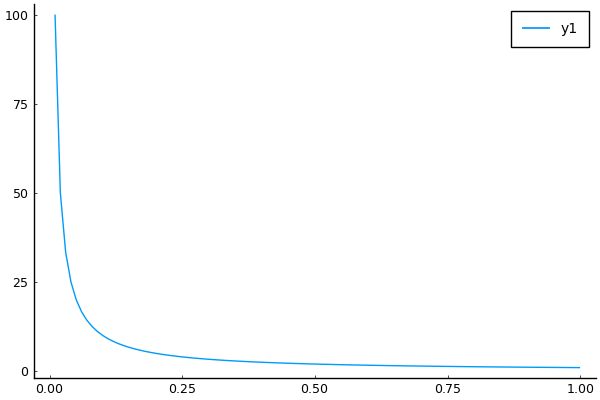

In [322]:
plot(0.0:0.01:1.0, collect(0.0:0.01:1.0) ./ (collect(0.0:0.01:1.0).^2 .+ .0))

In [282]:
Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


In [283]:
rmse_enkf = norm(mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1))

0.0282041682699826

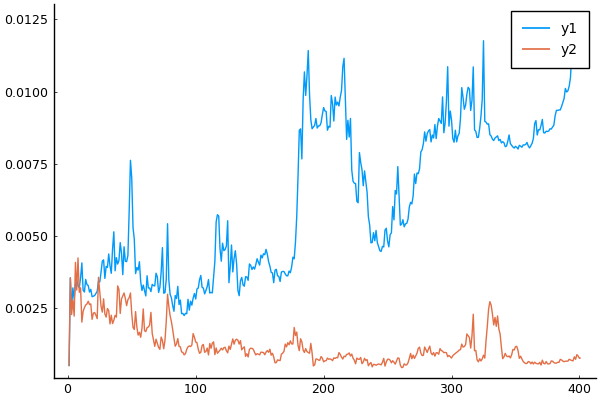

In [290]:
plot(norm.(eachcol((mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1)))))
plot!(norm.(eachcol((mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1)))))

In [286]:
100*(rmse_enkf - rmse_lowrankenkf)/rmse_enkf

-1.6846635657738387

In [338]:
Cx = zeros(Nx, Nx)
Cy = zeros(Ny, Ny)

Xcxcy = deepcopy(vcat(zeros(Ny, Ne), Xflowrank[1]))

ϵX = config.ϵX
ϵΓ = config.ϵΓ
ϵQ = config.ϵQ
β = config.β
ϵY = config.ϵY

ϵx = RecipeInflation([ϵX; ϵΓ; ϵQ])
ϵmul = MultiplicativeInflation(β)

# Perform state inflation
ϵmul(Xcxcy, Ny+1, Ny+Nx)
ϵx(Xcxcy, Ny, Nx)
Dx = Diagonal(std(Xcxcy[Ny+1:end,:]; dims = 2)[:,1])
# Dx = I
Dϵ = config.ϵY*I
# Dϵ = I
@time @inbounds for i=1:Ne
    
    J = analytical_jacobian_pressure(config.ss, state_to_lagrange(Xcxcy[Ny+1:end,i], config.zs, config), freestream, tf)
    Ji = J[:,vcat(collect(1:3*config.Nv), collect(6*config.Nv+1:6*config.Nv+config.Ns))]
    Cx .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)'*(inv(Dϵ)*Ji*Dx)
    Cy .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)*(inv(Dϵ)*Ji*Dx)'

end

  0.057067 seconds (843.50 k allocations: 58.907 MiB)


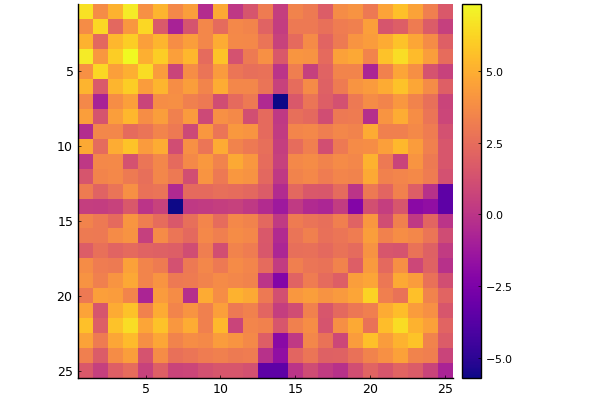

In [339]:
heatmap(1:Nx, 1:Nx, log.(abs.(Cx)), yflip = true, ratio = 1.0, xlim = (-Inf, Inf),
            colorbar = true, color = :plasma, background_color_inside = palette(:plasma)[1])

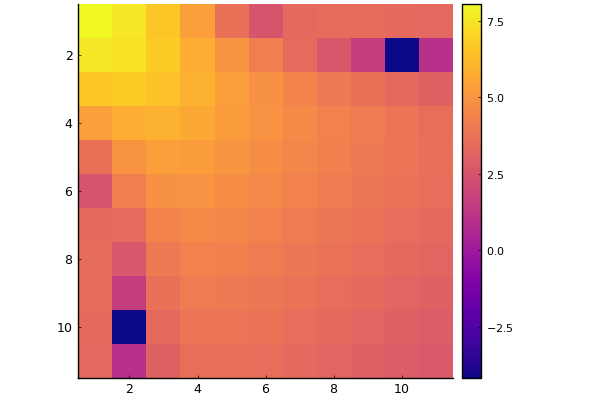

In [340]:
heatmap(log.(abs.(Cy)), yflip = true, ratio = 1.0, xlim = (-Inf, Inf),
            colorbar = true, color = :plasma, background_color_inside = palette(:plasma)[1])

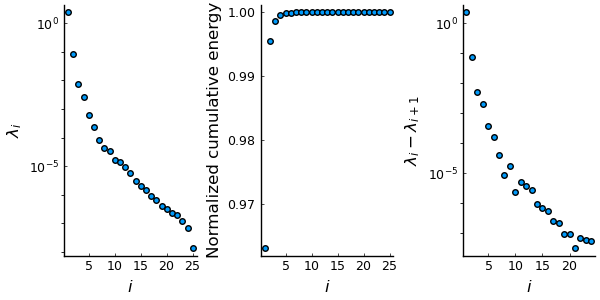

In [328]:
routine_spectrum(svd(Symmetric(Cx)).S)

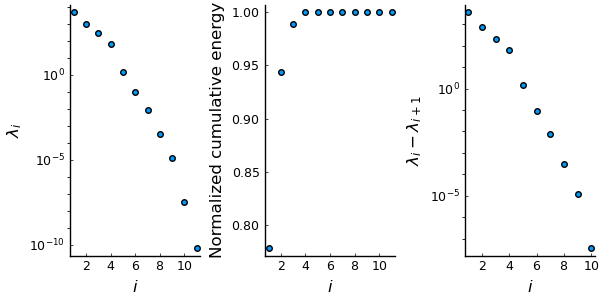

In [342]:
routine_spectrum(svd(Symmetric(Cy)).S)

In [343]:
cumsum(svd(Symmetric(Cx)).S) ./ sum(svd(Symmetric(Cx)).S)

25-element Vector{Float64}:
 0.487990339739091
 0.6773371656717666
 0.8189125785089759
 0.9095987332907904
 0.9435612736950472
 0.9632194198289625
 0.9771788526053445
 0.9888041676158497
 0.9959099339959618
 0.9977129160675368
 0.9985827813255429
 0.9990283028262086
 0.9993710745238926
 0.999645367238273
 0.9997782107812309
 0.9998592198553163
 0.9999248397370248
 0.9999535124127548
 0.9999736768978634
 0.9999839239445412
 0.9999900870278728
 0.9999957076195625
 0.9999984218333623
 0.9999995530651313
 1.0000000000000002

In [344]:
cumsum(svd(Symmetric(Cy)).S) ./ sum(svd(Symmetric(Cy)).S)

11-element Vector{Float64}:
 0.7781012132372708
 0.9441104457924068
 0.9891478622194708
 0.9997377762728478
 0.9999830895728782
 0.9999986324616376
 0.9999999462229061
 0.9999999979972146
 0.9999999999943182
 0.9999999999999899
 0.9999999999999999

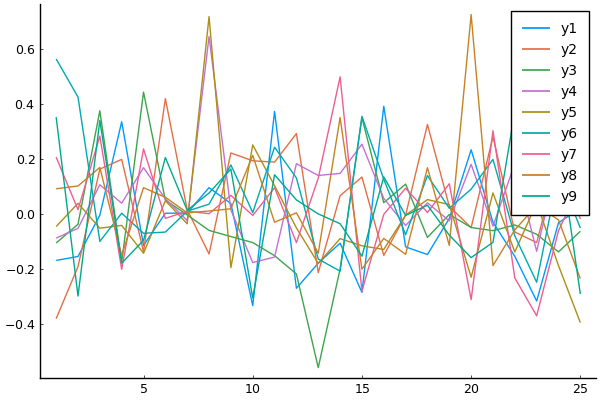

In [226]:
plot(svd(Symmetric(Cx)).U[:,1:9])

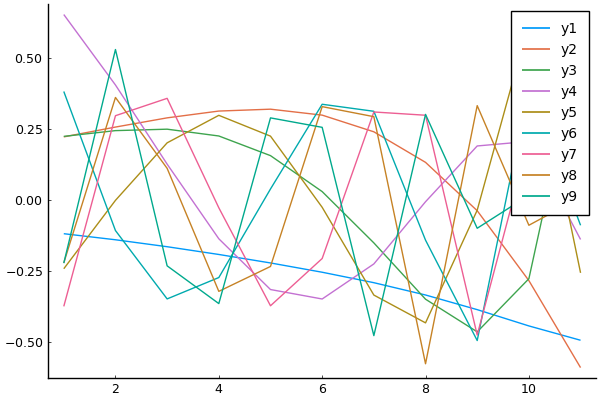

In [227]:
plot(svd(Symmetric(Cy)).U[:,1:9])

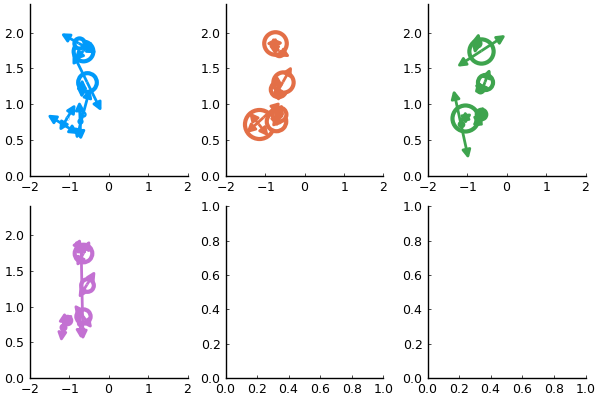

In [229]:
routine_plotCx(mean(Xa[101]; dims= 2)[:,1], Cx, 4, config, xgrid, ygrid; withvortices = true)

In [35]:
Xtmp = deepcopy(Xflowrank[end])
ϵx = RecipeInflation([config.ϵX; config.ϵΓ; config.ϵQ])
ϵmul = MultiplicativeInflation(config.β)

ϵmul(Xtmp, 1, Nx)
for i=1:Ne
    ϵx(view(Xtmp,:,i))
end
Y = hcat(map(i->measure_state(Xtmp[:,i], tf, config), 1:Ne)...)

11×500 Matrix{Float64}:
 -0.427359  -0.427365  -0.427378  …  -0.427365  -0.427374  -0.427379
 -0.433083  -0.433091  -0.433101     -0.433094  -0.433098  -0.433102
 -0.443162  -0.443172  -0.443179     -0.443179  -0.443177  -0.443179
 -0.458448  -0.458461  -0.458463     -0.458472  -0.458461  -0.458462
 -0.47894   -0.478957  -0.478954     -0.478974  -0.478952  -0.478951
 -0.503259  -0.50328   -0.503271  …  -0.503301  -0.503269  -0.503265
 -0.528711  -0.528738  -0.528723     -0.52876   -0.52872   -0.528715
 -0.55217   -0.552206  -0.552188     -0.552222  -0.552181  -0.552178
 -0.571082  -0.57113   -0.571113     -0.57113   -0.571098  -0.571105
 -0.58354   -0.583597  -0.58359      -0.583574  -0.583564  -0.583589
 -0.587467  -0.587525  -0.587536  …  -0.587488  -0.587499  -0.58754

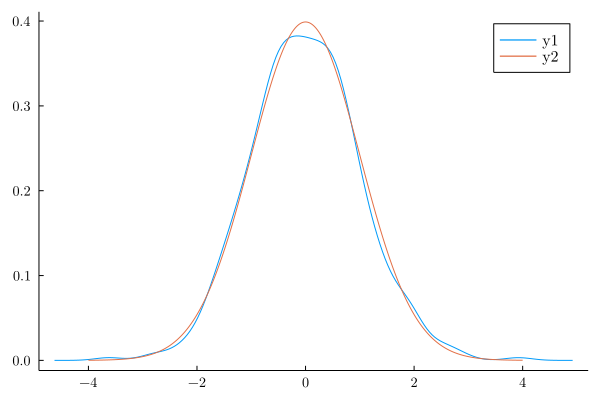

In [36]:
density(transform(Y[4:4,:])[1,:])
plot!(-4.0:0.01:4.0, map(x->1/sqrt(2*π)*exp(-0.5*x^2), -4.0:0.01:4.0))

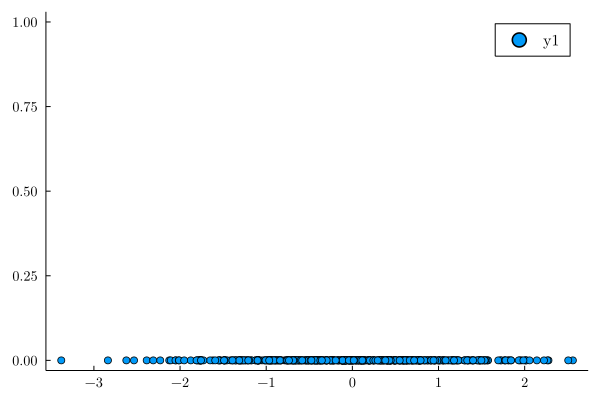

In [168]:
scatter(transform(Xalowrank[201][9:9,:])[1,:], zeros(Ne))

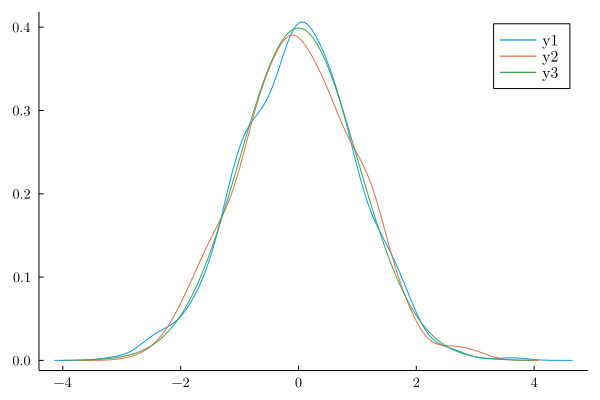

In [167]:
density(transform(Xa[401][9:9,:])[1,:])
density!(transform(Xalowrank[401][9:9,:])[1,:])
plot!(-4.0:0.01:4.0, map(x->1/sqrt(2*π)*exp(-0.5*x^2), -4.0:0.01:4.0))

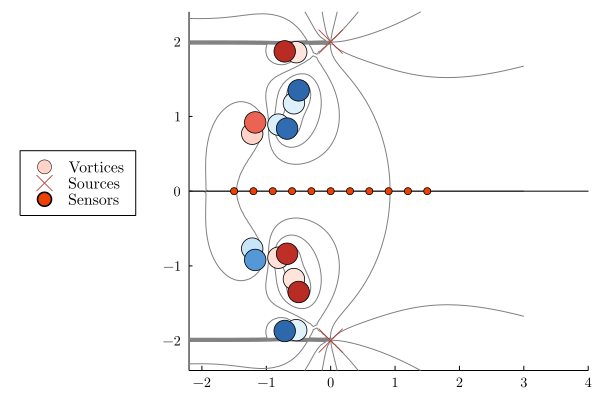

In [165]:
routine_plot(mean(Xa[101]; dims= 2)[:,1], config, xgrid, ygrid; withvortices = true)

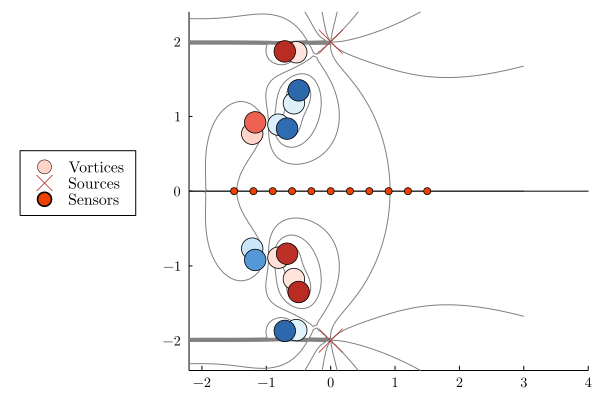

In [166]:
routine_plot(mean(Xalowrank[101]; dims= 2)[:,1], config, xgrid, ygrid; withvortices = true)

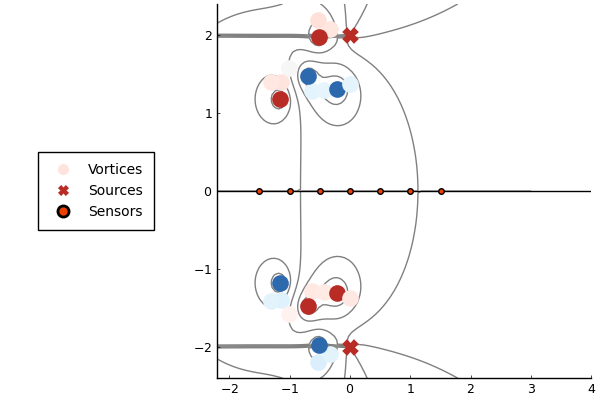

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [270]:
routine_plot(data.xt[:,101], config, xgrid, ygrid; withvortices = true)

In [271]:
maximum(Xalowrank[end])

4.226257652563084

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   2%|█                                        |  ETA: 0:00:47sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   4%|█▌                                       |  ETA: 0:00:43sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   5%|██                                       |  ETA: 0:00:42sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   6%|██▌                                      |  ETA: 0:00:40sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   7%|███                                      |  ETA: 0:00:39sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   9%|███▌                                     |  ETA: 0:00:38sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  10%|████                              

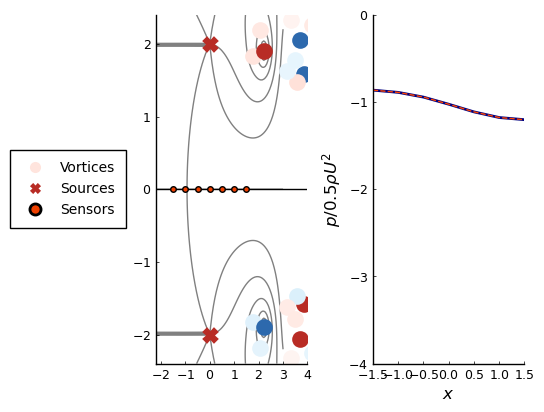

┌ Info: Saved animation to 
│   fn = /media/mat/HDD/ToyVortex.jl/notebooks/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/media/mat/HDD/ToyVortex.jl/notebooks/tmp.gif")
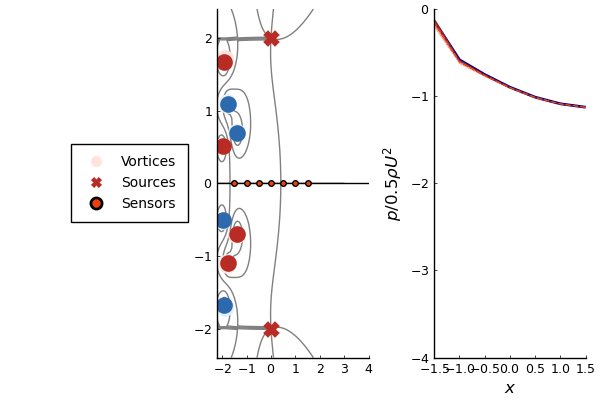

In [272]:
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config.Δt)+1
    
    Ysnap = hcat(map(xi -> measure_state(xi, 1.0, config), eachcol(Xa[nsnap]))...)
#     plt1 = routine_plot(data.xt[:,nsnap], config, xgrid, ygrid)
    plt2 = routine_plot(mean(Xalowrank[nsnap]; dims = 2)[:,1], config, xgrid, ygrid)
    plt3 = plot(xlim = (-Inf, Inf), 
                linewidth = 2, ylim = (-4.0, 0.0), legend = false, xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
    plot!(plt3, real(config.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config), 
          linewidth = 2, color = :navyblue)
    plot!(plt3, real(config.ss), 2*mean(Ysnap; dims = 2)[:,1],
          linewdith = 2, color = :orangered, linestyle = :dash, ribbon = 2*std(Ysnap; dims = 2)[:,1])
    plot(plt2, plt3)
    next!(prog)
end

In [273]:
maximum(vcat(Xalowrank...))

4.226257652563084

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   2%|█                                        |  ETA: 0:00:30sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   4%|█▌                                       |  ETA: 0:00:33sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   5%|██                                       |  ETA: 0:00:34sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   6%|██▌                                      |  ETA: 0:00:34sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   7%|███                                      |  ETA: 0:00:34sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   9%|███▌                                     |  ETA: 0:00:34sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  10%|████                              

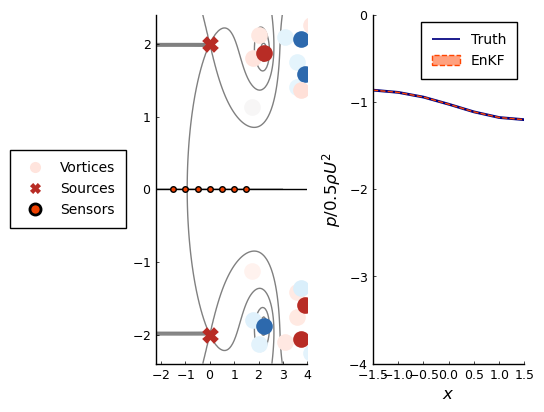

┌ Info: Saved animation to 
│   fn = /media/mat/HDD/ToyVortex.jl/notebooks/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/media/mat/HDD/ToyVortex.jl/notebooks/tmp.gif")
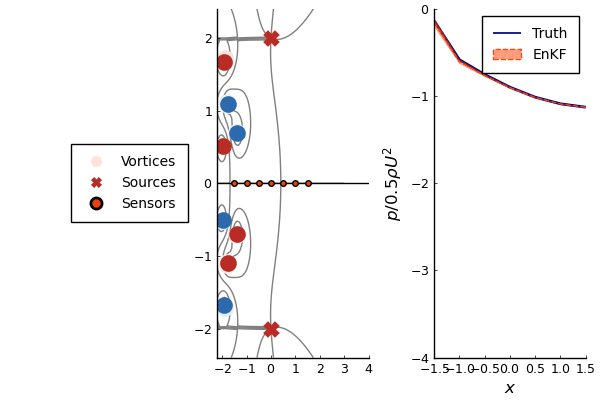

In [274]:
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config.Δt)+1
    
    Ysnap = hcat(map(xi -> measure_state(xi, 1.0, config), eachcol(Xa[nsnap]))...)
    plt1 = routine_plot(mean(Xa[nsnap]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
    plt2 = plot(xlim = (-Inf, Inf), 
                linewidth = 2, ylim = (-4.0, 0.0), xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
    plot!(plt2, real(config.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config), 
          linewidth = 2, color = :navyblue, label = "Truth")
    plot!(plt2, real(config.ss), 2*mean(Ysnap; dims = 2)[:,1],
          linewdith = 2, color = :orangered, linestyle = :dash, ribbon = 2*std(Ysnap; dims = 2)[:,1], label = "EnKF")
    plot(plt1, plt2)
    next!(prog)
end

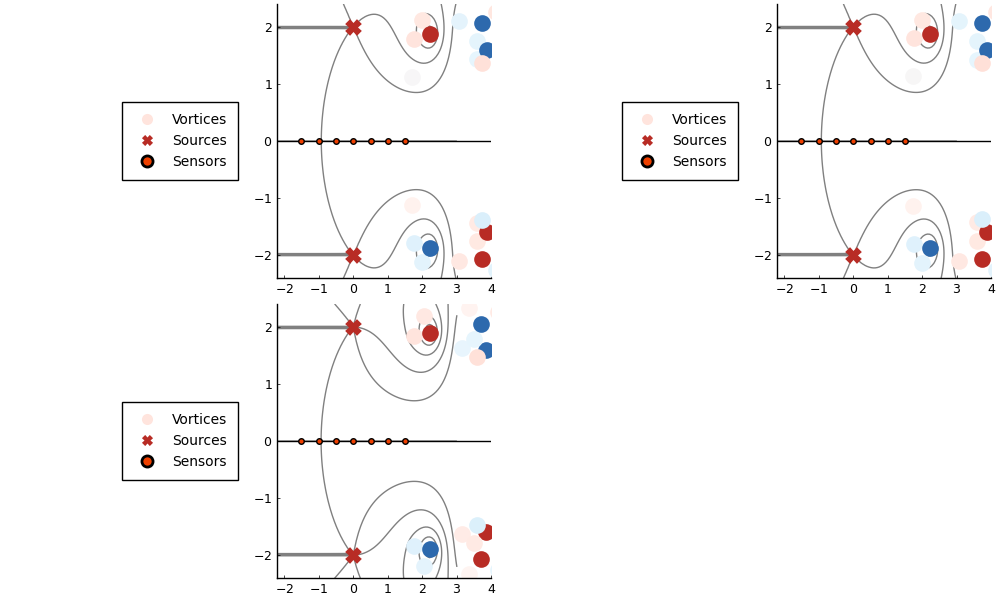

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [275]:
plt1 = routine_plot(data.xt[:,401], config, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(mean(Xa[401]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
plt3 = routine_plot(mean(Xalowrank[401]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
plot(plt1, plt2, plt3, size = (1000, 600))

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   2%|█                                        |  ETA: 0:00:45sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   4%|█▌                                       |  ETA: 0:00:58sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:   5%|██                                       |  ETA: 0:01:04sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwa

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:28sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  69%|████████████████████████████▍            |  ETA: 0:00:27sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  70%|████████████████████████████▉            |  ETA: 0:00:26sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:25sys:1: UserWarning: The following kwargs 

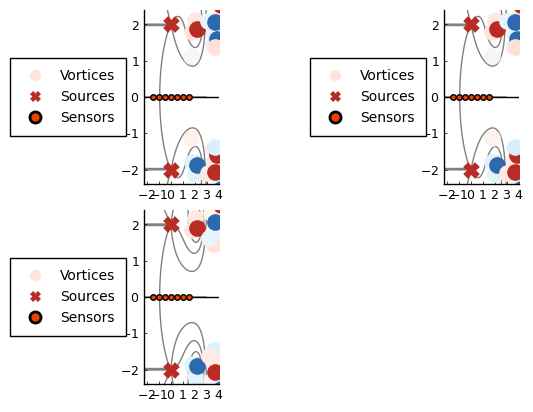

┌ Info: Saved animation to 
│   fn = /media/mat/HDD/ToyVortex.jl/notebooks/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/media/mat/HDD/ToyVortex.jl/notebooks/tmp.gif")
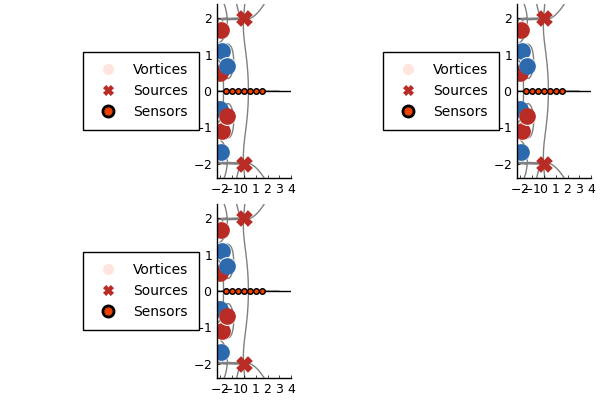

In [276]:
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config.Δt)+1
    
    Ysnap = hcat(map(xi -> measure_state(xi, 1.0, config), eachcol(Xa[nsnap]))...)
    plt1 = routine_plot(data.xt[:,nsnap], config, xgrid, ygrid; withvortices = true)
    plt2 = routine_plot(mean(Xa[nsnap]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
    plt3 = routine_plot(mean(Xalowrank[nsnap]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)

    plot(plt1, plt2, plt3)
    next!(prog)
end

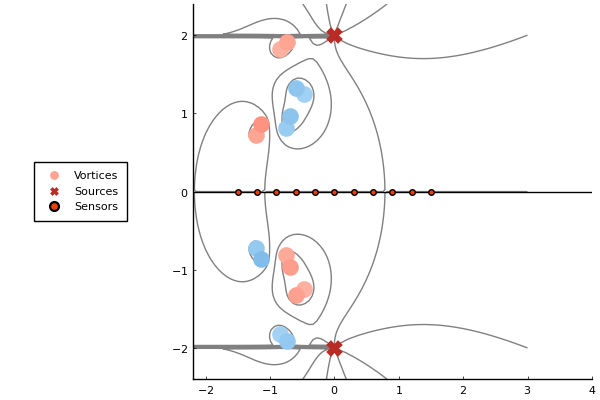

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [93]:
routine_plot(mean(Xa[101]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)

In [94]:
measure_state(data.xt[:,end], tf, config)-measure_state(mean(Xa[end]; dims = 2)[:,1], tf, config)

11-element Vector{Float64}:
  6.362848261221021e-6
  5.801375899006089e-6
  5.009176701376017e-6
  3.974228153236226e-6
  2.7182390203162043e-6
  1.2963869577276022e-6
 -2.454489794745385e-7
 -1.9885633346650167e-6
 -4.367440440966597e-6
 -8.543525647386474e-6
 -1.677134713140571e-5

In [95]:
map(xi-> measure_state(xi, tf, config), eachcol(Xa[end]))[1]

11-element Vector{Float64}:
 -0.4268237421143064
 -0.43229863923889916
 -0.4420032784970439
 -0.4566895198879433
 -0.4761886480008662
 -0.4988591218571955
 -0.5216520282121421
 -0.5410383320747009
 -0.5542142456452642
 -0.5598064276893245
 -0.5581570943234471

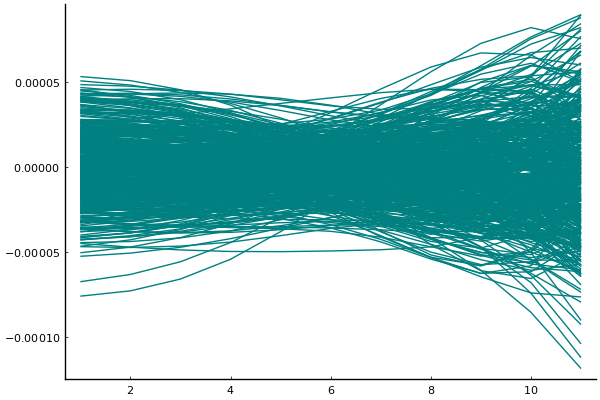

In [96]:
plot(map(xi-> measure_state(xi, tf, config)  - measure_state(mean(Xa[end]; dims=2)[:,1], tf, config), 
        eachcol(Xa[end])),
        color = :teal, linewdith = 2, legend = false)
# plot!(measure_state(data.xt[:,end], tf, config), linewidth = 2,
#       color = :orangered2, linestyle = :dash)

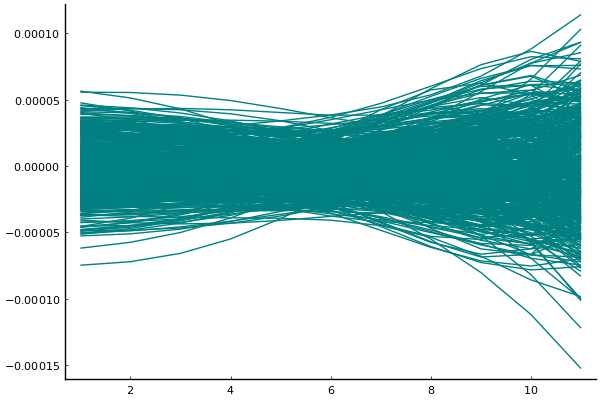

In [97]:
plot(map(xi-> measure_state(xi, tf, config)  - measure_state(mean(Xf[end]; dims=2)[:,1], tf, config), 
        eachcol(Xf[end])),
        color = :teal, linewdith = 2, legend = false)

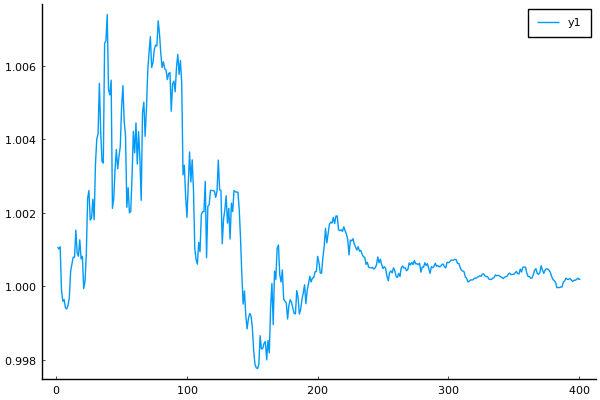

In [98]:
plot(hcat(mean.(Xalowrank; dims = 2)...)[end,:])

In [99]:
J = jacobian_pressure(config.ss, state_to_lagrange(Xa[end][:,1], config.zs, config), freestream, tf)

11×50 Matrix{Float64}:
 -0.00536145  0.00205991   0.000112305  …   0.0368174    0.0368174
 -0.00639636  0.00255385   0.000215395      0.0344128    0.0344128
 -0.00767256  0.00317286   0.000281816      0.0299923    0.0299923
 -0.00923541  0.00395668   0.000274169      0.0230978    0.0230978
 -0.0111257   0.00496496   0.000164268      0.0136464    0.0136464
 -0.0133621   0.00628038  -2.92156e-5   …   0.00224315   0.00224315
 -0.0158905   0.0079871   -0.000190207     -0.00977374  -0.00977374
 -0.0184551   0.0100861   -5.74489e-5      -0.0207658   -0.0207658
 -0.0203482   0.0122953    0.000813784     -0.0294591   -0.0294591
 -0.0201104   0.0137285    0.00306654      -0.035333    -0.035333
 -0.015625    0.0127493    0.00740562   …  -0.0385594   -0.0385594

In [110]:
 cumsum(svd(Symmetric(Cx)).S)./sum(svd(Symmetric(Cx)).S)

25-element Vector{Float64}:
 0.6681933665414967
 0.9160547060782901
 0.9785203974384282
 0.9969743624810625
 0.998975448878397
 0.9993131131933654
 0.9995550600421969
 0.9996629041135013
 0.9997512839474035
 0.9998143491994708
 0.999860559873983
 0.9998957771067523
 0.9999211007719049
 0.9999386708140486
 0.9999539200548163
 0.9999667007110551
 0.9999771784956322
 0.999983822537578
 0.9999894316407507
 0.9999925475543354
 0.9999950055088012
 0.999996752715211
 0.9999979315653077
 0.9999990336635767
 0.9999999999999999